# Dynamic Hand Gesture Recognition

## Importing

In [ ]:
!pip install mediapipe keras tensorflow torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import cv2

from google.colab.patches import cv2_imshow

import torch.nn as nn
import torch.optim as optim

## Dataset Preprocessing

In [ ]:
from huggingface_hub import hf_hub_download

REPO_ID = "Seba213/rgb-dhgr-dataset"
DATASET_NAME = "rgb_blur_split.zip"

In [ ]:
dataset = hf_hub_download(repo_id=REPO_ID, filename=DATASET_NAME, repo_type="dataset")

In [ ]:
dataset

'/root/.cache/huggingface/hub/datasets--Seba213--rgb-dhgr-dataset/snapshots/eac39e89515b334863ea2432c22551b1d6bcd4bf/rgb_blur_split.zip'

In [ ]:
!sudo unzip /root/.cache/huggingface/hub/datasets--Seba213--rgb-dhgr-dataset/snapshots/eac39e89515b334863ea2432c22551b1d6bcd4bf/rgb_blur_split.zip -d /content/

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/14.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/28.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/29.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/15.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/17.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/16.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/12.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/13.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/39.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/11.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/10.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/38.png  
  

In [ ]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [ ]:
mp_drawing = mp.solutions.drawing_utils

In [ ]:
TEST_IMAGE_PATH = "/content/rgb_blur_split/train/scroll_right/2021-10-28-103337_8/12.png"

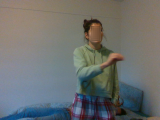

In [ ]:
original_img = cv2.imread(TEST_IMAGE_PATH)
cv2_imshow(original_img)

In [ ]:
MARGIN = 30  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

In [ ]:
def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    x_coordinates = []
    y_coordinates = []

    # Loop through the detected hands to visualize
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the coordinates of all the keypoints
        height, width, _ = annotated_image.shape
        x_coordinates += [int(landmark.x * width) for landmark in hand_landmarks]
        y_coordinates += [int(landmark.y * height) for landmark in hand_landmarks]

    return annotated_image, x_coordinates, y_coordinates

In [ ]:
def crop_hands_region(rgb_image, x_coordinates, y_coordinates):

    height, width, _ = rgb_image.shape

    x_min = max(min(x_coordinates) - MARGIN, 0)
    x_max = min(max(x_coordinates) + MARGIN, width)
    y_min = max(min(y_coordinates) - MARGIN, 0)
    y_max = min(max(y_coordinates) + MARGIN, height)

    return rgb_image[y_min:y_max, x_min:x_max]

In [ ]:
def cropping(image_path):
  base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
  options = vision.HandLandmarkerOptions(base_options=base_options,num_hands=2)
  detector = vision.HandLandmarker.create_from_options(options)

  image = mp.Image.create_from_file(image_path)

  detection_result = detector.detect(image)

  annotated_image, x, y = draw_landmarks_on_image(image.numpy_view(), detection_result)

  if not x or not y:
    return None
  else:
    cropped_image = crop_hands_region(image.numpy_view(), x, y)
    return cropped_image

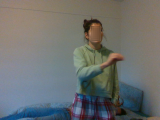

ValueError: min() arg is an empty sequence

In [ ]:
import numpy as np

# Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# Load the input image.
image = mp.Image.create_from_file(TEST_IMAGE_PATH)

# Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# Process the classification result. In this case, visualize it.
annotated_image, x, y = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Display the cropped images
# Assuming 'cropped_images' is a list of images:
cropped_image = crop_hands_region(image.numpy_view(), x, y)
cv2_imshow(cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

In [ ]:
def resize_image(cropped_image):
  image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  image_resized = cv2.resize(image, (75, 75))

  image_resized = image_resized / 255.0

  image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.float32)

  image_tensor = tf.expand_dims(image_tensor, axis=0)

  return image_tensor

In [ ]:
def preprocess_data(image_path):
  cropped_image = cropping(image_path)

  if cropped_image is not None:
    image = resize_image(cropped_image)
    return image
  else:
    return None

In [ ]:
import tensorflow as tf

print("Original Image shape:", original_img.shape)

# Load image using OpenCV
image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Print shape
print("Cropped Image shape:", image.shape)

# Resize to (75, 75)
image_resized = cv2.resize(image, (75, 75))

# Normalize (optional)
image_resized = image_resized / 255.0

# Convert to tensor
image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.float32)

# Add batch dimension if needed
image_tensor = tf.expand_dims(image_tensor, axis=0)


print("Final tensor shape:", image_tensor.shape)

Original Image shape: (120, 160, 3)
Cropped Image shape: (55, 73, 3)
Final tensor shape: (1, 75, 75, 3)


In [ ]:
import os
import tensorflow as tf
import numpy as np
from collections import defaultdict
from tqdm import tqdm  # Importa tqdm per la progress bar

DATASET_PATH = "/content/rgb_blur_split"

train_dir = os.path.join(DATASET_PATH, "train")

labels = [label for label in os.listdir(train_dir) if not label.startswith('.')]

# Initialize nested dictionary
dataset_dict = defaultdict(lambda: defaultdict(dict))
preprocessed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

def numerical_sort(file_list):
    return sorted(file_list, key=lambda x: int(os.path.splitext(x)[0]))

# Conta il numero totale di iterazioni per tqdm
total_iterations = sum(
    len(os.listdir(os.path.join(DATASET_PATH, split, class_label)))
    for split in ["train", "val", "test"]
    for class_label in os.listdir(os.path.join(DATASET_PATH, split)) if not class_label.startswith('.')
)

# Usa tqdm per mostrare la progress bar
with tqdm(total=total_iterations, desc="Processing examples") as pbar:
    for split in ["train", "val", "test"]:
        split_path = os.path.join(DATASET_PATH, split)

        class_labels = [label for label in os.listdir(split_path) if not label.startswith('.')]

        for class_label in class_labels:
            class_path = os.path.join(split_path, class_label)

            examples = [example for example in os.listdir(class_path) if not example.startswith('.')]

            for example in examples:
                example_path = os.path.join(class_path, example)

                frame_files = numerical_sort(os.listdir(example_path))
                frame_paths = [os.path.join(example_path, f) for f in frame_files if not f.startswith('.')]

                sampled_frames = frame_paths[::4]

                # Store in dictionary
                dataset_dict[split][class_label][example] = sampled_frames

                for frame_path in sampled_frames:
                    image_tensor = preprocess_data(frame_path)

                    if image_tensor is not None:
                        preprocessed_data[split][class_label][example].append(image_tensor)

                pbar.update(1)  # Aggiorna la progress bar

Processing examples:  22%|██▏       | 923/4189 [15:25<54:36,  1.00s/it]


KeyboardInterrupt: 

In [5]:
import pickle

In [ ]:
# Convert defaultdict to a normal dict
normal_dict = {k: dict(v) for k, v in preprocessed_data.items()}

# Save to a pickle file
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump(normal_dict, f)

In [ ]:
DATA_NAME = "preprocessed_data.pkl"

preprocessed_data_path = hf_hub_download(repo_id=REPO_ID, filename=DATA_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessed_data.pkl:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
# Load the dictionary back
with open(preprocessed_data_path, "rb") as f:
    loaded_data = pickle.load(f)

In [ ]:
from pprint import pprint
import json

def print_preprocessed_data(preprocessed_data):
    """Prints the preprocessed_data dictionary in a structured format."""
    for split, classes in preprocessed_data.items():
        print(f"\n Split: {split.upper()}")
        for class_label, examples in classes.items():
            print(f"  Class: {class_label}")
            for example, frames in examples.items():
                print(f"    Example: {example}")
                print(f"      Frames Processed ({len(frames)}):")
                for idx, frame in enumerate(frames):
                    print(f"        {idx+1}. Tensor Shape: {frame.shape}")  # Print tensor shape

In [ ]:
print_preprocessed_data(extracted_features)

Output streaming troncato alle ultime 5000 righe.
        9. Tensor Shape: (1, 1, 2048)
        10. Tensor Shape: (1, 1, 2048)
    Example: 2021-11-05-090421_30
      Frames Processed (10):
        1. Tensor Shape: (1, 1, 2048)
        2. Tensor Shape: (1, 1, 2048)
        3. Tensor Shape: (1, 1, 2048)
        4. Tensor Shape: (1, 1, 2048)
        5. Tensor Shape: (1, 1, 2048)
        6. Tensor Shape: (1, 1, 2048)
        7. Tensor Shape: (1, 1, 2048)
        8. Tensor Shape: (1, 1, 2048)
        9. Tensor Shape: (1, 1, 2048)
        10. Tensor Shape: (1, 1, 2048)
    Example: 2021-10-17-113832_4
      Frames Processed (10):
        1. Tensor Shape: (1, 1, 2048)
        2. Tensor Shape: (1, 1, 2048)
        3. Tensor Shape: (1, 1, 2048)
        4. Tensor Shape: (1, 1, 2048)
        5. Tensor Shape: (1, 1, 2048)
        6. Tensor Shape: (1, 1, 2048)
        7. Tensor Shape: (1, 1, 2048)
        8. Tensor Shape: (1, 1, 2048)
        9. Tensor Shape: (1, 1, 2048)
        10. Tensor Shape:

In [ ]:
total_frames = 0
total_examples
for split in extracted_features:
    for class_label in extracted_features[split]:
        for example_id, frames in extracted_features[split][class_label].items():
          if len(frames) == 10
            total_frames += len(frames)

print(f"Total number of frames in the dataset: {total_frames}")


Total number of frames in the dataset: 33519


In [ ]:
from collections import defaultdict
from tqdm import tqdm  # Importa tqdm per la progress bar
import os
import tensorflow as tf
import numpy as np

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define input shape
INPUT_SHAPE = (75, 75, 3)

# Load pre-trained InceptionV3 without the top classification layers
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
  )

# Extract features from the last convolutional layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
# features = feature_extractor.predict(image_tensor)
# print("Feature shape:", features.shape)

# Initialize dictionary to store extracted features
extracted_features = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Count total frames for tqdm progress bar
total_frames = sum(
    len(frames) for split in loaded_data.values()
    for classes in split.values()
    for examples in classes.values()
    for frames in examples
)

In [ ]:
def extract_features(frames):
  frame_batch = np.array(frames)
  frame_batch = np.squeeze(frame_batch.astype(np.float32), axis = 1)
  extracted = feature_extractor.predict(frame_batch, verbose=1)
  return extracted

In [ ]:
# Extract features with progress tracking
with tqdm(total=total_frames, desc="Extracting features") as pbar:
    for split, classes in loaded_data.items():
        for class_label, examples in classes.items():
            for example, frames in examples.items():

                extracted_features[split][class_label][example] = extract_features(frames)

                pbar.update(1)  # Update progress bar

# Check model summary
feature_extractor.summary()

Extracting features:   0%|          | 0/33519 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   0%|          | 1/33519 [00:03<32:36:01,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   0%|          | 2/33519 [00:08<41:44:59,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   0%|          | 3/33519 [00:08<23:54:54,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   0%|          | 4/33519 [00:09<15:56:37,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   0%|          | 5/33519 [00:09<11:31:02,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:   0%|          | 6/33519 [00:10<8:55:20,  1.04it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   0%|          | 7/33519 [00:10<6:48:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 8/33519 [00:10<5:13:44,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   0%|          | 9/33519 [00:10<4:11:05,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   0%|          | 10/33519 [00:11<3:27:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting features:   0%|          | 11/33519 [00:11<2:58:55,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   0%|          | 12/33519 [00:11<2:34:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   0%|          | 13/33519 [00:11<2:24:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   0%|          | 14/33519 [00:12<2:42:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   0%|          | 15/33519 [00:12<2:29:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   0%|          | 16/33519 [00:12<2:21:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   0%|          | 17/33519 [00:12<2:21:36,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   0%|          | 18/33519 [00:12<2:15:18,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   0%|          | 19/33519 [00:13<2:11:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   0%|          | 20/33519 [00:13<1:58:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 21/33519 [00:13<1:58:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   0%|          | 22/33519 [00:13<1:48:07,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   0%|          | 23/33519 [00:13<1:50:48,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   0%|          | 24/33519 [00:14<1:50:22,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 25/33519 [00:14<1:54:06,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 26/33519 [00:14<1:55:45,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   0%|          | 27/33519 [00:14<1:56:58,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   0%|          | 28/33519 [00:14<2:01:32,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   0%|          | 29/33519 [00:15<2:01:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   0%|          | 30/33519 [00:15<1:59:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:   0%|          | 31/33519 [00:15<1:57:57,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   0%|          | 32/33519 [00:15<1:48:10,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 33/33519 [00:15<1:49:52,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   0%|          | 34/33519 [00:16<1:51:45,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   0%|          | 35/33519 [00:16<1:52:52,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   0%|          | 36/33519 [00:16<1:54:42,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   0%|          | 37/33519 [00:16<1:57:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 38/33519 [00:16<1:54:55,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   0%|          | 39/33519 [00:17<1:55:29,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 40/33519 [00:17<1:50:27,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 41/33519 [00:17<1:51:49,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   0%|          | 42/33519 [00:17<1:52:25,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   0%|          | 43/33519 [00:17<1:54:28,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   0%|          | 44/33519 [00:18<1:55:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 45/33519 [00:18<2:00:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   0%|          | 46/33519 [00:18<1:59:06,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   0%|          | 47/33519 [00:18<1:57:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   0%|          | 48/33519 [00:19<1:56:29,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   0%|          | 49/33519 [00:19<1:59:10,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   0%|          | 50/33519 [00:19<1:58:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   0%|          | 51/33519 [00:19<1:58:12,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   0%|          | 52/33519 [00:19<2:00:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   0%|          | 53/33519 [00:20<1:59:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 54/33519 [00:20<2:00:24,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   0%|          | 55/33519 [00:20<1:59:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   0%|          | 56/33519 [00:20<2:12:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:   0%|          | 57/33519 [00:21<2:38:45,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   0%|          | 58/33519 [00:21<2:37:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   0%|          | 59/33519 [00:21<2:56:11,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   0%|          | 60/33519 [00:22<3:10:14,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Extracting features:   0%|          | 61/33519 [00:22<3:22:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:   0%|          | 62/33519 [00:23<3:30:33,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   0%|          | 63/33519 [00:23<3:22:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   0%|          | 64/33519 [00:23<3:29:17,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 65/33519 [00:24<3:01:14,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   0%|          | 66/33519 [00:24<2:41:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   0%|          | 67/33519 [00:24<2:28:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   0%|          | 68/33519 [00:24<2:09:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   0%|          | 69/33519 [00:24<2:05:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   0%|          | 70/33519 [00:25<1:58:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   0%|          | 71/33519 [00:25<1:57:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 72/33519 [00:25<1:56:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   0%|          | 73/33519 [00:25<1:57:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   0%|          | 74/33519 [00:25<2:07:37,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   0%|          | 75/33519 [00:26<1:58:08,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 76/33519 [00:26<1:54:03,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   0%|          | 77/33519 [00:26<1:55:52,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   0%|          | 78/33519 [00:26<1:51:53,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   0%|          | 79/33519 [00:26<1:53:30,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 80/33519 [00:27<1:54:09,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   0%|          | 81/33519 [00:27<1:54:18,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   0%|          | 82/33519 [00:27<1:56:19,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   0%|          | 83/33519 [00:27<1:47:27,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   0%|          | 84/33519 [00:27<1:52:30,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   0%|          | 85/33519 [00:28<1:48:43,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   0%|          | 86/33519 [00:28<1:51:58,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 87/33519 [00:28<1:51:20,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   0%|          | 88/33519 [00:28<1:46:40,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   0%|          | 89/33519 [00:28<1:51:49,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   0%|          | 90/33519 [00:29<1:53:06,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   0%|          | 91/33519 [00:29<1:47:15,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   0%|          | 92/33519 [00:29<1:49:26,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   0%|          | 93/33519 [00:29<1:50:29,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   0%|          | 94/33519 [00:29<1:53:55,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   0%|          | 95/33519 [00:30<1:46:52,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 96/33519 [00:30<1:49:05,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   0%|          | 97/33519 [00:30<1:47:39,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   0%|          | 98/33519 [00:30<1:53:27,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   0%|          | 99/33519 [00:30<1:52:56,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   0%|          | 100/33519 [00:31<1:55:04,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   0%|          | 101/33519 [00:31<1:44:39,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   0%|          | 102/33519 [00:31<1:54:41,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   0%|          | 103/33519 [00:31<1:48:15,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   0%|          | 104/33519 [00:31<1:51:33,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   0%|          | 105/33519 [00:32<1:52:20,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   0%|          | 106/33519 [00:32<1:48:02,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   0%|          | 107/33519 [00:32<1:49:38,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   0%|          | 108/33519 [00:32<1:51:13,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   0%|          | 109/33519 [00:32<1:55:29,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   0%|          | 110/33519 [00:33<1:56:28,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   0%|          | 111/33519 [00:33<1:57:46,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   0%|          | 112/33519 [00:33<1:57:46,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   0%|          | 113/33519 [00:33<1:59:22,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   0%|          | 114/33519 [00:34<2:05:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   0%|          | 115/33519 [00:34<2:06:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:   0%|          | 116/33519 [00:34<2:34:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:   0%|          | 117/33519 [00:34<2:33:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:   0%|          | 118/33519 [00:35<2:52:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:   0%|          | 119/33519 [00:35<3:09:07,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   0%|          | 120/33519 [00:36<3:19:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   0%|          | 121/33519 [00:36<3:02:00,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Extracting features:   0%|          | 122/33519 [00:36<3:15:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   0%|          | 123/33519 [00:37<3:24:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   0%|          | 124/33519 [00:37<2:57:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   0%|          | 125/33519 [00:37<2:39:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   0%|          | 126/33519 [00:37<2:26:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 127/33519 [00:38<2:17:25,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   0%|          | 128/33519 [00:38<2:06:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   0%|          | 129/33519 [00:38<1:58:27,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   0%|          | 130/33519 [00:38<1:58:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   0%|          | 131/33519 [00:38<2:04:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   0%|          | 132/33519 [00:39<2:00:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 133/33519 [00:39<2:00:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   0%|          | 134/33519 [00:39<1:55:12,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   0%|          | 135/33519 [00:39<1:55:43,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   0%|          | 136/33519 [00:39<1:56:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   0%|          | 137/33519 [00:40<1:46:25,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   0%|          | 138/33519 [00:40<1:46:00,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   0%|          | 139/33519 [00:40<1:41:53,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   0%|          | 140/33519 [00:40<1:42:19,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   0%|          | 141/33519 [00:40<1:46:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   0%|          | 142/33519 [00:40<1:50:56,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   0%|          | 143/33519 [00:41<1:51:40,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 144/33519 [00:41<1:47:23,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   0%|          | 145/33519 [00:41<1:44:34,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   0%|          | 146/33519 [00:41<1:49:14,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   0%|          | 147/33519 [00:41<1:53:51,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   0%|          | 148/33519 [00:42<1:55:08,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   0%|          | 149/33519 [00:42<1:56:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   0%|          | 150/33519 [00:42<1:56:20,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   0%|          | 151/33519 [00:42<1:56:07,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   0%|          | 152/33519 [00:43<1:56:34,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   0%|          | 153/33519 [00:43<1:53:06,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 154/33519 [00:43<1:53:24,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   0%|          | 155/33519 [00:43<1:48:41,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   0%|          | 156/33519 [00:43<1:50:45,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   0%|          | 157/33519 [00:44<1:51:46,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   0%|          | 158/33519 [00:44<1:48:38,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   0%|          | 159/33519 [00:44<1:58:20,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   0%|          | 160/33519 [00:44<1:58:28,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   0%|          | 161/33519 [00:44<2:00:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   0%|          | 162/33519 [00:45<1:58:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   0%|          | 163/33519 [00:45<1:58:10,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   0%|          | 164/33519 [00:45<1:57:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   0%|          | 165/33519 [00:45<1:50:56,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   0%|          | 166/33519 [00:45<1:53:39,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   0%|          | 167/33519 [00:46<1:51:42,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   1%|          | 168/33519 [00:46<1:52:00,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   1%|          | 169/33519 [00:46<1:54:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   1%|          | 170/33519 [00:46<1:55:35,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 171/33519 [00:46<1:53:52,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   1%|          | 172/33519 [00:47<1:54:53,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:   1%|          | 173/33519 [00:47<2:06:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   1%|          | 174/33519 [00:47<2:38:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Extracting features:   1%|          | 175/33519 [00:48<2:56:26,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   1%|          | 176/33519 [00:48<3:08:31,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   1%|          | 177/33519 [00:48<3:17:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:   1%|          | 178/33519 [00:49<3:23:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:   1%|          | 179/33519 [00:49<3:29:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:   1%|          | 180/33519 [00:50<3:35:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   1%|          | 181/33519 [00:50<3:06:48,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   1%|          | 182/33519 [00:50<2:46:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   1%|          | 183/33519 [00:50<2:31:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|          | 184/33519 [00:51<2:21:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 185/33519 [00:51<2:13:41,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   1%|          | 186/33519 [00:51<2:06:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   1%|          | 187/33519 [00:51<2:03:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   1%|          | 188/33519 [00:51<2:11:45,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 189/33519 [00:52<2:07:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   1%|          | 190/33519 [00:52<2:05:38,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 191/33519 [00:52<2:03:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 192/33519 [00:52<1:55:50,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 193/33519 [00:52<1:58:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 194/33519 [00:53<1:58:55,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   1%|          | 195/33519 [00:53<1:55:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   1%|          | 196/33519 [00:53<1:56:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   1%|          | 197/33519 [00:53<1:55:48,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 198/33519 [00:54<1:56:21,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   1%|          | 199/33519 [00:54<1:50:03,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 200/33519 [00:54<1:54:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 201/33519 [00:54<1:56:08,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|          | 202/33519 [00:54<1:55:35,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   1%|          | 203/33519 [00:55<1:56:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   1%|          | 204/33519 [00:55<1:49:53,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   1%|          | 205/33519 [00:55<1:48:33,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   1%|          | 206/33519 [00:55<1:52:09,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   1%|          | 207/33519 [00:55<1:54:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   1%|          | 208/33519 [00:56<1:55:03,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   1%|          | 209/33519 [00:56<1:55:24,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   1%|          | 210/33519 [00:56<1:57:49,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   1%|          | 211/33519 [00:56<1:57:52,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   1%|          | 212/33519 [00:56<1:56:47,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 213/33519 [00:57<1:57:03,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   1%|          | 214/33519 [00:57<1:57:59,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   1%|          | 215/33519 [00:57<1:59:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 216/33519 [00:57<1:57:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   1%|          | 217/33519 [00:57<2:01:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 218/33519 [00:58<2:01:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   1%|          | 219/33519 [00:58<2:01:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   1%|          | 220/33519 [00:58<1:53:47,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 221/33519 [00:58<1:54:44,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:   1%|          | 222/33519 [00:59<1:54:53,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   1%|          | 223/33519 [00:59<1:48:54,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   1%|          | 224/33519 [00:59<1:46:54,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   1%|          | 225/33519 [00:59<1:44:37,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   1%|          | 226/33519 [00:59<1:48:17,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   1%|          | 227/33519 [00:59<1:52:22,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 228/33519 [01:00<1:49:29,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   1%|          | 229/33519 [01:00<2:25:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:   1%|          | 230/33519 [01:00<2:33:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:   1%|          | 231/33519 [01:01<2:31:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   1%|          | 232/33519 [01:01<2:51:00,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   1%|          | 233/33519 [01:01<3:05:31,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   1%|          | 234/33519 [01:02<3:17:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   1%|          | 235/33519 [01:02<3:25:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   1%|          | 236/33519 [01:03<3:15:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:   1%|          | 237/33519 [01:03<3:23:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   1%|          | 238/33519 [01:03<2:57:14,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|          | 239/33519 [01:03<2:37:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|          | 240/33519 [01:04<2:24:16,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   1%|          | 241/33519 [01:04<2:14:10,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 242/33519 [01:04<2:05:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   1%|          | 243/33519 [01:04<2:02:23,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   1%|          | 244/33519 [01:04<2:01:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   1%|          | 245/33519 [01:05<2:04:25,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 246/33519 [01:05<1:56:50,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   1%|          | 247/33519 [01:05<1:58:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 248/33519 [01:05<1:57:31,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   1%|          | 249/33519 [01:05<1:59:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   1%|          | 250/33519 [01:06<1:51:39,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 251/33519 [01:06<1:46:58,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:   1%|          | 252/33519 [01:06<1:49:40,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   1%|          | 253/33519 [01:06<1:53:51,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|          | 254/33519 [01:06<1:57:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 255/33519 [01:07<1:57:47,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|          | 256/33519 [01:07<1:55:45,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   1%|          | 257/33519 [01:07<1:55:52,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   1%|          | 258/33519 [01:07<1:54:48,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 259/33519 [01:08<1:55:46,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   1%|          | 260/33519 [01:08<1:52:40,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   1%|          | 261/33519 [01:08<1:52:37,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   1%|          | 262/33519 [01:08<1:52:59,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   1%|          | 263/33519 [01:08<1:53:39,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   1%|          | 264/33519 [01:09<1:53:53,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 265/33519 [01:09<1:51:38,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting features:   1%|          | 266/33519 [01:09<1:53:15,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 267/33519 [01:09<1:55:02,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   1%|          | 268/33519 [01:09<1:59:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   1%|          | 269/33519 [01:10<1:58:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|          | 270/33519 [01:10<1:57:30,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   1%|          | 271/33519 [01:10<1:57:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 272/33519 [01:10<1:57:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   1%|          | 273/33519 [01:10<1:59:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   1%|          | 274/33519 [01:11<1:55:56,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 275/33519 [01:11<1:55:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 276/33519 [01:11<1:52:53,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   1%|          | 277/33519 [01:11<1:55:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 278/33519 [01:11<1:58:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   1%|          | 279/33519 [01:12<1:59:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   1%|          | 280/33519 [01:12<1:59:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 281/33519 [01:12<1:58:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   1%|          | 282/33519 [01:12<1:58:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   1%|          | 283/33519 [01:13<1:57:40,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|          | 284/33519 [01:13<1:57:10,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   1%|          | 285/33519 [01:13<1:56:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   1%|          | 286/33519 [01:13<2:05:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:   1%|          | 287/33519 [01:14<2:39:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   1%|          | 288/33519 [01:14<2:41:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:   1%|          | 289/33519 [01:14<3:01:24,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   1%|          | 290/33519 [01:15<2:46:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   1%|          | 291/33519 [01:15<2:51:57,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:   1%|          | 292/33519 [01:15<3:08:47,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   1%|          | 293/33519 [01:16<3:18:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   1%|          | 294/33519 [01:16<3:27:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|          | 295/33519 [01:16<3:00:27,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   1%|          | 296/33519 [01:17<2:41:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 297/33519 [01:17<2:27:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   1%|          | 298/33519 [01:17<2:08:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   1%|          | 299/33519 [01:17<2:04:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 300/33519 [01:17<1:57:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


Extracting features:   1%|          | 301/33519 [01:18<2:52:55,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 302/33519 [01:18<3:01:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|          | 303/33519 [01:18<2:39:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   1%|          | 304/33519 [01:19<2:24:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   1%|          | 305/33519 [01:19<2:16:53,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 306/33519 [01:19<2:06:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting features:   1%|          | 307/33519 [01:19<2:04:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 308/33519 [01:19<2:02:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   1%|          | 309/33519 [01:20<2:00:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   1%|          | 310/33519 [01:20<1:58:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   1%|          | 311/33519 [01:20<1:51:18,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 312/33519 [01:20<1:51:56,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   1%|          | 313/33519 [01:20<1:55:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 314/33519 [01:21<1:56:37,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   1%|          | 315/33519 [01:21<1:56:47,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 316/33519 [01:21<1:54:33,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   1%|          | 317/33519 [01:21<1:54:52,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 318/33519 [01:22<1:56:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 319/33519 [01:22<1:56:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   1%|          | 320/33519 [01:22<1:55:21,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   1%|          | 321/33519 [01:22<1:56:41,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 322/33519 [01:22<1:53:26,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   1%|          | 323/33519 [01:23<1:54:13,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   1%|          | 324/33519 [01:23<1:54:28,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   1%|          | 325/33519 [01:23<1:54:15,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   1%|          | 326/33519 [01:23<1:56:28,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   1%|          | 327/33519 [01:23<2:00:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   1%|          | 328/33519 [01:24<1:59:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 329/33519 [01:24<1:53:18,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   1%|          | 330/33519 [01:24<1:54:37,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   1%|          | 331/33519 [01:24<2:01:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   1%|          | 332/33519 [01:25<1:59:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   1%|          | 333/33519 [01:25<1:58:27,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   1%|          | 334/33519 [01:25<1:51:25,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   1%|          | 335/33519 [01:25<1:52:41,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 336/33519 [01:25<1:53:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 337/33519 [01:26<1:53:18,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|          | 338/33519 [01:26<1:50:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|          | 339/33519 [01:26<1:52:39,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   1%|          | 340/33519 [01:26<1:46:36,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   1%|          | 341/33519 [01:26<1:49:24,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   1%|          | 342/33519 [01:27<1:59:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:   1%|          | 343/33519 [01:27<2:31:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:   1%|          | 344/33519 [01:27<2:53:59,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:   1%|          | 345/33519 [01:28<2:48:25,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:   1%|          | 346/33519 [01:28<3:04:45,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   1%|          | 347/33519 [01:28<3:17:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Extracting features:   1%|          | 348/33519 [01:29<3:26:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Extracting features:   1%|          | 349/33519 [01:29<3:25:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Extracting features:   1%|          | 350/33519 [01:30<3:35:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|          | 351/33519 [01:30<3:06:07,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   1%|          | 352/33519 [01:30<2:45:56,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 353/33519 [01:30<2:33:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   1%|          | 354/33519 [01:31<2:19:39,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   1%|          | 355/33519 [01:31<2:13:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 356/33519 [01:31<2:08:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   1%|          | 357/33519 [01:31<1:55:33,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   1%|          | 358/33519 [01:31<1:56:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|          | 359/33519 [01:32<2:01:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   1%|          | 360/33519 [01:32<1:51:54,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   1%|          | 361/33519 [01:32<1:54:40,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|          | 362/33519 [01:32<1:55:56,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   1%|          | 363/33519 [01:33<2:22:50,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   1%|          | 364/33519 [01:33<2:10:32,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   1%|          | 365/33519 [01:33<2:07:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 366/33519 [01:33<2:04:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   1%|          | 367/33519 [01:33<2:02:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   1%|          | 368/33519 [01:34<2:00:32,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|          | 369/33519 [01:34<1:55:40,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|          | 370/33519 [01:34<1:55:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 371/33519 [01:34<1:54:54,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   1%|          | 372/33519 [01:34<1:54:19,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   1%|          | 373/33519 [01:35<1:55:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   1%|          | 374/33519 [01:35<1:56:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   1%|          | 375/33519 [01:35<1:58:04,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   1%|          | 376/33519 [01:35<1:59:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   1%|          | 377/33519 [01:35<2:01:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   1%|          | 378/33519 [01:36<2:01:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 379/33519 [01:36<1:57:23,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|          | 380/33519 [01:36<1:54:52,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|          | 381/33519 [01:36<1:55:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   1%|          | 382/33519 [01:36<1:49:20,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|          | 383/33519 [01:37<1:50:48,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   1%|          | 384/33519 [01:37<1:51:12,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   1%|          | 385/33519 [01:37<1:53:53,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 386/33519 [01:37<1:50:43,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   1%|          | 387/33519 [01:38<1:56:11,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   1%|          | 388/33519 [01:38<1:56:46,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   1%|          | 389/33519 [01:38<1:56:32,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|          | 390/33519 [01:38<1:57:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   1%|          | 391/33519 [01:38<1:56:31,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   1%|          | 392/33519 [01:39<1:57:19,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   1%|          | 393/33519 [01:39<1:53:10,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   1%|          | 394/33519 [01:39<1:53:39,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   1%|          | 395/33519 [01:39<1:53:50,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|          | 396/33519 [01:39<1:56:14,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:   1%|          | 397/33519 [01:40<2:25:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   1%|          | 398/33519 [01:40<2:49:08,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   1%|          | 399/33519 [01:41<3:10:08,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   1%|          | 400/33519 [01:41<3:20:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Extracting features:   1%|          | 401/33519 [01:41<3:28:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Extracting features:   1%|          | 402/33519 [01:42<3:36:16,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Extracting features:   1%|          | 403/33519 [01:42<3:37:59,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:   1%|          | 404/33519 [01:43<3:39:54,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 405/33519 [01:43<3:13:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   1%|          | 406/33519 [01:43<2:50:33,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   1%|          | 407/33519 [01:43<2:34:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   1%|          | 408/33519 [01:44<2:16:40,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   1%|          | 409/33519 [01:44<2:07:54,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 410/33519 [01:44<2:07:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   1%|          | 411/33519 [01:44<2:05:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 412/33519 [01:44<1:58:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|          | 413/33519 [01:45<1:52:49,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|          | 414/33519 [01:45<1:50:29,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   1%|          | 415/33519 [01:45<1:54:25,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   1%|          | 416/33519 [01:45<1:57:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   1%|          | 417/33519 [01:45<1:59:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|          | 418/33519 [01:46<1:58:13,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   1%|▏         | 419/33519 [01:46<1:57:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|▏         | 420/33519 [01:46<1:56:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   1%|▏         | 421/33519 [01:46<1:58:03,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   1%|▏         | 422/33519 [01:46<1:58:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   1%|▏         | 423/33519 [01:47<1:54:11,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|▏         | 424/33519 [01:47<1:54:20,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|▏         | 425/33519 [01:47<1:50:12,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   1%|▏         | 426/33519 [01:47<1:54:55,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   1%|▏         | 427/33519 [01:47<1:54:00,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|▏         | 428/33519 [01:48<1:54:29,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   1%|▏         | 429/33519 [01:48<1:54:38,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   1%|▏         | 430/33519 [01:48<1:49:12,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   1%|▏         | 431/33519 [01:48<1:51:20,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   1%|▏         | 432/33519 [01:48<1:47:02,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   1%|▏         | 433/33519 [01:49<1:51:33,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   1%|▏         | 434/33519 [01:49<1:54:19,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|▏         | 435/33519 [01:49<1:52:28,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   1%|▏         | 436/33519 [01:49<1:55:39,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   1%|▏         | 437/33519 [01:50<1:57:42,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   1%|▏         | 438/33519 [01:50<1:58:33,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   1%|▏         | 439/33519 [01:50<1:57:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   1%|▏         | 440/33519 [01:50<1:57:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   1%|▏         | 441/33519 [01:50<1:55:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   1%|▏         | 442/33519 [01:51<1:55:48,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   1%|▏         | 443/33519 [01:51<1:55:36,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   1%|▏         | 444/33519 [01:51<1:56:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   1%|▏         | 445/33519 [01:51<2:31:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   1%|▏         | 446/33519 [01:52<2:22:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   1%|▏         | 447/33519 [01:52<2:14:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   1%|▏         | 448/33519 [01:52<2:09:22,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   1%|▏         | 449/33519 [01:52<2:06:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   1%|▏         | 450/33519 [01:52<2:03:53,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|▏         | 451/33519 [01:53<2:02:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:   1%|▏         | 452/33519 [01:53<2:28:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Extracting features:   1%|▏         | 453/33519 [01:53<2:50:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   1%|▏         | 454/33519 [01:54<2:49:57,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Extracting features:   1%|▏         | 455/33519 [01:54<2:52:45,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Extracting features:   1%|▏         | 456/33519 [01:55<3:05:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   1%|▏         | 457/33519 [01:55<3:18:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:   1%|▏         | 458/33519 [01:55<3:27:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   1%|▏         | 459/33519 [01:56<3:18:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   1%|▏         | 460/33519 [01:56<3:24:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   1%|▏         | 461/33519 [01:56<3:32:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|▏         | 462/33519 [01:57<3:04:39,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   1%|▏         | 463/33519 [01:57<2:44:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   1%|▏         | 464/33519 [01:57<2:30:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   1%|▏         | 465/33519 [01:57<2:19:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   1%|▏         | 466/33519 [01:58<2:05:57,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   1%|▏         | 467/33519 [01:58<1:56:35,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   1%|▏         | 468/33519 [01:58<1:56:51,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|▏         | 469/33519 [01:58<1:52:54,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|▏         | 470/33519 [01:58<1:55:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   1%|▏         | 471/33519 [01:59<1:53:52,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|▏         | 472/33519 [01:59<1:55:48,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   1%|▏         | 473/33519 [01:59<2:02:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   1%|▏         | 474/33519 [01:59<1:58:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   1%|▏         | 475/33519 [01:59<2:01:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   1%|▏         | 476/33519 [02:00<1:59:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|▏         | 477/33519 [02:00<1:58:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|▏         | 478/33519 [02:00<1:57:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   1%|▏         | 479/33519 [02:00<1:56:41,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   1%|▏         | 480/33519 [02:00<1:55:04,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|▏         | 481/33519 [02:01<1:57:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   1%|▏         | 482/33519 [02:01<1:53:18,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|▏         | 483/33519 [02:01<1:55:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   1%|▏         | 484/33519 [02:01<1:54:31,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   1%|▏         | 485/33519 [02:02<1:57:25,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   1%|▏         | 486/33519 [02:02<1:52:43,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   1%|▏         | 487/33519 [02:02<1:53:55,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   1%|▏         | 488/33519 [02:02<1:54:24,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   1%|▏         | 489/33519 [02:02<1:55:04,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   1%|▏         | 490/33519 [02:03<1:55:12,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   1%|▏         | 491/33519 [02:03<1:54:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   1%|▏         | 492/33519 [02:03<1:54:17,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   1%|▏         | 493/33519 [02:03<1:53:57,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   1%|▏         | 494/33519 [02:04<2:22:11,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   1%|▏         | 495/33519 [02:04<2:15:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|▏         | 496/33519 [02:04<2:04:40,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   1%|▏         | 497/33519 [02:04<2:03:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   1%|▏         | 498/33519 [02:05<2:27:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   1%|▏         | 499/33519 [02:05<2:13:36,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   1%|▏         | 500/33519 [02:05<2:00:40,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   1%|▏         | 501/33519 [02:05<1:59:59,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   1%|▏         | 502/33519 [02:05<1:58:58,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 503/33519 [02:06<1:58:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   2%|▏         | 504/33519 [02:06<1:58:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 505/33519 [02:06<1:59:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 506/33519 [02:06<1:59:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:   2%|▏         | 507/33519 [02:06<2:05:46,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:   2%|▏         | 508/33519 [02:07<2:39:12,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


Extracting features:   2%|▏         | 509/33519 [02:08<3:53:31,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Extracting features:   2%|▏         | 510/33519 [02:08<4:41:46,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   2%|▏         | 511/33519 [02:09<4:26:00,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Extracting features:   2%|▏         | 512/33519 [02:09<4:13:37,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Extracting features:   2%|▏         | 513/33519 [02:10<4:04:43,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   2%|▏         | 514/33519 [02:10<3:57:16,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 515/33519 [02:10<3:15:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 516/33519 [02:10<2:50:44,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   2%|▏         | 517/33519 [02:11<2:36:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   2%|▏         | 518/33519 [02:11<2:24:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   2%|▏         | 519/33519 [02:11<2:12:59,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   2%|▏         | 520/33519 [02:11<2:09:42,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   2%|▏         | 521/33519 [02:11<2:05:10,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 522/33519 [02:12<2:04:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 523/33519 [02:12<2:02:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   2%|▏         | 524/33519 [02:12<2:01:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 525/33519 [02:12<1:59:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   2%|▏         | 526/33519 [02:12<1:55:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   2%|▏         | 527/33519 [02:13<1:55:35,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   2%|▏         | 528/33519 [02:13<1:52:56,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 529/33519 [02:13<1:51:18,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 530/33519 [02:13<1:58:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   2%|▏         | 531/33519 [02:13<1:53:12,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 532/33519 [02:14<1:54:58,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   2%|▏         | 533/33519 [02:14<1:56:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   2%|▏         | 534/33519 [02:14<1:52:42,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   2%|▏         | 535/33519 [02:14<1:54:36,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 536/33519 [02:14<1:51:59,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   2%|▏         | 537/33519 [02:15<1:54:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   2%|▏         | 538/33519 [02:15<1:53:57,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   2%|▏         | 539/33519 [02:15<1:54:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 540/33519 [02:15<1:50:02,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 541/33519 [02:16<1:54:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 542/33519 [02:16<1:51:44,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 543/33519 [02:16<1:53:29,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   2%|▏         | 544/33519 [02:16<1:55:03,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   2%|▏         | 545/33519 [02:16<1:57:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting features:   2%|▏         | 546/33519 [02:17<1:57:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   2%|▏         | 547/33519 [02:17<1:57:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   2%|▏         | 548/33519 [02:17<1:57:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   2%|▏         | 549/33519 [02:17<1:57:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   2%|▏         | 550/33519 [02:17<1:57:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 551/33519 [02:18<1:57:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   2%|▏         | 552/33519 [02:18<1:56:40,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 553/33519 [02:18<1:53:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   2%|▏         | 554/33519 [02:18<1:57:22,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   2%|▏         | 555/33519 [02:19<1:57:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 556/33519 [02:19<1:58:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   2%|▏         | 557/33519 [02:19<1:50:32,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 558/33519 [02:19<1:54:16,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   2%|▏         | 559/33519 [02:19<2:03:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   2%|▏         | 560/33519 [02:20<1:57:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   2%|▏         | 561/33519 [02:20<1:57:15,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:   2%|▏         | 562/33519 [02:20<2:23:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:   2%|▏         | 563/33519 [02:21<2:50:12,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:   2%|▏         | 564/33519 [02:21<3:05:42,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   2%|▏         | 565/33519 [02:21<3:07:25,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Extracting features:   2%|▏         | 566/33519 [02:22<3:02:40,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:   2%|▏         | 567/33519 [02:22<3:17:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   2%|▏         | 568/33519 [02:23<3:29:46,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:   2%|▏         | 569/33519 [02:23<3:16:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:   2%|▏         | 570/33519 [02:23<3:01:28,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   2%|▏         | 571/33519 [02:23<3:09:23,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   2%|▏         | 572/33519 [02:24<2:42:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 573/33519 [02:24<2:28:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 574/33519 [02:24<2:18:38,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   2%|▏         | 575/33519 [02:24<2:38:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 576/33519 [02:25<2:20:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 577/33519 [02:25<2:11:29,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 578/33519 [02:25<2:07:42,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   2%|▏         | 579/33519 [02:25<1:56:43,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   2%|▏         | 580/33519 [02:25<2:00:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   2%|▏         | 581/33519 [02:26<2:01:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 582/33519 [02:26<1:55:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   2%|▏         | 583/33519 [02:26<1:56:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   2%|▏         | 584/33519 [02:26<1:47:51,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 585/33519 [02:26<1:50:09,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   2%|▏         | 586/33519 [02:27<1:52:10,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   2%|▏         | 587/33519 [02:27<1:53:08,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 588/33519 [02:27<2:03:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 589/33519 [02:27<1:58:54,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 590/33519 [02:28<1:57:59,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 591/33519 [02:28<1:54:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 592/33519 [02:28<1:56:09,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 593/33519 [02:28<1:57:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   2%|▏         | 594/33519 [02:28<1:56:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   2%|▏         | 595/33519 [02:29<1:59:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   2%|▏         | 596/33519 [02:29<1:49:38,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 597/33519 [02:29<1:52:07,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   2%|▏         | 598/33519 [02:29<1:53:04,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   2%|▏         | 599/33519 [02:29<1:49:11,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 600/33519 [02:30<1:52:28,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   2%|▏         | 601/33519 [02:30<1:48:21,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 602/33519 [02:30<1:52:18,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 603/33519 [02:30<1:55:04,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   2%|▏         | 604/33519 [02:30<1:49:50,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 605/33519 [02:31<1:53:59,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   2%|▏         | 606/33519 [02:31<1:54:58,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 607/33519 [02:31<1:56:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   2%|▏         | 608/33519 [02:31<1:57:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   2%|▏         | 609/33519 [02:31<1:59:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   2%|▏         | 610/33519 [02:32<1:48:32,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   2%|▏         | 611/33519 [02:32<1:45:32,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 612/33519 [02:32<1:45:25,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   2%|▏         | 613/33519 [02:32<1:47:30,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 614/33519 [02:32<1:54:53,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   2%|▏         | 615/33519 [02:33<1:58:49,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 616/33519 [02:33<1:59:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   2%|▏         | 617/33519 [02:33<2:25:58,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   2%|▏         | 618/33519 [02:34<2:49:49,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   2%|▏         | 619/33519 [02:34<2:39:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Extracting features:   2%|▏         | 620/33519 [02:34<2:50:59,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   2%|▏         | 621/33519 [02:35<2:39:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   2%|▏         | 622/33519 [02:35<2:46:39,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   2%|▏         | 623/33519 [02:35<3:05:26,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   2%|▏         | 624/33519 [02:36<3:15:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   2%|▏         | 625/33519 [02:36<3:25:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   2%|▏         | 626/33519 [02:36<3:09:16,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 627/33519 [02:37<2:44:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   2%|▏         | 628/33519 [02:37<2:31:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 629/33519 [02:37<2:18:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 630/33519 [02:37<2:12:47,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   2%|▏         | 631/33519 [02:37<2:11:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   2%|▏         | 632/33519 [02:38<2:07:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 633/33519 [02:38<2:05:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 634/33519 [02:38<2:00:49,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   2%|▏         | 635/33519 [02:38<2:25:14,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 636/33519 [02:39<2:11:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   2%|▏         | 637/33519 [02:39<2:36:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 638/33519 [02:39<2:22:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 639/33519 [02:39<2:11:39,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   2%|▏         | 640/33519 [02:40<2:06:47,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   2%|▏         | 641/33519 [02:40<1:59:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 642/33519 [02:40<1:59:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   2%|▏         | 643/33519 [02:40<1:59:34,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   2%|▏         | 644/33519 [02:41<2:25:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   2%|▏         | 645/33519 [02:41<2:18:40,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   2%|▏         | 646/33519 [02:41<2:05:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   2%|▏         | 647/33519 [02:41<2:03:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   2%|▏         | 648/33519 [02:41<2:00:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   2%|▏         | 649/33519 [02:42<2:02:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   2%|▏         | 650/33519 [02:42<2:01:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 651/33519 [02:42<1:56:59,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 652/33519 [02:42<1:55:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   2%|▏         | 653/33519 [02:42<1:49:53,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   2%|▏         | 654/33519 [02:43<1:53:26,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   2%|▏         | 655/33519 [02:43<1:55:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 656/33519 [02:43<1:56:53,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 657/33519 [02:43<1:56:55,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   2%|▏         | 658/33519 [02:44<1:56:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 659/33519 [02:44<1:55:45,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   2%|▏         | 660/33519 [02:44<1:55:16,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   2%|▏         | 661/33519 [02:44<1:50:17,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   2%|▏         | 662/33519 [02:44<1:55:32,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 663/33519 [02:45<1:52:03,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   2%|▏         | 664/33519 [02:45<1:55:21,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 665/33519 [02:45<1:54:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   2%|▏         | 666/33519 [02:45<1:55:50,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   2%|▏         | 667/33519 [02:45<1:59:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   2%|▏         | 668/33519 [02:46<1:58:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 669/33519 [02:46<1:53:52,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   2%|▏         | 670/33519 [02:46<1:52:40,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   2%|▏         | 671/33519 [02:46<1:53:08,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   2%|▏         | 672/33519 [02:47<2:26:09,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   2%|▏         | 673/33519 [02:47<2:45:02,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   2%|▏         | 674/33519 [02:47<3:04:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Extracting features:   2%|▏         | 675/33519 [02:48<2:54:09,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:   2%|▏         | 676/33519 [02:48<3:07:18,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   2%|▏         | 677/33519 [02:49<3:23:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:   2%|▏         | 678/33519 [02:49<3:30:23,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   2%|▏         | 679/33519 [02:49<3:21:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:   2%|▏         | 680/33519 [02:50<3:29:32,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   2%|▏         | 681/33519 [02:50<3:01:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   2%|▏         | 682/33519 [02:50<2:41:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 683/33519 [02:50<2:29:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 684/33519 [02:51<2:14:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 685/33519 [02:51<2:12:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   2%|▏         | 686/33519 [02:51<2:06:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 687/33519 [02:51<2:05:23,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   2%|▏         | 688/33519 [02:51<2:03:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 689/33519 [02:52<1:57:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 690/33519 [02:52<1:58:20,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 691/33519 [02:52<1:57:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   2%|▏         | 692/33519 [02:52<2:24:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 693/33519 [02:53<2:12:30,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   2%|▏         | 694/33519 [02:53<2:08:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 695/33519 [02:53<2:03:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   2%|▏         | 696/33519 [02:53<1:54:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   2%|▏         | 697/33519 [02:54<2:00:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   2%|▏         | 698/33519 [02:54<1:53:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 699/33519 [02:54<1:56:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   2%|▏         | 700/33519 [02:54<1:57:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Extracting features:   2%|▏         | 701/33519 [02:54<2:09:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 702/33519 [02:55<2:07:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   2%|▏         | 703/33519 [02:55<2:01:47,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   2%|▏         | 704/33519 [02:55<1:54:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   2%|▏         | 705/33519 [02:55<1:56:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   2%|▏         | 706/33519 [02:55<1:58:21,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   2%|▏         | 707/33519 [02:56<1:58:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 708/33519 [02:56<1:56:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 709/33519 [02:56<1:57:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 710/33519 [02:56<1:54:37,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   2%|▏         | 711/33519 [02:57<1:56:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 712/33519 [02:57<1:58:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   2%|▏         | 713/33519 [02:57<1:56:16,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:   2%|▏         | 714/33519 [02:57<1:47:16,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   2%|▏         | 715/33519 [02:57<1:51:10,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 716/33519 [02:58<1:51:35,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 717/33519 [02:58<1:54:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   2%|▏         | 718/33519 [02:58<1:55:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   2%|▏         | 719/33519 [02:58<1:56:03,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 720/33519 [02:58<1:57:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 721/33519 [02:59<1:55:38,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   2%|▏         | 722/33519 [02:59<1:58:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 723/33519 [02:59<1:58:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 724/33519 [02:59<1:56:10,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   2%|▏         | 725/33519 [02:59<1:52:50,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 726/33519 [03:00<1:57:55,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   2%|▏         | 727/33519 [03:00<2:30:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   2%|▏         | 728/33519 [03:00<2:50:43,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   2%|▏         | 729/33519 [03:01<2:50:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   2%|▏         | 730/33519 [03:01<3:12:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   2%|▏         | 731/33519 [03:01<2:54:04,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:   2%|▏         | 732/33519 [03:02<3:07:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Extracting features:   2%|▏         | 733/33519 [03:02<3:19:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:   2%|▏         | 734/33519 [03:03<3:32:14,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 735/33519 [03:03<3:06:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   2%|▏         | 736/33519 [03:03<2:45:42,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 737/33519 [03:03<2:34:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 738/33519 [03:04<2:23:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   2%|▏         | 739/33519 [03:04<2:11:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   2%|▏         | 740/33519 [03:04<2:07:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 741/33519 [03:04<1:59:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:   2%|▏         | 742/33519 [03:04<2:00:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   2%|▏         | 743/33519 [03:05<2:00:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 744/33519 [03:05<2:00:37,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 745/33519 [03:05<1:58:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   2%|▏         | 746/33519 [03:05<1:58:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   2%|▏         | 747/33519 [03:06<1:59:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 748/33519 [03:06<1:58:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   2%|▏         | 749/33519 [03:06<2:00:26,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 750/33519 [03:06<1:58:49,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   2%|▏         | 751/33519 [03:06<1:54:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 752/33519 [03:07<1:55:29,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   2%|▏         | 753/33519 [03:07<1:54:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 754/33519 [03:07<1:54:48,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 755/33519 [03:07<1:51:33,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 756/33519 [03:07<1:56:42,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 757/33519 [03:08<1:58:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   2%|▏         | 758/33519 [03:08<1:58:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   2%|▏         | 759/33519 [03:08<1:58:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   2%|▏         | 760/33519 [03:08<1:59:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 761/33519 [03:09<1:54:30,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   2%|▏         | 762/33519 [03:09<1:56:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   2%|▏         | 763/33519 [03:09<1:56:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 764/33519 [03:09<1:56:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   2%|▏         | 765/33519 [03:09<1:58:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 766/33519 [03:10<1:53:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 767/33519 [03:10<1:54:25,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 768/33519 [03:10<1:56:07,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   2%|▏         | 769/33519 [03:10<1:57:57,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 770/33519 [03:10<1:59:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   2%|▏         | 771/33519 [03:11<1:56:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   2%|▏         | 772/33519 [03:11<1:51:02,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   2%|▏         | 773/33519 [03:11<1:54:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   2%|▏         | 774/33519 [03:11<1:54:42,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 775/33519 [03:11<1:53:51,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   2%|▏         | 776/33519 [03:12<1:55:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   2%|▏         | 777/33519 [03:12<1:55:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   2%|▏         | 778/33519 [03:12<1:53:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 779/33519 [03:12<1:53:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   2%|▏         | 780/33519 [03:13<1:54:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 781/33519 [03:13<1:56:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   2%|▏         | 782/33519 [03:13<2:28:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:   2%|▏         | 783/33519 [03:14<2:43:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   2%|▏         | 784/33519 [03:14<3:02:06,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   2%|▏         | 785/33519 [03:14<3:17:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   2%|▏         | 786/33519 [03:15<3:26:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Extracting features:   2%|▏         | 787/33519 [03:15<3:42:14,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   2%|▏         | 788/33519 [03:16<3:29:53,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   2%|▏         | 789/33519 [03:16<3:08:22,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   2%|▏         | 790/33519 [03:16<2:47:06,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   2%|▏         | 791/33519 [03:16<2:32:23,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   2%|▏         | 792/33519 [03:17<2:21:48,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 793/33519 [03:17<2:15:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 794/33519 [03:17<2:07:44,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   2%|▏         | 795/33519 [03:17<2:03:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   2%|▏         | 796/33519 [03:17<2:06:46,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   2%|▏         | 797/33519 [03:18<2:05:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   2%|▏         | 798/33519 [03:18<2:03:23,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   2%|▏         | 799/33519 [03:18<2:01:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   2%|▏         | 800/33519 [03:18<2:01:07,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 801/33519 [03:18<1:59:54,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 802/33519 [03:19<1:54:58,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   2%|▏         | 803/33519 [03:19<1:50:42,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   2%|▏         | 804/33519 [03:19<1:47:21,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   2%|▏         | 805/33519 [03:19<1:52:04,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 806/33519 [03:19<1:51:53,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   2%|▏         | 807/33519 [03:20<1:55:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   2%|▏         | 808/33519 [03:20<1:55:50,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 809/33519 [03:20<1:52:39,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   2%|▏         | 810/33519 [03:20<2:20:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   2%|▏         | 811/33519 [03:21<2:14:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 812/33519 [03:21<2:04:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   2%|▏         | 813/33519 [03:21<2:02:17,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 814/33519 [03:21<2:00:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   2%|▏         | 815/33519 [03:22<2:00:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   2%|▏         | 816/33519 [03:22<2:04:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   2%|▏         | 817/33519 [03:22<1:58:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   2%|▏         | 818/33519 [03:22<1:59:53,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   2%|▏         | 819/33519 [03:23<2:28:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   2%|▏         | 820/33519 [03:23<2:16:38,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   2%|▏         | 821/33519 [03:23<2:07:57,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   2%|▏         | 822/33519 [03:23<2:05:28,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   2%|▏         | 823/33519 [03:23<2:05:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 824/33519 [03:24<1:58:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   2%|▏         | 825/33519 [03:24<1:51:58,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   2%|▏         | 826/33519 [03:24<1:49:12,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   2%|▏         | 827/33519 [03:24<1:49:02,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   2%|▏         | 828/33519 [03:24<1:53:24,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   2%|▏         | 829/33519 [03:25<1:55:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   2%|▏         | 830/33519 [03:25<1:57:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   2%|▏         | 831/33519 [03:25<1:57:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   2%|▏         | 832/33519 [03:25<1:58:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   2%|▏         | 833/33519 [03:26<1:58:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   2%|▏         | 834/33519 [03:26<1:52:43,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:   2%|▏         | 835/33519 [03:26<2:25:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   2%|▏         | 836/33519 [03:27<2:48:45,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   2%|▏         | 837/33519 [03:27<2:40:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   3%|▎         | 838/33519 [03:27<2:45:23,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   3%|▎         | 839/33519 [03:28<3:05:09,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   3%|▎         | 840/33519 [03:28<2:56:38,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   3%|▎         | 841/33519 [03:28<3:13:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   3%|▎         | 842/33519 [03:28<2:56:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   3%|▎         | 843/33519 [03:29<2:58:29,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   3%|▎         | 844/33519 [03:29<3:21:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   3%|▎         | 845/33519 [03:30<3:00:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   3%|▎         | 846/33519 [03:30<2:41:31,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 847/33519 [03:30<2:28:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 848/33519 [03:30<2:20:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   3%|▎         | 849/33519 [03:30<2:15:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   3%|▎         | 850/33519 [03:31<2:10:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   3%|▎         | 851/33519 [03:31<2:00:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   3%|▎         | 852/33519 [03:31<2:00:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   3%|▎         | 853/33519 [03:31<2:00:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 854/33519 [03:31<2:01:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 855/33519 [03:32<2:00:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   3%|▎         | 856/33519 [03:32<2:02:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 857/33519 [03:32<2:01:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 858/33519 [03:32<2:01:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 859/33519 [03:33<2:00:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   3%|▎         | 860/33519 [03:33<1:59:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 861/33519 [03:33<1:58:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   3%|▎         | 862/33519 [03:33<1:52:10,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   3%|▎         | 863/33519 [03:33<1:57:15,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   3%|▎         | 864/33519 [03:34<1:55:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   3%|▎         | 865/33519 [03:34<2:23:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 866/33519 [03:34<2:14:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   3%|▎         | 867/33519 [03:34<2:11:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 868/33519 [03:35<2:07:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 869/33519 [03:35<2:04:25,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 870/33519 [03:35<2:02:42,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 871/33519 [03:35<1:56:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 872/33519 [03:36<1:57:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   3%|▎         | 873/33519 [03:36<2:04:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 874/33519 [03:36<2:02:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 875/33519 [03:36<2:00:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   3%|▎         | 876/33519 [03:36<2:01:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   3%|▎         | 877/33519 [03:37<2:01:20,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   3%|▎         | 878/33519 [03:37<1:55:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 879/33519 [03:37<1:54:55,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   3%|▎         | 880/33519 [03:37<2:22:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 881/33519 [03:38<2:14:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   3%|▎         | 882/33519 [03:38<2:03:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 883/33519 [03:38<2:02:48,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   3%|▎         | 884/33519 [03:38<2:00:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 885/33519 [03:38<1:57:55,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   3%|▎         | 886/33519 [03:39<1:57:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   3%|▎         | 887/33519 [03:39<1:50:58,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 888/33519 [03:39<1:52:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   3%|▎         | 889/33519 [03:39<2:21:28,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   3%|▎         | 890/33519 [03:40<2:46:47,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:   3%|▎         | 891/33519 [03:40<3:08:03,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   3%|▎         | 892/33519 [03:41<2:54:12,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   3%|▎         | 893/33519 [03:41<3:07:55,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   3%|▎         | 894/33519 [03:41<3:22:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   3%|▎         | 895/33519 [03:42<3:28:18,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   3%|▎         | 896/33519 [03:42<3:18:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Extracting features:   3%|▎         | 897/33519 [03:42<3:07:12,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:   3%|▎         | 898/33519 [03:43<3:18:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   3%|▎         | 899/33519 [03:43<2:52:59,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   3%|▎         | 900/33519 [03:43<2:35:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   3%|▎         | 901/33519 [03:44<2:30:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   3%|▎         | 902/33519 [03:44<2:14:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   3%|▎         | 903/33519 [03:44<2:10:23,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 904/33519 [03:44<2:08:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 905/33519 [03:44<2:03:32,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   3%|▎         | 906/33519 [03:45<2:01:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   3%|▎         | 907/33519 [03:45<2:00:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   3%|▎         | 908/33519 [03:45<1:59:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   3%|▎         | 909/33519 [03:45<1:53:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 910/33519 [03:45<1:56:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 911/33519 [03:46<1:57:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   3%|▎         | 912/33519 [03:46<1:56:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 913/33519 [03:46<1:58:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   3%|▎         | 914/33519 [03:46<2:24:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 915/33519 [03:47<2:17:28,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   3%|▎         | 916/33519 [03:47<2:11:37,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   3%|▎         | 917/33519 [03:47<2:07:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   3%|▎         | 918/33519 [03:47<2:03:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 919/33519 [03:48<2:04:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 920/33519 [03:48<2:01:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   3%|▎         | 921/33519 [03:48<1:54:32,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   3%|▎         | 922/33519 [03:48<1:48:36,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   3%|▎         | 923/33519 [03:48<1:51:04,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   3%|▎         | 924/33519 [03:49<1:53:50,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   3%|▎         | 925/33519 [03:49<1:56:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   3%|▎         | 926/33519 [03:49<1:56:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   3%|▎         | 927/33519 [03:49<1:56:50,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   3%|▎         | 928/33519 [03:49<2:00:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 929/33519 [03:50<2:00:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   3%|▎         | 930/33519 [03:50<2:07:22,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   3%|▎         | 931/33519 [03:50<1:59:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   3%|▎         | 932/33519 [03:50<1:58:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   3%|▎         | 933/33519 [03:51<1:57:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 934/33519 [03:51<1:54:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   3%|▎         | 935/33519 [03:51<1:51:00,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   3%|▎         | 936/33519 [03:51<1:52:02,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   3%|▎         | 937/33519 [03:51<1:56:59,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   3%|▎         | 938/33519 [03:52<2:23:32,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 939/33519 [03:52<2:16:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 940/33519 [03:52<2:10:54,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 941/33519 [03:52<2:10:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 942/33519 [03:53<2:02:58,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:   3%|▎         | 943/33519 [03:53<2:31:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:   3%|▎         | 944/33519 [03:53<2:51:20,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Extracting features:   3%|▎         | 945/33519 [03:54<3:06:09,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   3%|▎         | 946/33519 [03:54<3:01:59,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Extracting features:   3%|▎         | 947/33519 [03:55<3:13:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   3%|▎         | 948/33519 [03:55<3:07:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Extracting features:   3%|▎         | 949/33519 [03:55<3:00:53,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   3%|▎         | 950/33519 [03:56<3:18:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:   3%|▎         | 951/33519 [03:56<3:29:46,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 952/33519 [03:56<3:02:27,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 953/33519 [03:57<2:43:35,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   3%|▎         | 954/33519 [03:57<2:24:15,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   3%|▎         | 955/33519 [03:57<2:20:31,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   3%|▎         | 956/33519 [03:57<2:40:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   3%|▎         | 957/33519 [03:58<2:27:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   3%|▎         | 958/33519 [03:58<2:52:15,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   3%|▎         | 959/33519 [03:58<2:36:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   3%|▎         | 960/33519 [03:58<2:25:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   3%|▎         | 961/33519 [03:59<2:08:25,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   3%|▎         | 962/33519 [03:59<2:07:18,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 963/33519 [03:59<2:07:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   3%|▎         | 964/33519 [03:59<2:05:44,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   3%|▎         | 965/33519 [03:59<1:59:37,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 966/33519 [04:00<1:56:26,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   3%|▎         | 967/33519 [04:00<1:58:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 968/33519 [04:00<1:58:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 969/33519 [04:00<1:58:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 970/33519 [04:01<1:58:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   3%|▎         | 971/33519 [04:01<1:57:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   3%|▎         | 972/33519 [04:01<1:56:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   3%|▎         | 973/33519 [04:01<1:55:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   3%|▎         | 974/33519 [04:02<2:25:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 975/33519 [04:02<2:18:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   3%|▎         | 976/33519 [04:02<2:12:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   3%|▎         | 977/33519 [04:02<2:10:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   3%|▎         | 978/33519 [04:02<2:05:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   3%|▎         | 979/33519 [04:03<2:04:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   3%|▎         | 980/33519 [04:03<2:02:31,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 981/33519 [04:03<2:02:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 982/33519 [04:03<2:00:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   3%|▎         | 983/33519 [04:04<1:57:57,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 984/33519 [04:04<1:57:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 985/33519 [04:04<1:53:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   3%|▎         | 986/33519 [04:04<1:57:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   3%|▎         | 987/33519 [04:04<2:05:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   3%|▎         | 988/33519 [04:05<2:04:43,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   3%|▎         | 989/33519 [04:05<2:03:30,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   3%|▎         | 990/33519 [04:05<2:28:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   3%|▎         | 991/33519 [04:05<2:20:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   3%|▎         | 992/33519 [04:06<2:09:50,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 993/33519 [04:06<2:06:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Extracting features:   3%|▎         | 994/33519 [04:06<2:29:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   3%|▎         | 995/33519 [04:07<2:53:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:   3%|▎         | 996/33519 [04:07<3:07:51,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   3%|▎         | 997/33519 [04:07<3:05:27,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   3%|▎         | 998/33519 [04:08<2:56:37,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   3%|▎         | 999/33519 [04:08<3:00:02,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Extracting features:   3%|▎         | 1000/33519 [04:09<3:15:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Extracting features:   3%|▎         | 1001/33519 [04:09<3:24:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   3%|▎         | 1002/33519 [04:09<3:32:26,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   3%|▎         | 1003/33519 [04:10<3:02:52,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1004/33519 [04:10<2:43:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1005/33519 [04:10<2:25:45,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 1006/33519 [04:10<2:18:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   3%|▎         | 1007/33519 [04:10<2:16:54,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   3%|▎         | 1008/33519 [04:11<2:06:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   3%|▎         | 1009/33519 [04:11<2:00:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:   3%|▎         | 1010/33519 [04:11<1:59:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   3%|▎         | 1011/33519 [04:11<1:59:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   3%|▎         | 1012/33519 [04:12<2:04:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 1013/33519 [04:12<2:02:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 1014/33519 [04:12<2:00:58,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 1015/33519 [04:12<2:08:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 1016/33519 [04:12<2:05:47,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   3%|▎         | 1017/33519 [04:13<2:03:59,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1018/33519 [04:13<2:01:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1019/33519 [04:13<2:00:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:   3%|▎         | 1020/33519 [04:13<1:48:03,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 1021/33519 [04:13<1:53:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   3%|▎         | 1022/33519 [04:14<1:54:34,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 1023/33519 [04:14<1:57:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   3%|▎         | 1024/33519 [04:14<1:57:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   3%|▎         | 1025/33519 [04:14<1:58:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 1026/33519 [04:15<2:00:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 1027/33519 [04:15<1:57:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   3%|▎         | 1028/33519 [04:15<1:58:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1029/33519 [04:15<1:56:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 1030/33519 [04:15<1:59:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   3%|▎         | 1031/33519 [04:16<1:54:11,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 1032/33519 [04:16<1:52:57,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   3%|▎         | 1033/33519 [04:16<1:54:30,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1034/33519 [04:16<1:54:23,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   3%|▎         | 1035/33519 [04:17<1:58:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 1036/33519 [04:17<1:59:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1037/33519 [04:17<1:59:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   3%|▎         | 1038/33519 [04:17<1:54:36,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   3%|▎         | 1039/33519 [04:17<1:56:14,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   3%|▎         | 1040/33519 [04:18<1:58:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:   3%|▎         | 1041/33519 [04:18<1:59:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   3%|▎         | 1042/33519 [04:18<1:59:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   3%|▎         | 1043/33519 [04:18<1:58:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   3%|▎         | 1044/33519 [04:19<2:05:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   3%|▎         | 1045/33519 [04:19<2:03:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 1046/33519 [04:19<1:57:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   3%|▎         | 1047/33519 [04:19<1:59:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:   3%|▎         | 1048/33519 [04:20<2:28:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   3%|▎         | 1049/33519 [04:20<2:51:30,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   3%|▎         | 1050/33519 [04:20<2:53:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   3%|▎         | 1051/33519 [04:21<3:06:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   3%|▎         | 1052/33519 [04:21<3:00:58,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:   3%|▎         | 1053/33519 [04:21<3:15:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   3%|▎         | 1054/33519 [04:22<3:24:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   3%|▎         | 1055/33519 [04:22<3:28:04,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:   3%|▎         | 1056/33519 [04:23<3:33:53,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   3%|▎         | 1057/33519 [04:23<3:05:32,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 1058/33519 [04:23<2:44:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   3%|▎         | 1059/33519 [04:24<2:57:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 1060/33519 [04:24<2:40:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   3%|▎         | 1061/33519 [04:24<2:30:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 1062/33519 [04:24<2:17:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   3%|▎         | 1063/33519 [04:24<2:14:23,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1064/33519 [04:25<2:09:58,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   3%|▎         | 1065/33519 [04:25<2:06:38,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   3%|▎         | 1066/33519 [04:25<2:04:58,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   3%|▎         | 1067/33519 [04:25<1:57:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   3%|▎         | 1068/33519 [04:25<1:59:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   3%|▎         | 1069/33519 [04:26<1:56:51,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   3%|▎         | 1070/33519 [04:26<1:56:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 1071/33519 [04:26<1:53:50,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   3%|▎         | 1072/33519 [04:26<2:05:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   3%|▎         | 1073/33519 [04:27<2:05:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 1074/33519 [04:27<2:01:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 1075/33519 [04:27<2:03:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   3%|▎         | 1076/33519 [04:27<2:04:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:   3%|▎         | 1077/33519 [04:28<2:04:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   3%|▎         | 1078/33519 [04:28<1:53:25,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   3%|▎         | 1079/33519 [04:28<1:54:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 1080/33519 [04:28<1:56:14,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 1081/33519 [04:28<1:55:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 1082/33519 [04:29<1:55:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   3%|▎         | 1083/33519 [04:29<1:55:51,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   3%|▎         | 1084/33519 [04:29<1:57:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 1085/33519 [04:29<1:57:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   3%|▎         | 1086/33519 [04:29<2:02:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   3%|▎         | 1087/33519 [04:30<2:01:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   3%|▎         | 1088/33519 [04:30<1:56:22,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   3%|▎         | 1089/33519 [04:30<1:58:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   3%|▎         | 1090/33519 [04:30<2:24:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 1091/33519 [04:31<2:12:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   3%|▎         | 1092/33519 [04:31<2:07:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   3%|▎         | 1093/33519 [04:31<2:03:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   3%|▎         | 1094/33519 [04:31<2:01:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 1095/33519 [04:32<2:00:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 1096/33519 [04:32<1:57:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1097/33519 [04:32<1:58:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   3%|▎         | 1098/33519 [04:32<2:24:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   3%|▎         | 1099/33519 [04:33<2:16:45,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Extracting features:   3%|▎         | 1100/33519 [04:33<2:38:23,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   3%|▎         | 1101/33519 [04:33<3:10:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:   3%|▎         | 1102/33519 [04:34<3:21:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:   3%|▎         | 1103/33519 [04:34<3:09:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   3%|▎         | 1104/33519 [04:35<3:18:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:   3%|▎         | 1105/33519 [04:35<3:24:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1106/33519 [04:35<2:57:49,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:   3%|▎         | 1107/33519 [04:36<3:18:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   3%|▎         | 1108/33519 [04:36<3:27:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   3%|▎         | 1109/33519 [04:36<3:01:14,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   3%|▎         | 1110/33519 [04:37<2:45:42,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 1111/33519 [04:37<2:31:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1112/33519 [04:37<2:23:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   3%|▎         | 1113/33519 [04:37<2:10:26,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   3%|▎         | 1114/33519 [04:38<2:34:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 1115/33519 [04:38<2:23:32,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 1116/33519 [04:38<2:13:45,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1117/33519 [04:38<2:08:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   3%|▎         | 1118/33519 [04:38<2:05:15,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   3%|▎         | 1119/33519 [04:39<2:04:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 1120/33519 [04:39<2:02:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   3%|▎         | 1121/33519 [04:39<2:02:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   3%|▎         | 1122/33519 [04:39<2:01:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   3%|▎         | 1123/33519 [04:39<1:55:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   3%|▎         | 1124/33519 [04:40<1:57:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   3%|▎         | 1125/33519 [04:40<1:57:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 1126/33519 [04:40<1:57:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   3%|▎         | 1127/33519 [04:40<1:56:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   3%|▎         | 1128/33519 [04:41<1:57:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   3%|▎         | 1129/33519 [04:41<1:57:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   3%|▎         | 1130/33519 [04:41<2:03:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   3%|▎         | 1131/33519 [04:41<2:28:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   3%|▎         | 1132/33519 [04:42<2:21:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   3%|▎         | 1133/33519 [04:42<2:14:12,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 1134/33519 [04:42<2:10:16,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 1135/33519 [04:42<2:04:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   3%|▎         | 1136/33519 [04:43<2:03:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   3%|▎         | 1137/33519 [04:43<2:03:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   3%|▎         | 1138/33519 [04:43<2:01:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 1139/33519 [04:43<2:00:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   3%|▎         | 1140/33519 [04:43<1:54:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   3%|▎         | 1141/33519 [04:44<2:21:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   3%|▎         | 1142/33519 [04:44<2:13:58,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   3%|▎         | 1143/33519 [04:44<2:07:08,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   3%|▎         | 1144/33519 [04:44<2:07:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   3%|▎         | 1145/33519 [04:45<2:01:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   3%|▎         | 1146/33519 [04:45<1:59:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   3%|▎         | 1147/33519 [04:45<1:59:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   3%|▎         | 1148/33519 [04:45<2:00:49,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   3%|▎         | 1149/33519 [04:46<2:01:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   3%|▎         | 1150/33519 [04:46<1:58:41,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   3%|▎         | 1151/33519 [04:46<1:57:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:   3%|▎         | 1152/33519 [04:46<2:23:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   3%|▎         | 1153/33519 [04:47<2:46:45,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   3%|▎         | 1154/33519 [04:47<3:02:40,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:   3%|▎         | 1155/33519 [04:48<3:16:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   3%|▎         | 1156/33519 [04:48<3:26:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:   3%|▎         | 1157/33519 [04:48<3:17:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Extracting features:   3%|▎         | 1158/33519 [04:49<3:37:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Extracting features:   3%|▎         | 1159/33519 [04:49<3:38:28,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Extracting features:   3%|▎         | 1160/33519 [04:50<3:23:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   3%|▎         | 1161/33519 [04:50<3:05:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   3%|▎         | 1162/33519 [04:50<2:43:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:   3%|▎         | 1163/33519 [04:50<2:18:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   3%|▎         | 1164/33519 [04:50<2:12:49,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   3%|▎         | 1165/33519 [04:51<2:04:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   3%|▎         | 1166/33519 [04:51<2:02:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   3%|▎         | 1167/33519 [04:51<2:05:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   3%|▎         | 1168/33519 [04:51<1:58:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   3%|▎         | 1169/33519 [04:51<2:03:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   3%|▎         | 1170/33519 [04:52<2:02:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   3%|▎         | 1171/33519 [04:52<1:58:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   3%|▎         | 1172/33519 [04:52<1:57:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   3%|▎         | 1173/33519 [04:53<2:25:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   4%|▎         | 1174/33519 [04:53<2:16:36,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   4%|▎         | 1175/33519 [04:53<2:11:38,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▎         | 1176/33519 [04:53<2:07:48,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▎         | 1177/33519 [04:53<2:01:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▎         | 1178/33519 [04:54<1:59:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   4%|▎         | 1179/33519 [04:54<1:57:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▎         | 1180/33519 [04:54<1:57:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   4%|▎         | 1181/33519 [04:54<1:59:20,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▎         | 1182/33519 [04:54<2:03:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   4%|▎         | 1183/33519 [04:55<2:01:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▎         | 1184/33519 [04:55<1:58:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   4%|▎         | 1185/33519 [04:55<1:59:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   4%|▎         | 1186/33519 [04:56<2:26:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   4%|▎         | 1187/33519 [04:56<2:14:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   4%|▎         | 1188/33519 [04:56<2:09:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▎         | 1189/33519 [04:56<2:08:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▎         | 1190/33519 [04:56<2:01:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   4%|▎         | 1191/33519 [04:57<2:01:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   4%|▎         | 1192/33519 [04:57<1:57:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   4%|▎         | 1193/33519 [04:57<1:56:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   4%|▎         | 1194/33519 [04:57<1:59:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   4%|▎         | 1195/33519 [04:57<2:04:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▎         | 1196/33519 [04:58<2:02:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▎         | 1197/33519 [04:58<2:01:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▎         | 1198/33519 [04:58<2:02:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▎         | 1199/33519 [04:58<2:02:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   4%|▎         | 1200/33519 [04:59<2:01:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▎         | 1201/33519 [04:59<1:59:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   4%|▎         | 1202/33519 [04:59<1:51:21,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   4%|▎         | 1203/33519 [04:59<2:19:48,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   4%|▎         | 1204/33519 [05:00<2:15:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   4%|▎         | 1205/33519 [05:00<2:41:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   4%|▎         | 1206/33519 [05:00<3:02:06,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:   4%|▎         | 1207/33519 [05:01<3:14:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   4%|▎         | 1208/33519 [05:01<3:03:18,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   4%|▎         | 1209/33519 [05:02<3:17:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   4%|▎         | 1210/33519 [05:02<3:25:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Extracting features:   4%|▎         | 1211/33519 [05:02<3:30:43,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   4%|▎         | 1212/33519 [05:03<3:19:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Extracting features:   4%|▎         | 1213/33519 [05:03<3:26:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   4%|▎         | 1214/33519 [05:04<3:24:13,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▎         | 1215/33519 [05:04<3:05:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▎         | 1216/33519 [05:04<2:43:53,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   4%|▎         | 1217/33519 [05:04<2:31:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▎         | 1218/33519 [05:04<2:22:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   4%|▎         | 1219/33519 [05:05<2:09:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   4%|▎         | 1220/33519 [05:05<2:05:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   4%|▎         | 1221/33519 [05:05<2:04:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   4%|▎         | 1222/33519 [05:05<2:02:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   4%|▎         | 1223/33519 [05:06<2:27:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   4%|▎         | 1224/33519 [05:06<2:19:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▎         | 1225/33519 [05:06<2:10:43,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   4%|▎         | 1226/33519 [05:06<2:32:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▎         | 1227/33519 [05:07<2:19:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▎         | 1228/33519 [05:07<2:15:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   4%|▎         | 1229/33519 [05:07<2:09:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▎         | 1230/33519 [05:07<2:06:48,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   4%|▎         | 1231/33519 [05:08<2:30:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   4%|▎         | 1232/33519 [05:08<2:20:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▎         | 1233/33519 [05:08<2:14:09,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▎         | 1234/33519 [05:08<2:11:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   4%|▎         | 1235/33519 [05:09<2:07:49,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▎         | 1236/33519 [05:09<2:04:49,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▎         | 1237/33519 [05:09<2:00:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▎         | 1238/33519 [05:09<2:24:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   4%|▎         | 1239/33519 [05:10<2:11:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   4%|▎         | 1240/33519 [05:10<2:07:45,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   4%|▎         | 1241/33519 [05:10<2:07:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   4%|▎         | 1242/33519 [05:10<2:06:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▎         | 1243/33519 [05:11<2:30:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   4%|▎         | 1244/33519 [05:11<2:21:33,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▎         | 1245/33519 [05:11<2:15:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▎         | 1246/33519 [05:11<2:07:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▎         | 1247/33519 [05:12<2:04:36,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▎         | 1248/33519 [05:12<2:05:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   4%|▎         | 1249/33519 [05:12<2:02:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▎         | 1250/33519 [05:12<1:57:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▎         | 1251/33519 [05:12<2:00:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   4%|▎         | 1252/33519 [05:13<2:00:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▎         | 1253/33519 [05:13<2:00:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▎         | 1254/33519 [05:13<2:00:15,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   4%|▎         | 1255/33519 [05:14<2:29:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   4%|▎         | 1256/33519 [05:14<2:49:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   4%|▍         | 1257/33519 [05:14<3:08:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   4%|▍         | 1258/33519 [05:15<3:20:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   4%|▍         | 1259/33519 [05:15<3:28:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Extracting features:   4%|▍         | 1260/33519 [05:16<3:34:57,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Extracting features:   4%|▍         | 1261/33519 [05:16<3:28:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:   4%|▍         | 1262/33519 [05:16<3:35:03,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1263/33519 [05:17<3:04:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   4%|▍         | 1264/33519 [05:17<2:45:40,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   4%|▍         | 1265/33519 [05:17<2:32:47,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   4%|▍         | 1266/33519 [05:17<2:48:14,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   4%|▍         | 1267/33519 [05:18<2:24:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1268/33519 [05:18<2:17:30,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1269/33519 [05:18<2:10:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   4%|▍         | 1270/33519 [05:18<2:02:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   4%|▍         | 1271/33519 [05:18<2:02:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   4%|▍         | 1272/33519 [05:19<2:08:18,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▍         | 1273/33519 [05:19<2:03:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   4%|▍         | 1274/33519 [05:19<2:02:14,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   4%|▍         | 1275/33519 [05:19<1:55:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▍         | 1276/33519 [05:20<1:57:56,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▍         | 1277/33519 [05:20<1:57:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   4%|▍         | 1278/33519 [05:20<1:56:56,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   4%|▍         | 1279/33519 [05:20<1:59:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   4%|▍         | 1280/33519 [05:20<2:02:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   4%|▍         | 1281/33519 [05:21<2:01:23,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▍         | 1282/33519 [05:21<2:00:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   4%|▍         | 1283/33519 [05:21<2:02:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1284/33519 [05:21<2:00:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   4%|▍         | 1285/33519 [05:22<2:00:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   4%|▍         | 1286/33519 [05:22<1:57:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   4%|▍         | 1287/33519 [05:22<1:56:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   4%|▍         | 1288/33519 [05:22<1:56:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▍         | 1289/33519 [05:22<2:00:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▍         | 1290/33519 [05:23<2:00:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▍         | 1291/33519 [05:23<2:00:20,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1292/33519 [05:23<1:57:19,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   4%|▍         | 1293/33519 [05:23<2:00:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1294/33519 [05:24<2:00:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   4%|▍         | 1295/33519 [05:24<1:53:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   4%|▍         | 1296/33519 [05:24<1:54:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   4%|▍         | 1297/33519 [05:24<1:56:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▍         | 1298/33519 [05:24<1:58:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   4%|▍         | 1299/33519 [05:25<1:57:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   4%|▍         | 1300/33519 [05:25<2:05:16,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▍         | 1301/33519 [05:25<2:05:21,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1302/33519 [05:25<2:05:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   4%|▍         | 1303/33519 [05:26<1:59:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▍         | 1304/33519 [05:26<1:59:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▍         | 1305/33519 [05:26<1:59:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   4%|▍         | 1306/33519 [05:26<2:01:51,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:   4%|▍         | 1307/33519 [05:27<2:27:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:   4%|▍         | 1308/33519 [05:27<2:51:33,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   4%|▍         | 1309/33519 [05:28<3:05:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   4%|▍         | 1310/33519 [05:28<3:14:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   4%|▍         | 1311/33519 [05:28<3:24:05,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:   4%|▍         | 1312/33519 [05:29<3:31:26,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Extracting features:   4%|▍         | 1313/33519 [05:29<3:34:35,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Extracting features:   4%|▍         | 1314/33519 [05:30<3:32:56,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   4%|▍         | 1315/33519 [05:30<3:39:23,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   4%|▍         | 1316/33519 [05:30<3:09:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   4%|▍         | 1317/33519 [05:30<2:46:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▍         | 1318/33519 [05:31<2:32:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▍         | 1319/33519 [05:31<2:22:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   4%|▍         | 1320/33519 [05:31<2:14:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   4%|▍         | 1321/33519 [05:31<2:09:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   4%|▍         | 1322/33519 [05:32<2:05:37,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   4%|▍         | 1323/33519 [05:32<2:02:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▍         | 1324/33519 [05:32<2:00:17,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   4%|▍         | 1325/33519 [05:32<2:01:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   4%|▍         | 1326/33519 [05:32<2:04:39,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   4%|▍         | 1327/33519 [05:33<2:04:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▍         | 1328/33519 [05:33<2:02:45,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   4%|▍         | 1329/33519 [05:33<2:02:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   4%|▍         | 1330/33519 [05:34<2:28:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   4%|▍         | 1331/33519 [05:34<2:19:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   4%|▍         | 1332/33519 [05:34<2:12:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   4%|▍         | 1333/33519 [05:34<2:02:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   4%|▍         | 1334/33519 [05:34<2:02:35,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   4%|▍         | 1335/33519 [05:35<2:00:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▍         | 1336/33519 [05:35<1:58:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   4%|▍         | 1337/33519 [05:35<2:00:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   4%|▍         | 1338/33519 [05:35<2:27:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▍         | 1339/33519 [05:36<2:17:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▍         | 1340/33519 [05:36<2:10:16,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   4%|▍         | 1341/33519 [05:36<2:08:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   4%|▍         | 1342/33519 [05:36<2:06:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▍         | 1343/33519 [05:37<2:05:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   4%|▍         | 1344/33519 [05:37<2:00:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   4%|▍         | 1345/33519 [05:37<1:59:57,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   4%|▍         | 1346/33519 [05:37<1:57:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▍         | 1347/33519 [05:37<1:53:50,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   4%|▍         | 1348/33519 [05:38<1:55:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   4%|▍         | 1349/33519 [05:38<1:59:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   4%|▍         | 1350/33519 [05:38<1:59:47,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   4%|▍         | 1351/33519 [05:38<2:26:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1352/33519 [05:39<2:17:24,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   4%|▍         | 1353/33519 [05:39<2:13:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▍         | 1354/33519 [05:39<2:07:28,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1355/33519 [05:39<2:05:10,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   4%|▍         | 1356/33519 [05:39<1:54:21,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   4%|▍         | 1357/33519 [05:40<2:21:09,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:   4%|▍         | 1358/33519 [05:40<2:56:58,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Extracting features:   4%|▍         | 1359/33519 [05:41<3:11:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Extracting features:   4%|▍         | 1360/33519 [05:41<3:25:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Extracting features:   4%|▍         | 1361/33519 [05:42<3:34:35,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:   4%|▍         | 1362/33519 [05:42<3:40:07,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Extracting features:   4%|▍         | 1363/33519 [05:42<3:18:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   4%|▍         | 1364/33519 [05:43<3:29:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   4%|▍         | 1365/33519 [05:43<3:36:49,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   4%|▍         | 1366/33519 [05:43<3:09:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   4%|▍         | 1367/33519 [05:44<2:41:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   4%|▍         | 1368/33519 [05:44<2:28:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   4%|▍         | 1369/33519 [05:44<2:18:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1370/33519 [05:44<2:10:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   4%|▍         | 1371/33519 [05:44<1:58:27,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   4%|▍         | 1372/33519 [05:45<2:00:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   4%|▍         | 1373/33519 [05:45<1:54:57,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   4%|▍         | 1374/33519 [05:45<1:57:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   4%|▍         | 1375/33519 [05:46<2:24:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1376/33519 [05:46<2:18:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   4%|▍         | 1377/33519 [05:46<2:37:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   4%|▍         | 1378/33519 [05:46<2:27:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   4%|▍         | 1379/33519 [05:47<2:12:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   4%|▍         | 1380/33519 [05:47<1:59:55,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting features:   4%|▍         | 1381/33519 [05:47<1:58:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▍         | 1382/33519 [05:47<1:59:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▍         | 1383/33519 [05:47<1:58:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   4%|▍         | 1384/33519 [05:48<1:58:41,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▍         | 1385/33519 [05:48<1:56:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   4%|▍         | 1386/33519 [05:48<2:05:18,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1387/33519 [05:48<2:03:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   4%|▍         | 1388/33519 [05:49<2:03:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1389/33519 [05:49<2:02:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   4%|▍         | 1390/33519 [05:49<2:01:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▍         | 1391/33519 [05:49<1:58:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   4%|▍         | 1392/33519 [05:49<2:01:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▍         | 1393/33519 [05:50<1:59:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   4%|▍         | 1394/33519 [05:50<1:56:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   4%|▍         | 1395/33519 [05:50<1:47:20,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   4%|▍         | 1396/33519 [05:50<1:55:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   4%|▍         | 1397/33519 [05:50<1:54:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   4%|▍         | 1398/33519 [05:51<1:56:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   4%|▍         | 1399/33519 [05:51<1:55:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   4%|▍         | 1400/33519 [05:51<1:56:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   4%|▍         | 1401/33519 [05:51<2:23:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   4%|▍         | 1402/33519 [05:52<2:16:32,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▍         | 1403/33519 [05:52<2:08:55,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1404/33519 [05:52<2:04:06,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   4%|▍         | 1405/33519 [05:53<2:28:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   4%|▍         | 1406/33519 [05:53<2:15:32,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   4%|▍         | 1407/33519 [05:53<2:02:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   4%|▍         | 1408/33519 [05:53<2:01:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Extracting features:   4%|▍         | 1409/33519 [05:54<2:29:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   4%|▍         | 1410/33519 [05:54<2:51:29,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:   4%|▍         | 1411/33519 [05:54<3:07:29,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   4%|▍         | 1412/33519 [05:55<2:51:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   4%|▍         | 1413/33519 [05:55<3:07:28,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Extracting features:   4%|▍         | 1414/33519 [05:55<3:19:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   4%|▍         | 1415/33519 [05:56<3:38:43,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   4%|▍         | 1416/33519 [05:56<3:40:29,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   4%|▍         | 1417/33519 [05:57<3:39:56,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   4%|▍         | 1418/33519 [05:57<3:07:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   4%|▍         | 1419/33519 [05:57<2:45:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▍         | 1420/33519 [05:57<2:30:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   4%|▍         | 1421/33519 [05:58<2:24:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   4%|▍         | 1422/33519 [05:58<2:11:13,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   4%|▍         | 1423/33519 [05:58<2:09:19,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:   4%|▍         | 1424/33519 [05:58<2:32:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   4%|▍         | 1425/33519 [05:59<2:22:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   4%|▍         | 1426/33519 [05:59<2:15:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   4%|▍         | 1427/33519 [05:59<2:08:46,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   4%|▍         | 1428/33519 [05:59<2:31:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   4%|▍         | 1429/33519 [06:00<2:20:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   4%|▍         | 1430/33519 [06:00<2:12:45,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1431/33519 [06:00<2:06:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   4%|▍         | 1432/33519 [06:00<2:05:19,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   4%|▍         | 1433/33519 [06:01<2:05:16,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   4%|▍         | 1434/33519 [06:01<2:02:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   4%|▍         | 1435/33519 [06:01<2:01:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   4%|▍         | 1436/33519 [06:01<2:27:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   4%|▍         | 1437/33519 [06:02<2:20:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   4%|▍         | 1438/33519 [06:02<2:13:38,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1439/33519 [06:02<2:08:48,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   4%|▍         | 1440/33519 [06:02<2:05:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   4%|▍         | 1441/33519 [06:03<1:59:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:   4%|▍         | 1442/33519 [06:03<1:47:58,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▍         | 1443/33519 [06:03<1:48:22,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1444/33519 [06:03<2:00:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   4%|▍         | 1445/33519 [06:03<2:02:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   4%|▍         | 1446/33519 [06:04<2:01:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   4%|▍         | 1447/33519 [06:04<2:02:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▍         | 1448/33519 [06:04<2:00:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   4%|▍         | 1449/33519 [06:04<1:54:56,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   4%|▍         | 1450/33519 [06:04<1:59:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   4%|▍         | 1451/33519 [06:05<2:00:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▍         | 1452/33519 [06:05<1:58:56,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   4%|▍         | 1453/33519 [06:05<1:58:04,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1454/33519 [06:05<1:57:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▍         | 1455/33519 [06:06<1:56:28,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   4%|▍         | 1456/33519 [06:06<1:59:46,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   4%|▍         | 1457/33519 [06:06<1:59:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   4%|▍         | 1458/33519 [06:06<1:56:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   4%|▍         | 1459/33519 [06:06<2:01:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   4%|▍         | 1460/33519 [06:07<2:02:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:   4%|▍         | 1461/33519 [06:07<2:12:46,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:   4%|▍         | 1462/33519 [06:07<2:43:09,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   4%|▍         | 1463/33519 [06:08<2:42:41,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:   4%|▍         | 1464/33519 [06:08<2:57:42,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   4%|▍         | 1465/33519 [06:09<3:11:34,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Extracting features:   4%|▍         | 1466/33519 [06:09<3:01:16,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   4%|▍         | 1467/33519 [06:09<2:55:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   4%|▍         | 1468/33519 [06:10<3:14:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:   4%|▍         | 1469/33519 [06:10<3:15:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   4%|▍         | 1470/33519 [06:10<3:20:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   4%|▍         | 1471/33519 [06:11<3:11:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   4%|▍         | 1472/33519 [06:11<3:23:53,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▍         | 1473/33519 [06:11<2:57:12,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1474/33519 [06:12<2:40:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   4%|▍         | 1475/33519 [06:12<2:27:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   4%|▍         | 1476/33519 [06:12<2:18:22,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   4%|▍         | 1477/33519 [06:12<2:04:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   4%|▍         | 1478/33519 [06:12<2:05:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   4%|▍         | 1479/33519 [06:13<1:58:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   4%|▍         | 1480/33519 [06:13<1:56:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   4%|▍         | 1481/33519 [06:13<1:58:19,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▍         | 1482/33519 [06:13<1:59:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   4%|▍         | 1483/33519 [06:14<2:00:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   4%|▍         | 1484/33519 [06:14<2:00:20,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   4%|▍         | 1485/33519 [06:14<1:59:31,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   4%|▍         | 1486/33519 [06:14<2:01:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   4%|▍         | 1487/33519 [06:14<2:03:47,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   4%|▍         | 1488/33519 [06:15<2:01:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   4%|▍         | 1489/33519 [06:15<1:59:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   4%|▍         | 1490/33519 [06:15<1:57:18,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   4%|▍         | 1491/33519 [06:15<2:22:49,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   4%|▍         | 1492/33519 [06:16<2:34:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:   4%|▍         | 1493/33519 [06:16<2:54:14,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   4%|▍         | 1494/33519 [06:17<3:06:52,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   4%|▍         | 1495/33519 [06:17<3:13:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:   4%|▍         | 1496/33519 [06:17<3:21:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   4%|▍         | 1497/33519 [06:18<2:59:22,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   4%|▍         | 1498/33519 [06:18<2:42:49,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   4%|▍         | 1499/33519 [06:18<2:59:52,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   4%|▍         | 1500/33519 [06:19<3:08:37,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:   4%|▍         | 1501/33519 [06:19<3:24:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Extracting features:   4%|▍         | 1502/33519 [06:20<3:34:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   4%|▍         | 1503/33519 [06:20<3:08:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   4%|▍         | 1504/33519 [06:20<3:18:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   4%|▍         | 1505/33519 [06:21<3:13:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Extracting features:   4%|▍         | 1506/33519 [06:21<3:31:44,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Extracting features:   4%|▍         | 1507/33519 [06:22<3:47:30,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:   4%|▍         | 1508/33519 [06:22<3:46:44,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:   5%|▍         | 1509/33519 [06:22<3:44:11,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   5%|▍         | 1510/33519 [06:23<3:45:14,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:   5%|▍         | 1511/33519 [06:23<3:46:18,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:   5%|▍         | 1512/33519 [06:24<3:45:08,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:   5%|▍         | 1513/33519 [06:24<3:41:35,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:   5%|▍         | 1514/33519 [06:24<3:39:25,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▍         | 1515/33519 [06:25<3:06:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   5%|▍         | 1516/33519 [06:25<2:47:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▍         | 1517/33519 [06:25<2:32:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   5%|▍         | 1518/33519 [06:25<2:24:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   5%|▍         | 1519/33519 [06:26<2:16:57,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▍         | 1520/33519 [06:26<2:13:10,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   5%|▍         | 1521/33519 [06:26<2:09:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   5%|▍         | 1522/33519 [06:26<2:06:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▍         | 1523/33519 [06:27<2:04:49,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▍         | 1524/33519 [06:27<2:01:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   5%|▍         | 1525/33519 [06:27<2:00:38,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   5%|▍         | 1526/33519 [06:27<1:52:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   5%|▍         | 1527/33519 [06:27<1:55:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   5%|▍         | 1528/33519 [06:28<1:57:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   5%|▍         | 1529/33519 [06:28<2:09:52,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▍         | 1530/33519 [06:28<2:03:32,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   5%|▍         | 1531/33519 [06:28<2:29:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▍         | 1532/33519 [06:29<2:20:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   5%|▍         | 1533/33519 [06:29<2:14:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▍         | 1534/33519 [06:29<2:06:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   5%|▍         | 1535/33519 [06:29<2:04:46,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   5%|▍         | 1536/33519 [06:30<1:54:11,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   5%|▍         | 1537/33519 [06:30<1:56:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:   5%|▍         | 1538/33519 [06:30<1:56:12,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   5%|▍         | 1539/33519 [06:30<1:49:38,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   5%|▍         | 1540/33519 [06:30<1:56:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   5%|▍         | 1541/33519 [06:31<1:57:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   5%|▍         | 1542/33519 [06:31<1:48:31,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▍         | 1543/33519 [06:31<1:53:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▍         | 1544/33519 [06:31<1:51:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   5%|▍         | 1545/33519 [06:31<1:49:33,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   5%|▍         | 1546/33519 [06:32<1:48:12,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:   5%|▍         | 1547/33519 [06:32<1:38:40,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   5%|▍         | 1548/33519 [06:32<1:46:51,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   5%|▍         | 1549/33519 [06:32<1:49:06,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   5%|▍         | 1550/33519 [06:32<1:49:27,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   5%|▍         | 1551/33519 [06:33<1:51:19,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▍         | 1552/33519 [06:33<1:52:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   5%|▍         | 1553/33519 [06:33<1:56:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   5%|▍         | 1554/33519 [06:33<1:57:30,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▍         | 1555/33519 [06:34<1:58:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   5%|▍         | 1556/33519 [06:34<1:59:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▍         | 1557/33519 [06:34<2:06:42,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   5%|▍         | 1558/33519 [06:34<2:04:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   5%|▍         | 1559/33519 [06:35<2:05:30,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   5%|▍         | 1560/33519 [06:35<2:32:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:   5%|▍         | 1561/33519 [06:35<2:32:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Extracting features:   5%|▍         | 1562/33519 [06:36<2:37:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Extracting features:   5%|▍         | 1563/33519 [06:36<2:57:16,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:   5%|▍         | 1564/33519 [06:36<3:16:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:   5%|▍         | 1565/33519 [06:37<3:25:42,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   5%|▍         | 1566/33519 [06:37<3:33:17,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   5%|▍         | 1567/33519 [06:38<3:09:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   5%|▍         | 1568/33519 [06:38<3:17:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   5%|▍         | 1569/33519 [06:38<3:25:40,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting features:   5%|▍         | 1570/33519 [06:39<2:58:39,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▍         | 1571/33519 [06:39<2:36:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   5%|▍         | 1572/33519 [06:39<2:16:19,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   5%|▍         | 1573/33519 [06:39<2:08:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   5%|▍         | 1574/33519 [06:39<2:08:20,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▍         | 1575/33519 [06:40<2:03:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▍         | 1576/33519 [06:40<2:03:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   5%|▍         | 1577/33519 [06:40<2:02:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   5%|▍         | 1578/33519 [06:40<2:02:08,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   5%|▍         | 1579/33519 [06:40<2:03:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   5%|▍         | 1580/33519 [06:41<2:01:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   5%|▍         | 1581/33519 [06:41<1:56:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   5%|▍         | 1582/33519 [06:41<1:57:59,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   5%|▍         | 1583/33519 [06:42<2:23:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   5%|▍         | 1584/33519 [06:42<2:16:11,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   5%|▍         | 1585/33519 [06:42<2:10:36,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:   5%|▍         | 1586/33519 [06:42<2:13:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   5%|▍         | 1587/33519 [06:42<2:09:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   5%|▍         | 1588/33519 [06:43<2:34:48,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   5%|▍         | 1589/33519 [06:43<2:19:49,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▍         | 1590/33519 [06:43<2:12:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▍         | 1591/33519 [06:44<2:11:34,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▍         | 1592/33519 [06:44<2:08:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   5%|▍         | 1593/33519 [06:44<1:58:55,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▍         | 1594/33519 [06:44<1:59:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   5%|▍         | 1595/33519 [06:45<2:24:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   5%|▍         | 1596/33519 [06:45<2:12:10,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   5%|▍         | 1597/33519 [06:45<2:07:51,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   5%|▍         | 1598/33519 [06:45<1:59:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▍         | 1599/33519 [06:45<1:57:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   5%|▍         | 1600/33519 [06:46<2:01:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   5%|▍         | 1601/33519 [06:46<2:01:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   5%|▍         | 1602/33519 [06:46<1:53:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   5%|▍         | 1603/33519 [06:46<1:49:33,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   5%|▍         | 1604/33519 [06:46<1:56:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   5%|▍         | 1605/33519 [06:47<1:57:20,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   5%|▍         | 1606/33519 [06:47<1:50:36,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   5%|▍         | 1607/33519 [06:47<1:53:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   5%|▍         | 1608/33519 [06:47<1:49:20,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   5%|▍         | 1609/33519 [06:47<1:54:45,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   5%|▍         | 1610/33519 [06:48<1:51:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   5%|▍         | 1611/33519 [06:48<1:53:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▍         | 1612/33519 [06:48<1:56:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   5%|▍         | 1613/33519 [06:49<2:23:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   5%|▍         | 1614/33519 [06:49<2:57:32,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Extracting features:   5%|▍         | 1615/33519 [06:49<2:54:27,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   5%|▍         | 1616/33519 [06:50<3:08:54,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Extracting features:   5%|▍         | 1617/33519 [06:50<3:06:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:   5%|▍         | 1618/33519 [06:51<3:16:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Extracting features:   5%|▍         | 1619/33519 [06:51<3:28:26,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Extracting features:   5%|▍         | 1620/33519 [06:51<3:22:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Extracting features:   5%|▍         | 1621/33519 [06:52<3:36:39,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   5%|▍         | 1622/33519 [06:52<3:09:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   5%|▍         | 1623/33519 [06:52<2:47:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▍         | 1624/33519 [06:52<2:36:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   5%|▍         | 1625/33519 [06:53<2:25:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   5%|▍         | 1626/33519 [06:53<2:10:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   5%|▍         | 1627/33519 [06:53<2:07:45,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   5%|▍         | 1628/33519 [06:53<2:04:40,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▍         | 1629/33519 [06:54<2:03:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▍         | 1630/33519 [06:54<2:01:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▍         | 1631/33519 [06:54<2:00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   5%|▍         | 1632/33519 [06:54<1:59:43,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   5%|▍         | 1633/33519 [06:54<1:59:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   5%|▍         | 1634/33519 [06:55<1:59:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   5%|▍         | 1635/33519 [06:55<1:57:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   5%|▍         | 1636/33519 [06:55<1:56:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▍         | 1637/33519 [06:55<1:56:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   5%|▍         | 1638/33519 [06:56<1:54:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   5%|▍         | 1639/33519 [06:56<1:56:33,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   5%|▍         | 1640/33519 [06:56<1:53:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▍         | 1641/33519 [06:56<1:56:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   5%|▍         | 1642/33519 [06:56<1:59:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   5%|▍         | 1643/33519 [06:57<2:07:10,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▍         | 1644/33519 [06:57<2:03:24,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   5%|▍         | 1645/33519 [06:57<2:00:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▍         | 1646/33519 [06:57<1:58:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▍         | 1647/33519 [06:58<1:51:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   5%|▍         | 1648/33519 [06:58<2:22:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▍         | 1649/33519 [06:58<2:13:51,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   5%|▍         | 1650/33519 [06:58<2:10:21,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▍         | 1651/33519 [06:59<2:08:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▍         | 1652/33519 [06:59<2:05:38,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   5%|▍         | 1653/33519 [06:59<2:04:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   5%|▍         | 1654/33519 [06:59<1:58:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▍         | 1655/33519 [06:59<1:59:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   5%|▍         | 1656/33519 [07:00<1:55:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   5%|▍         | 1657/33519 [07:00<1:55:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▍         | 1658/33519 [07:00<1:56:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   5%|▍         | 1659/33519 [07:00<1:55:37,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   5%|▍         | 1660/33519 [07:01<1:49:22,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   5%|▍         | 1661/33519 [07:01<1:54:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   5%|▍         | 1662/33519 [07:01<1:55:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   5%|▍         | 1663/33519 [07:01<1:57:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   5%|▍         | 1664/33519 [07:01<2:01:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▍         | 1665/33519 [07:02<2:00:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▍         | 1666/33519 [07:02<1:58:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Extracting features:   5%|▍         | 1667/33519 [07:02<2:29:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   5%|▍         | 1668/33519 [07:03<2:52:17,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:   5%|▍         | 1669/33519 [07:03<2:43:38,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:   5%|▍         | 1670/33519 [07:03<3:02:01,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:   5%|▍         | 1671/33519 [07:04<2:49:50,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:   5%|▍         | 1672/33519 [07:04<3:09:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   5%|▍         | 1673/33519 [07:04<3:02:08,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:   5%|▍         | 1674/33519 [07:05<3:16:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▍         | 1675/33519 [07:05<2:55:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Extracting features:   5%|▌         | 1676/33519 [07:06<3:12:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   5%|▌         | 1677/33519 [07:06<3:02:08,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   5%|▌         | 1678/33519 [07:06<2:34:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   5%|▌         | 1679/33519 [07:06<2:22:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   5%|▌         | 1680/33519 [07:06<2:20:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▌         | 1681/33519 [07:07<2:12:42,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   5%|▌         | 1682/33519 [07:07<2:06:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   5%|▌         | 1683/33519 [07:07<1:57:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   5%|▌         | 1684/33519 [07:08<2:27:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▌         | 1685/33519 [07:08<2:16:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   5%|▌         | 1686/33519 [07:08<2:03:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▌         | 1687/33519 [07:08<2:02:27,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   5%|▌         | 1688/33519 [07:08<2:02:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   5%|▌         | 1689/33519 [07:09<2:04:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   5%|▌         | 1690/33519 [07:09<2:01:31,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   5%|▌         | 1691/33519 [07:09<2:00:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   5%|▌         | 1692/33519 [07:09<1:59:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   5%|▌         | 1693/33519 [07:09<1:58:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▌         | 1694/33519 [07:10<1:58:18,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▌         | 1695/33519 [07:10<1:55:53,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   5%|▌         | 1696/33519 [07:10<1:58:58,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   5%|▌         | 1697/33519 [07:11<2:25:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   5%|▌         | 1698/33519 [07:11<2:12:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▌         | 1699/33519 [07:11<2:10:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   5%|▌         | 1700/33519 [07:11<2:11:36,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   5%|▌         | 1701/33519 [07:11<2:12:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▌         | 1702/33519 [07:12<2:11:21,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   5%|▌         | 1703/33519 [07:12<2:06:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   5%|▌         | 1704/33519 [07:12<1:58:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1705/33519 [07:12<1:57:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   5%|▌         | 1706/33519 [07:13<1:57:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   5%|▌         | 1707/33519 [07:13<1:55:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   5%|▌         | 1708/33519 [07:13<1:57:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   5%|▌         | 1709/33519 [07:13<1:57:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   5%|▌         | 1710/33519 [07:13<2:00:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   5%|▌         | 1711/33519 [07:14<1:59:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   5%|▌         | 1712/33519 [07:14<1:59:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▌         | 1713/33519 [07:14<1:57:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   5%|▌         | 1714/33519 [07:14<2:23:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▌         | 1715/33519 [07:15<2:18:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   5%|▌         | 1716/33519 [07:15<2:10:42,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   5%|▌         | 1717/33519 [07:15<2:06:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▌         | 1718/33519 [07:15<2:03:48,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   5%|▌         | 1719/33519 [07:16<1:57:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   5%|▌         | 1720/33519 [07:16<2:01:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   5%|▌         | 1721/33519 [07:16<2:13:29,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   5%|▌         | 1722/33519 [07:17<2:46:15,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Extracting features:   5%|▌         | 1723/33519 [07:17<2:53:11,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   5%|▌         | 1724/33519 [07:17<2:42:36,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   5%|▌         | 1725/33519 [07:18<3:01:25,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   5%|▌         | 1726/33519 [07:18<2:58:54,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   5%|▌         | 1727/33519 [07:18<3:10:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   5%|▌         | 1728/33519 [07:19<3:01:00,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:   5%|▌         | 1729/33519 [07:19<3:25:23,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:   5%|▌         | 1730/33519 [07:20<3:32:08,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   5%|▌         | 1731/33519 [07:20<3:01:51,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   5%|▌         | 1732/33519 [07:20<2:42:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   5%|▌         | 1733/33519 [07:20<2:56:47,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▌         | 1734/33519 [07:21<2:39:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   5%|▌         | 1735/33519 [07:21<2:24:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▌         | 1736/33519 [07:21<2:21:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   5%|▌         | 1737/33519 [07:21<2:15:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▌         | 1738/33519 [07:22<2:12:09,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▌         | 1739/33519 [07:22<2:03:32,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   5%|▌         | 1740/33519 [07:22<2:03:33,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1741/33519 [07:22<2:01:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   5%|▌         | 1742/33519 [07:22<1:56:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▌         | 1743/33519 [07:23<1:57:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▌         | 1744/33519 [07:23<1:56:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   5%|▌         | 1745/33519 [07:23<2:23:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   5%|▌         | 1746/33519 [07:23<2:16:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▌         | 1747/33519 [07:24<2:10:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   5%|▌         | 1748/33519 [07:24<2:03:11,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   5%|▌         | 1749/33519 [07:24<2:02:26,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   5%|▌         | 1750/33519 [07:25<2:26:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1751/33519 [07:25<2:18:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   5%|▌         | 1752/33519 [07:25<2:11:26,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   5%|▌         | 1753/33519 [07:25<2:06:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   5%|▌         | 1754/33519 [07:25<2:05:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   5%|▌         | 1755/33519 [07:26<1:59:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   5%|▌         | 1756/33519 [07:26<2:01:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   5%|▌         | 1757/33519 [07:26<2:35:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▌         | 1758/33519 [07:26<2:21:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   5%|▌         | 1759/33519 [07:27<2:15:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▌         | 1760/33519 [07:27<2:08:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   5%|▌         | 1761/33519 [07:27<2:06:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▌         | 1762/33519 [07:27<2:06:30,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   5%|▌         | 1763/33519 [07:28<2:03:15,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   5%|▌         | 1764/33519 [07:28<2:03:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▌         | 1765/33519 [07:28<2:00:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▌         | 1766/33519 [07:28<1:58:31,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   5%|▌         | 1767/33519 [07:29<1:58:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▌         | 1768/33519 [07:29<1:59:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   5%|▌         | 1769/33519 [07:29<1:55:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   5%|▌         | 1770/33519 [07:29<1:54:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▌         | 1771/33519 [07:29<2:00:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   5%|▌         | 1772/33519 [07:30<2:03:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:   5%|▌         | 1773/33519 [07:30<2:32:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:   5%|▌         | 1774/33519 [07:30<2:51:08,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:   5%|▌         | 1775/33519 [07:31<3:06:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   5%|▌         | 1776/33519 [07:31<3:01:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   5%|▌         | 1777/33519 [07:32<2:58:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:   5%|▌         | 1778/33519 [07:32<2:50:21,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   5%|▌         | 1779/33519 [07:32<3:04:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   5%|▌         | 1780/33519 [07:33<3:19:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   5%|▌         | 1781/33519 [07:33<3:29:13,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Extracting features:   5%|▌         | 1782/33519 [07:34<3:31:39,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   5%|▌         | 1783/33519 [07:34<3:04:13,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   5%|▌         | 1784/33519 [07:34<2:44:57,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   5%|▌         | 1785/33519 [07:34<2:24:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   5%|▌         | 1786/33519 [07:34<2:28:13,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   5%|▌         | 1787/33519 [07:35<2:14:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▌         | 1788/33519 [07:35<2:09:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   5%|▌         | 1789/33519 [07:35<2:04:36,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▌         | 1790/33519 [07:35<2:02:57,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   5%|▌         | 1791/33519 [07:36<1:57:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1792/33519 [07:36<2:02:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   5%|▌         | 1793/33519 [07:36<2:01:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   5%|▌         | 1794/33519 [07:36<2:00:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   5%|▌         | 1795/33519 [07:36<1:57:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▌         | 1796/33519 [07:37<1:59:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   5%|▌         | 1797/33519 [07:37<1:58:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▌         | 1798/33519 [07:37<1:57:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   5%|▌         | 1799/33519 [07:37<2:22:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   5%|▌         | 1800/33519 [07:38<2:15:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   5%|▌         | 1801/33519 [07:38<2:08:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:   5%|▌         | 1802/33519 [07:38<2:04:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   5%|▌         | 1803/33519 [07:38<2:01:40,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1804/33519 [07:39<2:00:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▌         | 1805/33519 [07:39<2:03:17,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   5%|▌         | 1806/33519 [07:39<1:53:11,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   5%|▌         | 1807/33519 [07:39<1:55:43,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   5%|▌         | 1808/33519 [07:39<2:00:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   5%|▌         | 1809/33519 [07:40<1:58:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   5%|▌         | 1810/33519 [07:40<2:00:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   5%|▌         | 1811/33519 [07:40<1:58:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   5%|▌         | 1812/33519 [07:40<1:57:59,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   5%|▌         | 1813/33519 [07:41<1:56:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▌         | 1814/33519 [07:41<2:03:39,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   5%|▌         | 1815/33519 [07:41<2:00:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   5%|▌         | 1816/33519 [07:41<2:26:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1817/33519 [07:42<2:19:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   5%|▌         | 1818/33519 [07:42<2:09:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   5%|▌         | 1819/33519 [07:42<2:07:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   5%|▌         | 1820/33519 [07:42<2:30:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   5%|▌         | 1821/33519 [07:43<2:21:30,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   5%|▌         | 1822/33519 [07:43<2:17:09,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   5%|▌         | 1823/33519 [07:43<2:11:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   5%|▌         | 1824/33519 [07:43<2:08:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Extracting features:   5%|▌         | 1825/33519 [07:44<2:37:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   5%|▌         | 1826/33519 [07:44<2:54:24,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:   5%|▌         | 1827/33519 [07:45<3:08:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:   5%|▌         | 1828/33519 [07:45<3:23:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   5%|▌         | 1829/33519 [07:45<3:17:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   5%|▌         | 1830/33519 [07:46<3:02:34,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Extracting features:   5%|▌         | 1831/33519 [07:46<3:19:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:   5%|▌         | 1832/33519 [07:46<3:05:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Extracting features:   5%|▌         | 1833/33519 [07:47<3:24:18,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   5%|▌         | 1834/33519 [07:47<2:57:40,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   5%|▌         | 1835/33519 [07:47<2:42:07,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   5%|▌         | 1836/33519 [07:48<2:27:44,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   5%|▌         | 1837/33519 [07:48<2:18:10,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   5%|▌         | 1838/33519 [07:48<2:35:49,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   5%|▌         | 1839/33519 [07:48<2:24:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   5%|▌         | 1840/33519 [07:49<2:17:17,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   5%|▌         | 1841/33519 [07:49<2:12:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   5%|▌         | 1842/33519 [07:49<2:34:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   5%|▌         | 1843/33519 [07:50<2:32:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   6%|▌         | 1844/33519 [07:50<2:22:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   6%|▌         | 1845/33519 [07:50<2:15:13,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   6%|▌         | 1846/33519 [07:50<2:11:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   6%|▌         | 1847/33519 [07:50<2:04:49,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   6%|▌         | 1848/33519 [07:51<2:03:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   6%|▌         | 1849/33519 [07:51<2:00:29,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   6%|▌         | 1850/33519 [07:51<1:58:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   6%|▌         | 1851/33519 [07:51<1:58:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 1852/33519 [07:52<1:58:59,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 1853/33519 [07:52<1:59:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   6%|▌         | 1854/33519 [07:52<1:59:49,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▌         | 1855/33519 [07:52<2:00:21,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   6%|▌         | 1856/33519 [07:53<2:01:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   6%|▌         | 1857/33519 [07:53<2:01:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   6%|▌         | 1858/33519 [07:53<2:00:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 1859/33519 [07:53<1:59:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 1860/33519 [07:53<2:01:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   6%|▌         | 1861/33519 [07:54<2:00:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   6%|▌         | 1862/33519 [07:54<1:59:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   6%|▌         | 1863/33519 [07:54<1:57:56,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:   6%|▌         | 1864/33519 [07:54<2:26:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 1865/33519 [07:55<2:19:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   6%|▌         | 1866/33519 [07:55<2:13:18,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   6%|▌         | 1867/33519 [07:55<2:10:16,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   6%|▌         | 1868/33519 [07:55<2:11:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   6%|▌         | 1869/33519 [07:56<2:08:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▌         | 1870/33519 [07:56<2:04:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   6%|▌         | 1871/33519 [07:56<2:11:13,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   6%|▌         | 1872/33519 [07:56<2:08:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   6%|▌         | 1873/33519 [07:57<2:04:12,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   6%|▌         | 1874/33519 [07:57<1:58:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   6%|▌         | 1875/33519 [07:57<2:23:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Extracting features:   6%|▌         | 1876/33519 [07:58<2:41:35,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Extracting features:   6%|▌         | 1877/33519 [07:58<3:05:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   6%|▌         | 1878/33519 [07:58<3:16:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:   6%|▌         | 1879/33519 [07:59<3:25:24,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   6%|▌         | 1880/33519 [07:59<3:32:47,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   6%|▌         | 1881/33519 [08:00<3:37:36,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   6%|▌         | 1882/33519 [08:00<3:40:43,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 1883/33519 [08:00<3:20:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   6%|▌         | 1884/33519 [08:01<2:54:08,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   6%|▌         | 1885/33519 [08:01<2:37:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   6%|▌         | 1886/33519 [08:01<2:25:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   6%|▌         | 1887/33519 [08:01<2:15:49,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▌         | 1888/33519 [08:02<2:12:57,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 1889/33519 [08:02<2:04:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   6%|▌         | 1890/33519 [08:02<2:04:16,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   6%|▌         | 1891/33519 [08:02<2:02:25,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 1892/33519 [08:02<2:05:15,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   6%|▌         | 1893/33519 [08:03<2:05:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   6%|▌         | 1894/33519 [08:03<1:59:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   6%|▌         | 1895/33519 [08:03<1:59:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   6%|▌         | 1896/33519 [08:03<1:58:58,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▌         | 1897/33519 [08:04<1:58:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   6%|▌         | 1898/33519 [08:04<1:55:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:   6%|▌         | 1899/33519 [08:04<1:57:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   6%|▌         | 1900/33519 [08:04<2:06:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   6%|▌         | 1901/33519 [08:05<2:05:10,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   6%|▌         | 1902/33519 [08:05<2:01:38,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   6%|▌         | 1903/33519 [08:05<2:02:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   6%|▌         | 1904/33519 [08:05<1:54:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▌         | 1905/33519 [08:05<1:58:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:   6%|▌         | 1906/33519 [08:06<1:57:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   6%|▌         | 1907/33519 [08:06<1:50:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   6%|▌         | 1908/33519 [08:06<1:53:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   6%|▌         | 1909/33519 [08:06<1:54:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▌         | 1910/33519 [08:07<1:56:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   6%|▌         | 1911/33519 [08:07<1:50:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   6%|▌         | 1912/33519 [08:07<1:52:15,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   6%|▌         | 1913/33519 [08:07<1:49:20,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   6%|▌         | 1914/33519 [08:08<2:19:36,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   6%|▌         | 1915/33519 [08:08<2:39:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   6%|▌         | 1916/33519 [08:08<2:27:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▌         | 1917/33519 [08:09<2:44:02,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   6%|▌         | 1918/33519 [08:09<2:30:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   6%|▌         | 1919/33519 [08:09<2:23:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   6%|▌         | 1920/33519 [08:09<2:09:42,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   6%|▌         | 1921/33519 [08:09<2:07:33,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 1922/33519 [08:10<2:03:40,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   6%|▌         | 1923/33519 [08:10<2:00:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▌         | 1924/33519 [08:10<2:01:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   6%|▌         | 1925/33519 [08:10<2:00:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:   6%|▌         | 1926/33519 [08:11<2:30:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   6%|▌         | 1927/33519 [08:11<2:27:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   6%|▌         | 1928/33519 [08:11<3:01:15,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   6%|▌         | 1929/33519 [08:12<2:56:21,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   6%|▌         | 1930/33519 [08:12<3:02:51,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   6%|▌         | 1931/33519 [08:13<3:16:48,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   6%|▌         | 1932/33519 [08:13<3:06:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   6%|▌         | 1933/33519 [08:13<2:55:32,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   6%|▌         | 1934/33519 [08:14<3:09:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   6%|▌         | 1935/33519 [08:14<3:18:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▌         | 1936/33519 [08:14<2:56:07,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 1937/33519 [08:14<2:38:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   6%|▌         | 1938/33519 [08:15<2:27:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   6%|▌         | 1939/33519 [08:15<2:18:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 1940/33519 [08:15<2:08:54,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   6%|▌         | 1941/33519 [08:15<2:05:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   6%|▌         | 1942/33519 [08:16<2:01:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   6%|▌         | 1943/33519 [08:16<2:01:29,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 1944/33519 [08:16<1:59:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 1945/33519 [08:16<2:00:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 1946/33519 [08:16<2:01:27,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 1947/33519 [08:17<1:59:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▌         | 1948/33519 [08:17<2:00:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   6%|▌         | 1949/33519 [08:17<2:00:53,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▌         | 1950/33519 [08:17<1:58:50,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   6%|▌         | 1951/33519 [08:18<1:59:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   6%|▌         | 1952/33519 [08:18<1:51:17,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▌         | 1953/33519 [08:18<1:54:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▌         | 1954/33519 [08:18<1:56:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 1955/33519 [08:18<1:57:55,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 1956/33519 [08:19<1:50:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   6%|▌         | 1957/33519 [08:19<2:00:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 1958/33519 [08:19<1:57:18,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   6%|▌         | 1959/33519 [08:19<2:01:14,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 1960/33519 [08:20<1:58:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   6%|▌         | 1961/33519 [08:20<1:59:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▌         | 1962/33519 [08:20<1:59:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▌         | 1963/33519 [08:20<2:00:30,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▌         | 1964/33519 [08:21<1:57:58,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   6%|▌         | 1965/33519 [08:21<1:59:12,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   6%|▌         | 1966/33519 [08:21<1:59:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 1967/33519 [08:21<2:00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   6%|▌         | 1968/33519 [08:21<2:03:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   6%|▌         | 1969/33519 [08:22<1:55:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 1970/33519 [08:22<1:56:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   6%|▌         | 1971/33519 [08:22<1:55:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   6%|▌         | 1972/33519 [08:22<1:56:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▌         | 1973/33519 [08:23<1:51:31,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▌         | 1974/33519 [08:23<1:48:34,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   6%|▌         | 1975/33519 [08:23<1:53:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   6%|▌         | 1976/33519 [08:23<1:47:08,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   6%|▌         | 1977/33519 [08:24<2:17:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   6%|▌         | 1978/33519 [08:24<2:11:50,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 1979/33519 [08:24<2:00:16,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:   6%|▌         | 1980/33519 [08:24<2:26:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Extracting features:   6%|▌         | 1981/33519 [08:25<2:46:18,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Extracting features:   6%|▌         | 1982/33519 [08:25<3:01:26,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   6%|▌         | 1983/33519 [08:26<3:13:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:   6%|▌         | 1984/33519 [08:26<2:57:38,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   6%|▌         | 1985/33519 [08:26<3:23:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   6%|▌         | 1986/33519 [08:27<3:30:29,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Extracting features:   6%|▌         | 1987/33519 [08:27<3:21:53,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:   6%|▌         | 1988/33519 [08:27<3:25:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Extracting features:   6%|▌         | 1989/33519 [08:28<3:33:48,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   6%|▌         | 1990/33519 [08:28<3:04:58,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   6%|▌         | 1991/33519 [08:28<2:47:21,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▌         | 1992/33519 [08:29<2:31:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   6%|▌         | 1993/33519 [08:29<2:23:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 1994/33519 [08:29<2:13:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   6%|▌         | 1995/33519 [08:29<2:08:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   6%|▌         | 1996/33519 [08:30<2:07:29,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   6%|▌         | 1997/33519 [08:30<2:07:29,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   6%|▌         | 1998/33519 [08:30<2:00:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   6%|▌         | 1999/33519 [08:30<2:02:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   6%|▌         | 2000/33519 [08:30<2:06:37,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   6%|▌         | 2001/33519 [08:31<2:05:13,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   6%|▌         | 2002/33519 [08:31<2:05:27,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   6%|▌         | 2003/33519 [08:31<2:03:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   6%|▌         | 2004/33519 [08:31<2:03:44,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 2005/33519 [08:32<1:54:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   6%|▌         | 2006/33519 [08:32<1:55:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   6%|▌         | 2007/33519 [08:32<1:47:48,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   6%|▌         | 2008/33519 [08:32<1:54:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▌         | 2009/33519 [08:32<1:59:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   6%|▌         | 2010/33519 [08:33<1:52:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   6%|▌         | 2011/33519 [08:33<1:56:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   6%|▌         | 2012/33519 [08:33<1:57:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 2013/33519 [08:33<1:59:20,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   6%|▌         | 2014/33519 [08:34<2:06:41,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 2015/33519 [08:34<2:04:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▌         | 2016/33519 [08:34<2:00:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   6%|▌         | 2017/33519 [08:34<2:01:28,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   6%|▌         | 2018/33519 [08:35<2:00:41,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   6%|▌         | 2019/33519 [08:35<1:58:34,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   6%|▌         | 2020/33519 [08:35<2:25:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▌         | 2021/33519 [08:35<2:18:29,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   6%|▌         | 2022/33519 [08:36<2:14:13,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▌         | 2023/33519 [08:36<2:09:52,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   6%|▌         | 2024/33519 [08:36<2:08:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   6%|▌         | 2025/33519 [08:36<2:30:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   6%|▌         | 2026/33519 [08:37<2:20:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   6%|▌         | 2027/33519 [08:37<2:05:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   6%|▌         | 2028/33519 [08:37<2:06:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   6%|▌         | 2029/33519 [08:37<2:03:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   6%|▌         | 2030/33519 [08:38<2:00:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   6%|▌         | 2031/33519 [08:38<2:00:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   6%|▌         | 2032/33519 [08:38<2:01:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   6%|▌         | 2033/33519 [08:38<2:32:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   6%|▌         | 2034/33519 [08:39<2:34:19,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   6%|▌         | 2035/33519 [08:39<2:53:38,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   6%|▌         | 2036/33519 [08:40<3:08:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   6%|▌         | 2037/33519 [08:40<2:51:29,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Extracting features:   6%|▌         | 2038/33519 [08:40<3:10:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:   6%|▌         | 2039/33519 [08:41<3:17:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   6%|▌         | 2040/33519 [08:41<3:24:45,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   6%|▌         | 2041/33519 [08:41<3:03:35,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   6%|▌         | 2042/33519 [08:42<3:09:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   6%|▌         | 2043/33519 [08:42<3:01:40,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   6%|▌         | 2044/33519 [08:42<3:09:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   6%|▌         | 2045/33519 [08:43<2:49:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   6%|▌         | 2046/33519 [08:43<2:26:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   6%|▌         | 2047/33519 [08:43<2:19:30,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   6%|▌         | 2048/33519 [08:43<2:13:42,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   6%|▌         | 2049/33519 [08:44<2:09:49,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   6%|▌         | 2050/33519 [08:44<2:02:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   6%|▌         | 2051/33519 [08:44<2:03:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▌         | 2052/33519 [08:44<2:01:56,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▌         | 2053/33519 [08:45<2:07:58,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   6%|▌         | 2054/33519 [08:45<1:59:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   6%|▌         | 2055/33519 [08:45<1:58:45,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   6%|▌         | 2056/33519 [08:45<2:00:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   6%|▌         | 2057/33519 [08:46<2:27:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   6%|▌         | 2058/33519 [08:46<2:18:14,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   6%|▌         | 2059/33519 [08:46<2:14:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   6%|▌         | 2060/33519 [08:46<2:07:24,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   6%|▌         | 2061/33519 [08:46<2:06:22,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:   6%|▌         | 2062/33519 [08:47<1:52:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   6%|▌         | 2063/33519 [08:47<1:54:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   6%|▌         | 2064/33519 [08:47<1:47:21,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   6%|▌         | 2065/33519 [08:47<1:42:47,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▌         | 2066/33519 [08:47<1:49:12,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   6%|▌         | 2067/33519 [08:48<1:53:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   6%|▌         | 2068/33519 [08:48<1:52:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▌         | 2069/33519 [08:48<1:55:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▌         | 2070/33519 [08:48<1:57:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▌         | 2071/33519 [08:49<2:04:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   6%|▌         | 2072/33519 [08:49<2:03:50,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   6%|▌         | 2073/33519 [08:49<2:01:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   6%|▌         | 2074/33519 [08:49<1:59:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▌         | 2075/33519 [08:50<1:58:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   6%|▌         | 2076/33519 [08:50<2:00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   6%|▌         | 2077/33519 [08:50<1:58:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   6%|▌         | 2078/33519 [08:50<1:57:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   6%|▌         | 2079/33519 [08:50<1:58:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   6%|▌         | 2080/33519 [08:51<2:00:20,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▌         | 2081/33519 [08:51<2:00:22,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   6%|▌         | 2082/33519 [08:51<1:58:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   6%|▌         | 2083/33519 [08:51<1:59:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   6%|▌         | 2084/33519 [08:52<1:53:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▌         | 2085/33519 [08:52<1:54:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   6%|▌         | 2086/33519 [08:52<1:56:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:   6%|▌         | 2087/33519 [08:52<2:27:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:   6%|▌         | 2088/33519 [08:53<2:46:23,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:   6%|▌         | 2089/33519 [08:53<3:01:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   6%|▌         | 2090/33519 [08:54<3:00:06,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:   6%|▌         | 2091/33519 [08:54<3:00:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:   6%|▌         | 2092/33519 [08:54<3:18:08,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▌         | 2093/33519 [08:55<3:00:16,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Extracting features:   6%|▌         | 2094/33519 [08:55<3:12:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Extracting features:   6%|▋         | 2095/33519 [08:55<3:22:50,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▋         | 2096/33519 [08:56<3:02:39,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   6%|▋         | 2097/33519 [08:56<2:42:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   6%|▋         | 2098/33519 [08:56<2:28:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▋         | 2099/33519 [08:56<2:19:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   6%|▋         | 2100/33519 [08:57<2:21:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   6%|▋         | 2101/33519 [08:57<2:15:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   6%|▋         | 2102/33519 [08:57<2:08:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   6%|▋         | 2103/33519 [08:57<2:03:19,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   6%|▋         | 2104/33519 [08:58<2:05:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   6%|▋         | 2105/33519 [08:58<2:03:45,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Extracting features:   6%|▋         | 2106/33519 [08:58<2:29:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   6%|▋         | 2107/33519 [08:58<2:23:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   6%|▋         | 2108/33519 [08:59<2:17:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   6%|▋         | 2109/33519 [08:59<2:12:32,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▋         | 2110/33519 [08:59<2:08:46,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▋         | 2111/33519 [08:59<2:08:48,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   6%|▋         | 2112/33519 [09:00<2:05:32,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   6%|▋         | 2113/33519 [09:00<2:02:12,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▋         | 2114/33519 [09:00<2:00:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▋         | 2115/33519 [09:00<1:57:58,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   6%|▋         | 2116/33519 [09:00<1:50:08,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▋         | 2117/33519 [09:01<1:54:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   6%|▋         | 2118/33519 [09:01<1:54:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   6%|▋         | 2119/33519 [09:01<1:57:27,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▋         | 2120/33519 [09:01<2:00:33,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   6%|▋         | 2121/33519 [09:02<1:57:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   6%|▋         | 2122/33519 [09:02<1:58:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   6%|▋         | 2123/33519 [09:02<1:56:47,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   6%|▋         | 2124/33519 [09:02<1:57:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   6%|▋         | 2125/33519 [09:03<1:56:54,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   6%|▋         | 2126/33519 [09:03<1:55:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   6%|▋         | 2127/33519 [09:03<1:53:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   6%|▋         | 2128/33519 [09:03<2:27:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   6%|▋         | 2129/33519 [09:04<2:19:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   6%|▋         | 2130/33519 [09:04<2:09:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   6%|▋         | 2131/33519 [09:04<2:06:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   6%|▋         | 2132/33519 [09:04<2:04:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   6%|▋         | 2133/33519 [09:05<2:05:20,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   6%|▋         | 2134/33519 [09:05<2:04:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   6%|▋         | 2135/33519 [09:05<2:03:08,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   6%|▋         | 2136/33519 [09:05<1:54:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   6%|▋         | 2137/33519 [09:05<1:58:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   6%|▋         | 2138/33519 [09:06<1:56:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Extracting features:   6%|▋         | 2139/33519 [09:06<2:24:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:   6%|▋         | 2140/33519 [09:06<2:32:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   6%|▋         | 2141/33519 [09:07<2:51:51,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   6%|▋         | 2142/33519 [09:07<3:04:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   6%|▋         | 2143/33519 [09:08<3:15:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Extracting features:   6%|▋         | 2144/33519 [09:08<3:25:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:   6%|▋         | 2145/33519 [09:08<3:29:47,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:   6%|▋         | 2146/33519 [09:09<3:18:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   6%|▋         | 2147/33519 [09:09<3:07:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:   6%|▋         | 2148/33519 [09:10<3:19:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   6%|▋         | 2149/33519 [09:10<2:49:26,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   6%|▋         | 2150/33519 [09:10<2:35:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   6%|▋         | 2151/33519 [09:10<2:22:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   6%|▋         | 2152/33519 [09:10<2:19:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   6%|▋         | 2153/33519 [09:11<2:15:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   6%|▋         | 2154/33519 [09:11<2:10:13,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   6%|▋         | 2155/33519 [09:11<2:06:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   6%|▋         | 2156/33519 [09:11<2:13:39,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   6%|▋         | 2157/33519 [09:12<2:09:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   6%|▋         | 2158/33519 [09:12<2:06:34,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   6%|▋         | 2159/33519 [09:12<2:03:39,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   6%|▋         | 2160/33519 [09:12<2:00:51,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   6%|▋         | 2161/33519 [09:13<2:00:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   6%|▋         | 2162/33519 [09:13<1:59:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   6%|▋         | 2163/33519 [09:13<1:56:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   6%|▋         | 2164/33519 [09:13<1:57:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   6%|▋         | 2165/33519 [09:13<2:00:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   6%|▋         | 2166/33519 [09:14<2:00:27,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   6%|▋         | 2167/33519 [09:14<2:01:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   6%|▋         | 2168/33519 [09:14<1:53:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   6%|▋         | 2169/33519 [09:14<2:20:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   6%|▋         | 2170/33519 [09:15<2:09:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   6%|▋         | 2171/33519 [09:15<2:06:37,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   6%|▋         | 2172/33519 [09:15<2:03:17,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   6%|▋         | 2173/33519 [09:15<2:02:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   6%|▋         | 2174/33519 [09:16<1:52:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▋         | 2175/33519 [09:16<1:55:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   6%|▋         | 2176/33519 [09:16<1:58:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   6%|▋         | 2177/33519 [09:16<1:59:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   6%|▋         | 2178/33519 [09:16<2:01:24,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   7%|▋         | 2179/33519 [09:17<2:03:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   7%|▋         | 2180/33519 [09:17<2:02:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   7%|▋         | 2181/33519 [09:17<1:54:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2182/33519 [09:17<1:56:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   7%|▋         | 2183/33519 [09:18<1:52:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   7%|▋         | 2184/33519 [09:18<1:54:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   7%|▋         | 2185/33519 [09:18<2:01:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   7%|▋         | 2186/33519 [09:18<1:53:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   7%|▋         | 2187/33519 [09:18<1:56:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   7%|▋         | 2188/33519 [09:19<1:58:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2189/33519 [09:19<2:00:36,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2190/33519 [09:19<2:00:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2191/33519 [09:19<2:03:56,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   7%|▋         | 2192/33519 [09:20<2:31:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:   7%|▋         | 2193/33519 [09:20<2:53:05,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:   7%|▋         | 2194/33519 [09:21<3:09:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Extracting features:   7%|▋         | 2195/33519 [09:21<3:19:22,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Extracting features:   7%|▋         | 2196/33519 [09:22<3:28:09,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:   7%|▋         | 2197/33519 [09:22<3:30:40,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Extracting features:   7%|▋         | 2198/33519 [09:22<3:34:40,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:   7%|▋         | 2199/33519 [09:23<3:15:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2200/33519 [09:23<2:54:25,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   7%|▋         | 2201/33519 [09:23<2:40:59,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   7%|▋         | 2202/33519 [09:23<2:21:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   7%|▋         | 2203/33519 [09:24<2:09:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   7%|▋         | 2204/33519 [09:24<2:08:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   7%|▋         | 2205/33519 [09:24<2:05:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   7%|▋         | 2206/33519 [09:24<2:05:09,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   7%|▋         | 2207/33519 [09:24<2:01:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2208/33519 [09:25<2:01:43,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   7%|▋         | 2209/33519 [09:25<1:59:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   7%|▋         | 2210/33519 [09:25<1:58:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   7%|▋         | 2211/33519 [09:25<1:58:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   7%|▋         | 2212/33519 [09:26<1:59:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   7%|▋         | 2213/33519 [09:26<2:06:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   7%|▋         | 2214/33519 [09:26<2:04:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2215/33519 [09:26<2:02:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   7%|▋         | 2216/33519 [09:27<2:01:27,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   7%|▋         | 2217/33519 [09:27<1:58:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   7%|▋         | 2218/33519 [09:27<1:59:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   7%|▋         | 2219/33519 [09:27<2:00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting features:   7%|▋         | 2220/33519 [09:27<1:48:59,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2221/33519 [09:28<1:52:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2222/33519 [09:28<1:54:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   7%|▋         | 2223/33519 [09:28<2:19:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   7%|▋         | 2224/33519 [09:28<2:11:35,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   7%|▋         | 2225/33519 [09:29<2:09:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   7%|▋         | 2226/33519 [09:29<2:30:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   7%|▋         | 2227/33519 [09:29<2:22:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   7%|▋         | 2228/33519 [09:30<2:17:25,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   7%|▋         | 2229/33519 [09:30<2:11:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   7%|▋         | 2230/33519 [09:30<2:07:26,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2231/33519 [09:30<2:04:53,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   7%|▋         | 2232/33519 [09:30<2:04:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   7%|▋         | 2233/33519 [09:31<2:00:53,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   7%|▋         | 2234/33519 [09:31<1:58:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   7%|▋         | 2235/33519 [09:31<1:53:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2236/33519 [09:31<2:00:49,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   7%|▋         | 2237/33519 [09:32<2:00:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   7%|▋         | 2238/33519 [09:32<1:55:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   7%|▋         | 2239/33519 [09:32<1:57:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   7%|▋         | 2240/33519 [09:32<2:02:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   7%|▋         | 2241/33519 [09:33<2:02:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:   7%|▋         | 2242/33519 [09:33<2:18:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:   7%|▋         | 2243/33519 [09:33<2:44:10,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:   7%|▋         | 2244/33519 [09:34<3:00:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   7%|▋         | 2245/33519 [09:34<3:12:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Extracting features:   7%|▋         | 2246/33519 [09:35<3:20:54,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   7%|▋         | 2247/33519 [09:35<3:12:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   7%|▋         | 2248/33519 [09:35<3:23:44,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Extracting features:   7%|▋         | 2249/33519 [09:36<3:28:17,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:   7%|▋         | 2250/33519 [09:36<3:31:20,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   7%|▋         | 2251/33519 [09:36<3:14:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   7%|▋         | 2252/33519 [09:37<2:52:58,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2253/33519 [09:37<2:35:22,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   7%|▋         | 2254/33519 [09:37<2:21:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2255/33519 [09:37<2:15:22,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2256/33519 [09:38<2:09:14,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   7%|▋         | 2257/33519 [09:38<2:05:45,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   7%|▋         | 2258/33519 [09:38<2:02:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   7%|▋         | 2259/33519 [09:38<1:59:44,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2260/33519 [09:38<2:00:47,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2261/33519 [09:39<2:02:15,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   7%|▋         | 2262/33519 [09:39<1:57:12,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2263/33519 [09:39<1:57:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2264/33519 [09:39<2:03:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   7%|▋         | 2265/33519 [09:40<2:01:12,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting features:   7%|▋         | 2266/33519 [09:40<2:01:08,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   7%|▋         | 2267/33519 [09:40<1:55:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   7%|▋         | 2268/33519 [09:40<1:57:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting features:   7%|▋         | 2269/33519 [09:41<1:56:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   7%|▋         | 2270/33519 [09:41<1:56:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   7%|▋         | 2271/33519 [09:41<2:03:24,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   7%|▋         | 2272/33519 [09:41<2:03:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2273/33519 [09:41<2:00:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   7%|▋         | 2274/33519 [09:42<2:01:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2275/33519 [09:42<2:00:46,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   7%|▋         | 2276/33519 [09:42<1:56:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   7%|▋         | 2277/33519 [09:42<1:59:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   7%|▋         | 2278/33519 [09:43<1:57:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   7%|▋         | 2279/33519 [09:43<2:01:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   7%|▋         | 2280/33519 [09:43<1:58:46,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2281/33519 [09:43<1:57:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   7%|▋         | 2282/33519 [09:44<1:56:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   7%|▋         | 2283/33519 [09:44<1:58:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   7%|▋         | 2284/33519 [09:44<1:59:42,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2285/33519 [09:44<1:59:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   7%|▋         | 2286/33519 [09:44<2:02:18,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   7%|▋         | 2287/33519 [09:45<2:01:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   7%|▋         | 2288/33519 [09:45<2:01:47,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   7%|▋         | 2289/33519 [09:45<2:01:33,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   7%|▋         | 2290/33519 [09:45<2:00:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   7%|▋         | 2291/33519 [09:46<1:58:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2292/33519 [09:46<1:57:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   7%|▋         | 2293/33519 [09:46<1:57:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:   7%|▋         | 2294/33519 [09:46<1:56:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   7%|▋         | 2295/33519 [09:47<2:01:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:   7%|▋         | 2296/33519 [09:47<2:35:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   7%|▋         | 2297/33519 [09:47<2:54:23,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   7%|▋         | 2298/33519 [09:48<3:09:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   7%|▋         | 2299/33519 [09:48<3:31:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   7%|▋         | 2300/33519 [09:49<3:33:27,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:   7%|▋         | 2301/33519 [09:49<3:34:06,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:   7%|▋         | 2302/33519 [09:49<3:16:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   7%|▋         | 2303/33519 [09:50<3:27:19,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   7%|▋         | 2304/33519 [09:50<3:32:09,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   7%|▋         | 2305/33519 [09:51<3:02:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   7%|▋         | 2306/33519 [09:51<2:41:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   7%|▋         | 2307/33519 [09:51<2:27:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   7%|▋         | 2308/33519 [09:51<2:19:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   7%|▋         | 2309/33519 [09:51<2:17:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2310/33519 [09:52<2:07:33,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   7%|▋         | 2311/33519 [09:52<2:04:37,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2312/33519 [09:52<2:04:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2313/33519 [09:52<2:00:58,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   7%|▋         | 2314/33519 [09:53<2:01:17,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2315/33519 [09:53<1:58:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2316/33519 [09:53<1:58:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2317/33519 [09:53<1:56:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2318/33519 [09:53<1:57:20,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   7%|▋         | 2319/33519 [09:54<1:56:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   7%|▋         | 2320/33519 [09:54<1:54:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   7%|▋         | 2321/33519 [09:54<1:58:27,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   7%|▋         | 2322/33519 [09:54<1:59:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2323/33519 [09:55<1:59:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   7%|▋         | 2324/33519 [09:55<2:00:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   7%|▋         | 2325/33519 [09:55<1:59:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2326/33519 [09:55<2:00:11,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   7%|▋         | 2327/33519 [09:56<1:59:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2328/33519 [09:56<2:06:23,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   7%|▋         | 2329/33519 [09:56<2:04:26,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2330/33519 [09:56<2:26:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   7%|▋         | 2331/33519 [09:57<2:16:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   7%|▋         | 2332/33519 [09:57<2:12:43,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2333/33519 [09:57<2:05:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   7%|▋         | 2334/33519 [09:58<2:30:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   7%|▋         | 2335/33519 [09:58<2:21:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   7%|▋         | 2336/33519 [09:58<2:08:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   7%|▋         | 2337/33519 [09:58<2:31:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   7%|▋         | 2338/33519 [09:59<2:22:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   7%|▋         | 2339/33519 [09:59<2:15:10,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   7%|▋         | 2340/33519 [09:59<2:08:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2341/33519 [09:59<2:00:59,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   7%|▋         | 2342/33519 [09:59<2:03:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   7%|▋         | 2343/33519 [10:00<1:59:20,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   7%|▋         | 2344/33519 [10:00<1:59:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   7%|▋         | 2345/33519 [10:00<1:59:51,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   7%|▋         | 2346/33519 [10:01<2:32:38,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   7%|▋         | 2347/33519 [10:01<2:50:50,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:   7%|▋         | 2348/33519 [10:01<3:09:02,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:   7%|▋         | 2349/33519 [10:02<3:20:58,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   7%|▋         | 2350/33519 [10:02<3:02:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Extracting features:   7%|▋         | 2351/33519 [10:03<3:18:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   7%|▋         | 2352/33519 [10:03<3:09:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:   7%|▋         | 2353/33519 [10:03<3:16:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   7%|▋         | 2354/33519 [10:04<3:19:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   7%|▋         | 2355/33519 [10:04<2:58:34,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   7%|▋         | 2356/33519 [10:04<3:13:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2357/33519 [10:05<2:48:51,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   7%|▋         | 2358/33519 [10:05<2:36:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2359/33519 [10:05<2:24:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   7%|▋         | 2360/33519 [10:05<2:18:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:   7%|▋         | 2361/33519 [10:06<2:14:38,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2362/33519 [10:06<2:11:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   7%|▋         | 2363/33519 [10:06<2:01:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2364/33519 [10:06<2:02:27,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   7%|▋         | 2365/33519 [10:06<2:02:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   7%|▋         | 2366/33519 [10:07<1:59:43,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   7%|▋         | 2367/33519 [10:07<1:59:40,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   7%|▋         | 2368/33519 [10:07<2:00:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   7%|▋         | 2369/33519 [10:07<2:01:20,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   7%|▋         | 2370/33519 [10:08<2:02:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2371/33519 [10:08<2:01:09,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2372/33519 [10:08<1:59:49,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   7%|▋         | 2373/33519 [10:08<2:25:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   7%|▋         | 2374/33519 [10:09<2:17:12,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   7%|▋         | 2375/33519 [10:09<2:10:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   7%|▋         | 2376/33519 [10:09<2:06:57,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   7%|▋         | 2377/33519 [10:09<2:06:32,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   7%|▋         | 2378/33519 [10:10<2:02:40,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   7%|▋         | 2379/33519 [10:10<2:00:57,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   7%|▋         | 2380/33519 [10:10<2:01:41,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   7%|▋         | 2381/33519 [10:10<2:26:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2382/33519 [10:11<2:17:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2383/33519 [10:11<2:12:12,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2384/33519 [10:11<2:08:45,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   7%|▋         | 2385/33519 [10:11<2:15:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   7%|▋         | 2386/33519 [10:12<2:10:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   7%|▋         | 2387/33519 [10:12<2:06:41,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   7%|▋         | 2388/33519 [10:12<2:04:51,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2389/33519 [10:12<2:02:34,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   7%|▋         | 2390/33519 [10:13<2:02:40,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   7%|▋         | 2391/33519 [10:13<1:59:41,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   7%|▋         | 2392/33519 [10:13<2:24:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2393/33519 [10:13<2:16:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   7%|▋         | 2394/33519 [10:14<2:12:55,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   7%|▋         | 2395/33519 [10:14<2:02:46,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   7%|▋         | 2396/33519 [10:14<2:34:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   7%|▋         | 2397/33519 [10:15<2:40:54,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Extracting features:   7%|▋         | 2398/33519 [10:15<2:57:13,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Extracting features:   7%|▋         | 2399/33519 [10:16<3:11:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:   7%|▋         | 2400/33519 [10:16<3:18:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   7%|▋         | 2401/33519 [10:16<3:11:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   7%|▋         | 2402/33519 [10:17<3:23:57,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Extracting features:   7%|▋         | 2403/33519 [10:17<3:25:18,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Extracting features:   7%|▋         | 2404/33519 [10:18<3:32:48,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Extracting features:   7%|▋         | 2405/33519 [10:18<3:18:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   7%|▋         | 2406/33519 [10:18<3:26:56,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   7%|▋         | 2407/33519 [10:19<2:59:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   7%|▋         | 2408/33519 [10:19<2:41:06,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   7%|▋         | 2409/33519 [10:19<2:28:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting features:   7%|▋         | 2410/33519 [10:19<2:19:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2411/33519 [10:19<2:16:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   7%|▋         | 2412/33519 [10:20<2:11:18,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   7%|▋         | 2413/33519 [10:20<2:31:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   7%|▋         | 2414/33519 [10:20<2:20:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   7%|▋         | 2415/33519 [10:21<2:13:23,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   7%|▋         | 2416/33519 [10:21<2:09:32,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   7%|▋         | 2417/33519 [10:21<2:04:23,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   7%|▋         | 2418/33519 [10:21<2:03:47,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   7%|▋         | 2419/33519 [10:21<2:07:41,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   7%|▋         | 2420/33519 [10:22<2:05:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   7%|▋         | 2421/33519 [10:22<2:03:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   7%|▋         | 2422/33519 [10:22<1:55:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   7%|▋         | 2423/33519 [10:22<1:58:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   7%|▋         | 2424/33519 [10:23<1:55:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   7%|▋         | 2425/33519 [10:23<1:56:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   7%|▋         | 2426/33519 [10:23<1:49:56,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2427/33519 [10:23<1:52:49,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   7%|▋         | 2428/33519 [10:23<2:01:38,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2429/33519 [10:24<2:03:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2430/33519 [10:24<2:02:45,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:   7%|▋         | 2431/33519 [10:24<2:03:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2432/33519 [10:24<2:05:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   7%|▋         | 2433/33519 [10:25<2:07:43,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   7%|▋         | 2434/33519 [10:25<2:05:54,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   7%|▋         | 2435/33519 [10:25<2:05:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   7%|▋         | 2436/33519 [10:25<1:58:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   7%|▋         | 2437/33519 [10:26<2:03:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   7%|▋         | 2438/33519 [10:26<2:00:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   7%|▋         | 2439/33519 [10:26<1:57:34,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   7%|▋         | 2440/33519 [10:26<2:24:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   7%|▋         | 2441/33519 [10:27<2:19:26,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   7%|▋         | 2442/33519 [10:27<2:18:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2443/33519 [10:27<2:13:18,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   7%|▋         | 2444/33519 [10:27<2:11:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   7%|▋         | 2445/33519 [10:28<2:11:15,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   7%|▋         | 2446/33519 [10:28<2:09:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:   7%|▋         | 2447/33519 [10:28<2:16:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:   7%|▋         | 2448/33519 [10:29<2:41:20,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   7%|▋         | 2449/33519 [10:29<2:54:34,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:   7%|▋         | 2450/33519 [10:30<3:09:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Extracting features:   7%|▋         | 2451/33519 [10:30<3:16:28,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Extracting features:   7%|▋         | 2452/33519 [10:30<3:24:42,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   7%|▋         | 2453/33519 [10:31<3:13:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:   7%|▋         | 2454/33519 [10:31<3:11:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   7%|▋         | 2455/33519 [10:31<3:08:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Extracting features:   7%|▋         | 2456/33519 [10:32<3:19:05,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   7%|▋         | 2457/33519 [10:32<3:01:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2458/33519 [10:32<2:43:19,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:   7%|▋         | 2459/33519 [10:33<2:30:43,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   7%|▋         | 2460/33519 [10:33<2:19:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   7%|▋         | 2461/33519 [10:33<2:14:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   7%|▋         | 2462/33519 [10:33<2:05:58,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   7%|▋         | 2463/33519 [10:33<2:07:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   7%|▋         | 2464/33519 [10:34<2:07:33,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   7%|▋         | 2465/33519 [10:34<2:30:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   7%|▋         | 2466/33519 [10:34<2:21:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2467/33519 [10:35<2:15:29,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2468/33519 [10:35<2:11:30,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   7%|▋         | 2469/33519 [10:35<2:12:47,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2470/33519 [10:35<2:15:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   7%|▋         | 2471/33519 [10:36<2:10:59,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2472/33519 [10:36<2:07:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   7%|▋         | 2473/33519 [10:36<2:05:09,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   7%|▋         | 2474/33519 [10:36<2:02:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   7%|▋         | 2475/33519 [10:37<2:03:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   7%|▋         | 2476/33519 [10:37<2:03:39,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   7%|▋         | 2477/33519 [10:37<2:05:22,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   7%|▋         | 2478/33519 [10:37<2:04:41,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2479/33519 [10:37<2:05:45,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   7%|▋         | 2480/33519 [10:38<2:04:59,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   7%|▋         | 2481/33519 [10:38<2:04:53,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   7%|▋         | 2482/33519 [10:38<2:06:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2483/33519 [10:38<2:07:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   7%|▋         | 2484/33519 [10:39<2:05:54,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   7%|▋         | 2485/33519 [10:39<2:01:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2486/33519 [10:39<2:01:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2487/33519 [10:39<2:01:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   7%|▋         | 2488/33519 [10:40<2:02:39,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   7%|▋         | 2489/33519 [10:40<2:03:39,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   7%|▋         | 2490/33519 [10:40<2:03:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   7%|▋         | 2491/33519 [10:40<2:05:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   7%|▋         | 2492/33519 [10:41<2:02:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   7%|▋         | 2493/33519 [10:41<2:00:41,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   7%|▋         | 2494/33519 [10:41<2:01:50,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   7%|▋         | 2495/33519 [10:41<2:24:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   7%|▋         | 2496/33519 [10:42<2:15:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   7%|▋         | 2497/33519 [10:42<2:11:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:   7%|▋         | 2498/33519 [10:42<2:34:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:   7%|▋         | 2499/33519 [10:43<3:02:23,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   7%|▋         | 2500/33519 [10:43<3:15:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Extracting features:   7%|▋         | 2501/33519 [10:44<3:23:55,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Extracting features:   7%|▋         | 2502/33519 [10:44<3:19:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Extracting features:   7%|▋         | 2503/33519 [10:44<3:29:06,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   7%|▋         | 2504/33519 [10:45<3:32:16,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Extracting features:   7%|▋         | 2505/33519 [10:45<3:38:55,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   7%|▋         | 2506/33519 [10:46<3:19:35,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   7%|▋         | 2507/33519 [10:46<2:55:46,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   7%|▋         | 2508/33519 [10:46<2:39:00,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   7%|▋         | 2509/33519 [10:47<2:51:37,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   7%|▋         | 2510/33519 [10:47<2:34:29,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   7%|▋         | 2511/33519 [10:47<2:22:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   7%|▋         | 2512/33519 [10:47<2:17:24,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   7%|▋         | 2513/33519 [10:47<2:15:53,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   8%|▊         | 2514/33519 [10:48<2:12:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2515/33519 [10:48<2:07:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2516/33519 [10:48<2:05:49,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   8%|▊         | 2517/33519 [10:48<2:05:32,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2518/33519 [10:49<2:02:57,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:   8%|▊         | 2519/33519 [10:49<2:03:47,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   8%|▊         | 2520/33519 [10:49<1:57:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   8%|▊         | 2521/33519 [10:49<2:24:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   8%|▊         | 2522/33519 [10:50<2:14:59,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   8%|▊         | 2523/33519 [10:50<2:05:36,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2524/33519 [10:50<2:05:21,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   8%|▊         | 2525/33519 [10:51<2:30:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   8%|▊         | 2526/33519 [10:51<2:22:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   8%|▊         | 2527/33519 [10:51<2:48:40,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   8%|▊         | 2528/33519 [10:51<2:34:28,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2529/33519 [10:52<2:26:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2530/33519 [10:52<2:18:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2531/33519 [10:52<2:13:21,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   8%|▊         | 2532/33519 [10:52<2:10:19,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   8%|▊         | 2533/33519 [10:53<2:03:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2534/33519 [10:53<2:03:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   8%|▊         | 2535/33519 [10:53<1:58:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   8%|▊         | 2536/33519 [10:53<2:26:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2537/33519 [10:54<3:52:46,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2538/33519 [10:55<3:19:49,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:   8%|▊         | 2539/33519 [10:55<3:21:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2540/33519 [10:55<2:57:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   8%|▊         | 2541/33519 [10:55<2:45:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Extracting features:   8%|▊         | 2542/33519 [10:56<2:36:48,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   8%|▊         | 2543/33519 [10:56<2:55:59,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Extracting features:   8%|▊         | 2544/33519 [10:57<3:12:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:   8%|▊         | 2545/33519 [10:57<3:30:47,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Extracting features:   8%|▊         | 2546/33519 [10:57<3:24:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:   8%|▊         | 2547/33519 [10:58<3:31:58,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Extracting features:   8%|▊         | 2548/33519 [10:58<3:34:41,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   8%|▊         | 2549/33519 [10:59<3:40:16,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Extracting features:   8%|▊         | 2550/33519 [10:59<3:38:20,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Extracting features:   8%|▊         | 2551/33519 [11:00<3:42:53,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:   8%|▊         | 2552/33519 [11:00<3:40:18,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   8%|▊         | 2553/33519 [11:00<3:36:48,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   8%|▊         | 2554/33519 [11:01<3:06:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2555/33519 [11:01<2:45:12,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   8%|▊         | 2556/33519 [11:01<2:31:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2557/33519 [11:01<2:25:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2558/33519 [11:02<2:18:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2559/33519 [11:02<2:12:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2560/33519 [11:02<2:07:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:   8%|▊         | 2561/33519 [11:02<2:32:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   8%|▊         | 2562/33519 [11:03<2:23:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2563/33519 [11:03<2:15:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   8%|▊         | 2564/33519 [11:03<2:11:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   8%|▊         | 2565/33519 [11:03<2:12:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   8%|▊         | 2566/33519 [11:04<2:06:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2567/33519 [11:04<2:06:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2568/33519 [11:04<2:04:09,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   8%|▊         | 2569/33519 [11:05<2:30:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2570/33519 [11:05<2:19:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   8%|▊         | 2571/33519 [11:05<2:13:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2572/33519 [11:05<2:08:31,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2573/33519 [11:06<2:17:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   8%|▊         | 2574/33519 [11:06<2:13:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2575/33519 [11:06<2:09:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   8%|▊         | 2576/33519 [11:06<2:09:21,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   8%|▊         | 2577/33519 [11:07<2:11:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2578/33519 [11:07<2:08:32,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2579/33519 [11:07<2:06:11,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2580/33519 [11:07<2:05:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   8%|▊         | 2581/33519 [11:08<2:32:42,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   8%|▊         | 2582/33519 [11:08<2:21:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2583/33519 [11:08<2:13:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   8%|▊         | 2584/33519 [11:08<2:35:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   8%|▊         | 2585/33519 [11:09<2:26:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   8%|▊         | 2586/33519 [11:09<2:44:03,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   8%|▊         | 2587/33519 [11:09<2:28:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   8%|▊         | 2588/33519 [11:10<2:16:40,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2589/33519 [11:10<2:13:21,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:   8%|▊         | 2590/33519 [11:10<2:02:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Extracting features:   8%|▊         | 2591/33519 [11:10<2:23:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Extracting features:   8%|▊         | 2592/33519 [11:11<2:47:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:   8%|▊         | 2593/33519 [11:11<2:45:58,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:   8%|▊         | 2594/33519 [11:12<2:56:59,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2595/33519 [11:12<2:43:01,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Extracting features:   8%|▊         | 2596/33519 [11:12<2:57:20,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Extracting features:   8%|▊         | 2597/33519 [11:13<3:16:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Extracting features:   8%|▊         | 2598/33519 [11:13<3:25:27,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Extracting features:   8%|▊         | 2599/33519 [11:14<3:33:07,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Extracting features:   8%|▊         | 2600/33519 [11:14<3:39:48,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2601/33519 [11:14<3:08:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2602/33519 [11:15<2:57:54,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   8%|▊         | 2603/33519 [11:15<2:42:06,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2604/33519 [11:15<2:31:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2605/33519 [11:15<2:23:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   8%|▊         | 2606/33519 [11:15<2:20:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   8%|▊         | 2607/33519 [11:16<2:13:51,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2608/33519 [11:16<2:07:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   8%|▊         | 2609/33519 [11:16<2:33:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2610/33519 [11:17<2:22:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2611/33519 [11:17<2:16:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2612/33519 [11:17<2:11:55,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   8%|▊         | 2613/33519 [11:17<2:34:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   8%|▊         | 2614/33519 [11:18<2:48:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2615/33519 [11:18<2:33:24,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   8%|▊         | 2616/33519 [11:18<2:20:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2617/33519 [11:19<2:15:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2618/33519 [11:19<2:11:14,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   8%|▊         | 2619/33519 [11:19<2:11:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   8%|▊         | 2620/33519 [11:19<2:08:31,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2621/33519 [11:20<2:08:13,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   8%|▊         | 2622/33519 [11:20<2:06:17,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   8%|▊         | 2623/33519 [11:20<2:06:08,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2624/33519 [11:20<2:03:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   8%|▊         | 2625/33519 [11:20<2:06:32,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2626/33519 [11:21<2:04:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2627/33519 [11:21<2:04:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   8%|▊         | 2628/33519 [11:21<2:04:18,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2629/33519 [11:21<2:05:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2630/33519 [11:22<2:04:31,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   8%|▊         | 2631/33519 [11:22<2:34:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2632/33519 [11:22<2:22:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   8%|▊         | 2633/33519 [11:23<2:19:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2634/33519 [11:23<2:38:46,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2635/33519 [11:23<2:26:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   8%|▊         | 2636/33519 [11:23<2:16:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2637/33519 [11:24<2:10:40,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   8%|▊         | 2638/33519 [11:24<2:08:40,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Extracting features:   8%|▊         | 2639/33519 [11:24<2:34:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   8%|▊         | 2640/33519 [11:25<2:53:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Extracting features:   8%|▊         | 2641/33519 [11:25<3:05:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:   8%|▊         | 2642/33519 [11:26<3:15:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   8%|▊         | 2643/33519 [11:26<3:06:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:   8%|▊         | 2644/33519 [11:26<3:18:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:   8%|▊         | 2645/33519 [11:27<3:29:56,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Extracting features:   8%|▊         | 2646/33519 [11:27<3:34:56,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   8%|▊         | 2647/33519 [11:28<3:36:38,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   8%|▊         | 2648/33519 [11:28<3:24:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:   8%|▊         | 2649/33519 [11:28<3:24:59,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   8%|▊         | 2650/33519 [11:29<3:02:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2651/33519 [11:29<2:45:01,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   8%|▊         | 2652/33519 [11:29<2:31:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:   8%|▊         | 2653/33519 [11:30<2:48:39,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   8%|▊         | 2654/33519 [11:30<2:31:54,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   8%|▊         | 2655/33519 [11:30<2:22:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   8%|▊         | 2656/33519 [11:30<2:14:51,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   8%|▊         | 2657/33519 [11:31<2:38:50,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2658/33519 [11:31<2:26:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2659/33519 [11:31<2:25:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   8%|▊         | 2660/33519 [11:31<2:20:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2661/33519 [11:32<2:15:33,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   8%|▊         | 2662/33519 [11:32<2:09:42,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2663/33519 [11:32<2:07:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   8%|▊         | 2664/33519 [11:32<2:08:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   8%|▊         | 2665/33519 [11:33<1:58:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2666/33519 [11:33<1:59:51,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   8%|▊         | 2667/33519 [11:33<2:00:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   8%|▊         | 2668/33519 [11:33<1:57:57,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   8%|▊         | 2669/33519 [11:34<2:26:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2670/33519 [11:34<2:17:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2671/33519 [11:34<2:12:52,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   8%|▊         | 2672/33519 [11:35<2:36:31,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2673/33519 [11:35<2:24:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2674/33519 [11:35<2:20:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   8%|▊         | 2675/33519 [11:35<2:16:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   8%|▊         | 2676/33519 [11:36<2:10:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   8%|▊         | 2677/33519 [11:36<2:11:33,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2678/33519 [11:36<2:05:55,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   8%|▊         | 2679/33519 [11:36<2:04:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2680/33519 [11:36<2:05:11,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:   8%|▊         | 2681/33519 [11:37<2:29:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   8%|▊         | 2682/33519 [11:37<2:20:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   8%|▊         | 2683/33519 [11:37<2:39:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   8%|▊         | 2684/33519 [11:38<2:52:04,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:   8%|▊         | 2685/33519 [11:38<2:52:01,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Extracting features:   8%|▊         | 2686/33519 [11:39<3:07:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   8%|▊         | 2687/33519 [11:39<3:16:46,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   8%|▊         | 2688/33519 [11:40<3:38:17,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:   8%|▊         | 2689/33519 [11:40<3:37:50,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   8%|▊         | 2690/33519 [11:40<3:36:52,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   8%|▊         | 2691/33519 [11:41<3:24:20,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Extracting features:   8%|▊         | 2692/33519 [11:41<3:26:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Extracting features:   8%|▊         | 2693/33519 [11:42<3:36:25,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   8%|▊         | 2694/33519 [11:42<3:36:44,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   8%|▊         | 2695/33519 [11:42<3:06:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   8%|▊         | 2696/33519 [11:43<2:47:35,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   8%|▊         | 2697/33519 [11:43<2:34:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2698/33519 [11:43<2:26:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   8%|▊         | 2699/33519 [11:43<2:43:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2700/33519 [11:44<2:29:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2701/33519 [11:44<2:20:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   8%|▊         | 2702/33519 [11:44<2:16:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2703/33519 [11:44<2:14:22,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:   8%|▊         | 2704/33519 [11:45<2:08:10,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   8%|▊         | 2705/33519 [11:45<2:05:58,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:   8%|▊         | 2706/33519 [11:45<2:33:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   8%|▊         | 2707/33519 [11:46<2:22:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2708/33519 [11:46<2:15:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2709/33519 [11:46<2:11:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   8%|▊         | 2710/33519 [11:46<2:12:30,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:   8%|▊         | 2711/33519 [11:46<2:12:25,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2712/33519 [11:47<2:07:26,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   8%|▊         | 2713/33519 [11:47<2:07:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   8%|▊         | 2714/33519 [11:47<2:07:57,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   8%|▊         | 2715/33519 [11:47<2:06:32,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2716/33519 [11:48<2:27:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   8%|▊         | 2717/33519 [11:48<2:23:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   8%|▊         | 2718/33519 [11:49<2:44:04,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2719/33519 [11:49<2:30:49,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2720/33519 [11:49<2:23:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   8%|▊         | 2721/33519 [11:49<2:17:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   8%|▊         | 2722/33519 [11:49<2:15:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   8%|▊         | 2723/33519 [11:50<2:11:34,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2724/33519 [11:50<2:06:43,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   8%|▊         | 2725/33519 [11:50<2:31:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   8%|▊         | 2726/33519 [11:51<2:17:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   8%|▊         | 2727/33519 [11:51<2:13:15,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   8%|▊         | 2728/33519 [11:51<2:08:44,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   8%|▊         | 2729/33519 [11:51<2:31:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2730/33519 [11:52<2:47:02,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Extracting features:   8%|▊         | 2731/33519 [11:52<3:02:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:   8%|▊         | 2732/33519 [11:53<3:01:26,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:   8%|▊         | 2733/33519 [11:53<3:10:40,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Extracting features:   8%|▊         | 2734/33519 [11:53<3:15:31,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   8%|▊         | 2735/33519 [11:54<3:19:39,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   8%|▊         | 2736/33519 [11:54<3:08:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   8%|▊         | 2737/33519 [11:55<3:27:28,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:   8%|▊         | 2738/33519 [11:55<3:33:59,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Extracting features:   8%|▊         | 2739/33519 [11:55<3:22:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2740/33519 [11:56<3:05:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2741/33519 [11:56<2:46:05,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   8%|▊         | 2742/33519 [11:56<2:59:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   8%|▊         | 2743/33519 [11:57<3:08:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2744/33519 [11:57<2:47:07,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   8%|▊         | 2745/33519 [11:57<2:43:14,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   8%|▊         | 2746/33519 [11:58<2:55:28,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2747/33519 [11:58<2:37:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2748/33519 [11:58<2:27:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   8%|▊         | 2749/33519 [11:58<2:20:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   8%|▊         | 2750/33519 [11:59<2:40:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   8%|▊         | 2751/33519 [11:59<2:25:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   8%|▊         | 2752/33519 [11:59<2:17:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   8%|▊         | 2753/33519 [12:00<2:14:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   8%|▊         | 2754/33519 [12:00<2:38:54,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2755/33519 [12:00<2:26:47,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   8%|▊         | 2756/33519 [12:00<2:19:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:   8%|▊         | 2757/33519 [12:01<2:40:20,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2758/33519 [12:01<2:52:20,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   8%|▊         | 2759/33519 [12:01<2:37:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   8%|▊         | 2760/33519 [12:02<2:52:54,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   8%|▊         | 2761/33519 [12:02<2:35:19,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2762/33519 [12:02<2:48:03,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   8%|▊         | 2763/33519 [12:03<2:57:17,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   8%|▊         | 2764/33519 [12:03<2:37:56,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:   8%|▊         | 2765/33519 [12:03<2:54:09,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   8%|▊         | 2766/33519 [12:04<3:02:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   8%|▊         | 2767/33519 [12:04<2:43:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   8%|▊         | 2768/33519 [12:05<2:56:46,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2769/33519 [12:05<2:39:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:   8%|▊         | 2770/33519 [12:05<2:28:56,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   8%|▊         | 2771/33519 [12:05<2:19:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   8%|▊         | 2772/33519 [12:05<2:15:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   8%|▊         | 2773/33519 [12:06<2:48:00,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:   8%|▊         | 2774/33519 [12:06<3:02:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   8%|▊         | 2775/33519 [12:07<3:08:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:   8%|▊         | 2776/33519 [12:07<3:12:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Extracting features:   8%|▊         | 2777/33519 [12:08<3:09:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Extracting features:   8%|▊         | 2778/33519 [12:08<3:10:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Extracting features:   8%|▊         | 2779/33519 [12:08<3:18:44,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:   8%|▊         | 2780/33519 [12:09<3:02:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Extracting features:   8%|▊         | 2781/33519 [12:09<3:05:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Extracting features:   8%|▊         | 2782/33519 [12:09<3:13:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Extracting features:   8%|▊         | 2783/33519 [12:10<3:21:42,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   8%|▊         | 2784/33519 [12:10<2:58:31,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   8%|▊         | 2785/33519 [12:10<3:04:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   8%|▊         | 2786/33519 [12:11<2:44:10,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   8%|▊         | 2787/33519 [12:11<2:31:34,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   8%|▊         | 2788/33519 [12:11<2:20:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   8%|▊         | 2789/33519 [12:11<2:18:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   8%|▊         | 2790/33519 [12:12<2:39:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   8%|▊         | 2791/33519 [12:12<2:27:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:   8%|▊         | 2792/33519 [12:12<2:43:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   8%|▊         | 2793/33519 [12:13<2:29:51,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   8%|▊         | 2794/33519 [12:13<2:46:24,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2795/33519 [12:13<2:31:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2796/33519 [12:14<2:25:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2797/33519 [12:14<2:17:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2798/33519 [12:14<2:12:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   8%|▊         | 2799/33519 [12:14<2:08:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   8%|▊         | 2800/33519 [12:15<2:31:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2801/33519 [12:15<2:22:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2802/33519 [12:15<2:48:39,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   8%|▊         | 2803/33519 [12:16<3:00:03,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:   8%|▊         | 2804/33519 [12:16<2:41:51,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   8%|▊         | 2805/33519 [12:16<2:28:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   8%|▊         | 2806/33519 [12:17<2:45:31,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   8%|▊         | 2807/33519 [12:17<2:26:19,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   8%|▊         | 2808/33519 [12:17<2:19:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   8%|▊         | 2809/33519 [12:17<2:14:39,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2810/33519 [12:18<2:11:57,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2811/33519 [12:18<2:07:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   8%|▊         | 2812/33519 [12:18<2:05:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   8%|▊         | 2813/33519 [12:18<2:05:40,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   8%|▊         | 2814/33519 [12:18<2:08:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   8%|▊         | 2815/33519 [12:19<2:07:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   8%|▊         | 2816/33519 [12:19<2:05:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2817/33519 [12:19<2:01:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2818/33519 [12:19<2:05:14,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   8%|▊         | 2819/33519 [12:20<2:07:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Extracting features:   8%|▊         | 2820/33519 [12:20<2:10:33,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   8%|▊         | 2821/33519 [12:20<2:33:48,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Extracting features:   8%|▊         | 2822/33519 [12:21<2:37:40,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:   8%|▊         | 2823/33519 [12:21<2:53:31,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:   8%|▊         | 2824/33519 [12:22<3:05:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Extracting features:   8%|▊         | 2825/33519 [12:22<3:19:27,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Extracting features:   8%|▊         | 2826/33519 [12:22<3:14:45,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Extracting features:   8%|▊         | 2827/33519 [12:23<3:11:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   8%|▊         | 2828/33519 [12:23<3:24:08,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Extracting features:   8%|▊         | 2829/33519 [12:24<3:34:08,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   8%|▊         | 2830/33519 [12:24<3:50:20,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   8%|▊         | 2831/33519 [12:24<3:15:39,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2832/33519 [12:25<2:54:15,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   8%|▊         | 2833/33519 [12:25<2:36:57,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   8%|▊         | 2834/33519 [12:25<2:27:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2835/33519 [12:25<2:19:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   8%|▊         | 2836/33519 [12:26<2:12:55,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   8%|▊         | 2837/33519 [12:26<2:11:41,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   8%|▊         | 2838/33519 [12:26<2:08:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   8%|▊         | 2839/33519 [12:26<2:33:32,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   8%|▊         | 2840/33519 [12:27<2:22:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   8%|▊         | 2841/33519 [12:27<2:15:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   8%|▊         | 2842/33519 [12:27<2:14:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   8%|▊         | 2843/33519 [12:27<2:10:42,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   8%|▊         | 2844/33519 [12:28<2:34:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   8%|▊         | 2845/33519 [12:28<2:46:58,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:   8%|▊         | 2846/33519 [12:28<2:32:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   8%|▊         | 2847/33519 [12:29<2:46:42,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   8%|▊         | 2848/33519 [12:29<2:54:34,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   8%|▊         | 2849/33519 [12:29<2:40:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   9%|▊         | 2850/33519 [12:30<2:31:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   9%|▊         | 2851/33519 [12:30<2:23:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   9%|▊         | 2852/33519 [12:30<2:15:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   9%|▊         | 2853/33519 [12:31<2:39:46,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   9%|▊         | 2854/33519 [12:31<2:26:48,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   9%|▊         | 2855/33519 [12:31<2:17:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   9%|▊         | 2856/33519 [12:31<2:16:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▊         | 2857/33519 [12:32<2:11:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   9%|▊         | 2858/33519 [12:32<2:08:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   9%|▊         | 2859/33519 [12:32<2:13:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▊         | 2860/33519 [12:32<2:11:59,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▊         | 2861/33519 [12:33<2:10:56,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▊         | 2862/33519 [12:33<2:10:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   9%|▊         | 2863/33519 [12:33<2:08:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   9%|▊         | 2864/33519 [12:33<2:29:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▊         | 2865/33519 [12:34<2:21:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   9%|▊         | 2866/33519 [12:34<2:15:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   9%|▊         | 2867/33519 [12:34<2:39:11,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   9%|▊         | 2868/33519 [12:35<2:56:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:   9%|▊         | 2869/33519 [12:35<3:06:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   9%|▊         | 2870/33519 [12:36<3:16:54,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Extracting features:   9%|▊         | 2871/33519 [12:36<3:18:52,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Extracting features:   9%|▊         | 2872/33519 [12:36<3:10:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Extracting features:   9%|▊         | 2873/33519 [12:37<3:20:29,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:   9%|▊         | 2874/33519 [12:37<3:26:39,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Extracting features:   9%|▊         | 2875/33519 [12:38<3:33:43,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   9%|▊         | 2876/33519 [12:38<3:34:06,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Extracting features:   9%|▊         | 2877/33519 [12:39<3:37:38,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   9%|▊         | 2878/33519 [12:39<3:08:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   9%|▊         | 2879/33519 [12:39<2:47:50,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   9%|▊         | 2880/33519 [12:39<2:34:42,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▊         | 2881/33519 [12:40<2:21:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   9%|▊         | 2882/33519 [12:40<2:43:48,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▊         | 2883/33519 [12:40<2:28:30,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:   9%|▊         | 2884/33519 [12:41<2:44:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   9%|▊         | 2885/33519 [12:41<2:34:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▊         | 2886/33519 [12:41<2:24:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   9%|▊         | 2887/33519 [12:41<2:50:29,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   9%|▊         | 2888/33519 [12:42<2:59:08,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▊         | 2889/33519 [12:42<2:40:57,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   9%|▊         | 2890/33519 [12:42<2:29:32,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   9%|▊         | 2891/33519 [12:43<2:22:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   9%|▊         | 2892/33519 [12:43<2:16:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:   9%|▊         | 2893/33519 [12:43<2:12:30,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▊         | 2894/33519 [12:43<2:31:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   9%|▊         | 2895/33519 [12:44<2:20:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:   9%|▊         | 2896/33519 [12:44<2:18:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   9%|▊         | 2897/33519 [12:44<2:13:55,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▊         | 2898/33519 [12:44<2:10:47,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:   9%|▊         | 2899/33519 [12:45<2:09:12,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   9%|▊         | 2900/33519 [12:45<2:30:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   9%|▊         | 2901/33519 [12:45<2:45:26,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   9%|▊         | 2902/33519 [12:46<2:31:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   9%|▊         | 2903/33519 [12:46<2:22:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   9%|▊         | 2904/33519 [12:46<2:17:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   9%|▊         | 2905/33519 [12:46<2:14:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▊         | 2906/33519 [12:47<2:09:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▊         | 2907/33519 [12:47<2:05:40,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▊         | 2908/33519 [12:47<2:03:26,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   9%|▊         | 2909/33519 [12:47<2:05:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▊         | 2910/33519 [12:48<2:02:41,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:   9%|▊         | 2911/33519 [12:48<1:52:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   9%|▊         | 2912/33519 [12:48<1:58:46,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   9%|▊         | 2913/33519 [12:48<2:00:08,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▊         | 2914/33519 [12:49<2:01:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   9%|▊         | 2915/33519 [12:49<2:30:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:   9%|▊         | 2916/33519 [12:49<3:00:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   9%|▊         | 2917/33519 [12:50<2:43:17,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:   9%|▊         | 2918/33519 [12:50<2:46:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:   9%|▊         | 2919/33519 [12:50<2:56:36,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   9%|▊         | 2920/33519 [12:51<2:49:46,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Extracting features:   9%|▊         | 2921/33519 [12:51<3:09:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:   9%|▊         | 2922/33519 [12:52<3:05:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Extracting features:   9%|▊         | 2923/33519 [12:52<3:17:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:   9%|▊         | 2924/33519 [12:52<3:23:31,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:   9%|▊         | 2925/33519 [12:53<3:27:30,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   9%|▊         | 2926/33519 [12:53<3:04:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   9%|▊         | 2927/33519 [12:53<2:44:21,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▊         | 2928/33519 [12:54<2:32:36,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   9%|▊         | 2929/33519 [12:54<2:18:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▊         | 2930/33519 [12:54<2:13:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   9%|▊         | 2931/33519 [12:54<2:33:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   9%|▊         | 2932/33519 [12:55<2:21:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   9%|▉         | 2933/33519 [12:55<2:16:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▉         | 2934/33519 [12:55<2:09:29,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   9%|▉         | 2935/33519 [12:55<2:08:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   9%|▉         | 2936/33519 [12:56<2:06:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   9%|▉         | 2937/33519 [12:56<2:06:23,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▉         | 2938/33519 [12:56<2:03:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   9%|▉         | 2939/33519 [12:56<2:03:38,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▉         | 2940/33519 [12:57<2:05:21,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:   9%|▉         | 2941/33519 [12:57<2:05:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:   9%|▉         | 2942/33519 [12:57<2:01:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:   9%|▉         | 2943/33519 [12:57<1:58:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   9%|▉         | 2944/33519 [12:57<1:59:24,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   9%|▉         | 2945/33519 [12:58<2:09:37,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:   9%|▉         | 2946/33519 [12:58<2:07:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   9%|▉         | 2947/33519 [12:58<2:06:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:   9%|▉         | 2948/33519 [12:59<2:31:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   9%|▉         | 2949/33519 [12:59<2:23:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   9%|▉         | 2950/33519 [12:59<2:16:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▉         | 2951/33519 [12:59<2:12:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▉         | 2952/33519 [13:00<2:08:43,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   9%|▉         | 2953/33519 [13:00<2:08:22,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:   9%|▉         | 2954/33519 [13:00<2:05:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 2955/33519 [13:00<2:26:08,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:   9%|▉         | 2956/33519 [13:01<2:18:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   9%|▉         | 2957/33519 [13:01<2:13:14,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   9%|▉         | 2958/33519 [13:01<2:08:39,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   9%|▉         | 2959/33519 [13:01<2:09:55,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   9%|▉         | 2960/33519 [13:02<2:08:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   9%|▉         | 2961/33519 [13:02<2:06:48,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   9%|▉         | 2962/33519 [13:02<2:03:54,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▉         | 2963/33519 [13:02<2:05:13,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 2964/33519 [13:03<2:02:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:   9%|▉         | 2965/33519 [13:03<2:02:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   9%|▉         | 2966/33519 [13:03<2:12:49,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:   9%|▉         | 2967/33519 [13:04<2:44:14,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Extracting features:   9%|▉         | 2968/33519 [13:04<2:58:02,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   9%|▉         | 2969/33519 [13:05<3:12:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:   9%|▉         | 2970/33519 [13:05<3:23:44,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   9%|▉         | 2971/33519 [13:05<3:28:31,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:   9%|▉         | 2972/33519 [13:06<3:33:02,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Extracting features:   9%|▉         | 2973/33519 [13:06<3:33:16,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Extracting features:   9%|▉         | 2974/33519 [13:07<3:29:15,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:   9%|▉         | 2975/33519 [13:07<3:29:58,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   9%|▉         | 2976/33519 [13:07<3:14:51,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   9%|▉         | 2977/33519 [13:08<2:52:24,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   9%|▉         | 2978/33519 [13:08<2:36:55,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 2979/33519 [13:08<2:26:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   9%|▉         | 2980/33519 [13:08<2:42:10,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   9%|▉         | 2981/33519 [13:09<2:30:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   9%|▉         | 2982/33519 [13:09<2:21:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   9%|▉         | 2983/33519 [13:09<2:16:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:   9%|▉         | 2984/33519 [13:10<2:41:58,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   9%|▉         | 2985/33519 [13:10<2:20:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   9%|▉         | 2986/33519 [13:10<2:16:13,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   9%|▉         | 2987/33519 [13:10<2:15:42,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▉         | 2988/33519 [13:11<2:12:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 2989/33519 [13:11<2:06:56,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   9%|▉         | 2990/33519 [13:11<2:04:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▉         | 2991/33519 [13:11<2:03:54,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:   9%|▉         | 2992/33519 [13:12<2:02:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   9%|▉         | 2993/33519 [13:12<2:03:23,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   9%|▉         | 2994/33519 [13:12<2:04:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   9%|▉         | 2995/33519 [13:12<2:30:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▉         | 2996/33519 [13:13<2:21:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   9%|▉         | 2997/33519 [13:13<2:16:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   9%|▉         | 2998/33519 [13:13<2:11:48,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   9%|▉         | 2999/33519 [13:13<2:09:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   9%|▉         | 3000/33519 [13:14<2:07:58,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   9%|▉         | 3001/33519 [13:14<2:04:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   9%|▉         | 3002/33519 [13:14<2:08:31,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:   9%|▉         | 3003/33519 [13:14<2:10:17,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   9%|▉         | 3004/33519 [13:15<2:07:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:   9%|▉         | 3005/33519 [13:15<2:05:51,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   9%|▉         | 3006/33519 [13:15<2:03:27,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:   9%|▉         | 3007/33519 [13:15<2:07:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   9%|▉         | 3008/33519 [13:16<2:07:27,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   9%|▉         | 3009/33519 [13:16<2:06:26,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:   9%|▉         | 3010/33519 [13:16<2:03:45,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:   9%|▉         | 3011/33519 [13:17<2:27:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   9%|▉         | 3012/33519 [13:17<2:17:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   9%|▉         | 3013/33519 [13:17<2:11:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   9%|▉         | 3014/33519 [13:17<2:06:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:   9%|▉         | 3015/33519 [13:18<2:31:44,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:   9%|▉         | 3016/33519 [13:18<2:46:44,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:   9%|▉         | 3017/33519 [13:18<3:04:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Extracting features:   9%|▉         | 3018/33519 [13:19<3:13:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   9%|▉         | 3019/33519 [13:19<3:20:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:   9%|▉         | 3020/33519 [13:20<3:29:40,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:   9%|▉         | 3021/33519 [13:20<3:32:06,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Extracting features:   9%|▉         | 3022/33519 [13:21<3:36:02,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:   9%|▉         | 3023/33519 [13:21<3:37:09,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   9%|▉         | 3024/33519 [13:21<3:08:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   9%|▉         | 3025/33519 [13:22<3:13:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3026/33519 [13:22<2:48:52,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   9%|▉         | 3027/33519 [13:22<2:35:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   9%|▉         | 3028/33519 [13:22<2:20:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:   9%|▉         | 3029/33519 [13:23<2:41:54,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▉         | 3030/33519 [13:23<2:36:37,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   9%|▉         | 3031/33519 [13:23<2:51:27,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:   9%|▉         | 3032/33519 [13:24<3:00:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 3033/33519 [13:24<2:41:26,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   9%|▉         | 3034/33519 [13:24<2:30:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3035/33519 [13:25<2:22:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   9%|▉         | 3036/33519 [13:25<2:20:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   9%|▉         | 3037/33519 [13:25<2:12:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▉         | 3038/33519 [13:25<2:32:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   9%|▉         | 3039/33519 [13:26<2:17:22,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 3040/33519 [13:26<2:14:59,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   9%|▉         | 3041/33519 [13:26<2:12:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   9%|▉         | 3042/33519 [13:26<2:12:21,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3043/33519 [13:27<2:09:37,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   9%|▉         | 3044/33519 [13:27<2:10:26,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   9%|▉         | 3045/33519 [13:27<2:07:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   9%|▉         | 3046/33519 [13:27<2:07:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   9%|▉         | 3047/33519 [13:28<2:05:31,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   9%|▉         | 3048/33519 [13:28<2:04:55,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3049/33519 [13:28<2:03:41,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:   9%|▉         | 3050/33519 [13:28<2:03:23,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▉         | 3051/33519 [13:29<2:03:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:   9%|▉         | 3052/33519 [13:29<2:05:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▉         | 3053/33519 [13:29<2:06:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▉         | 3054/33519 [13:29<2:05:58,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   9%|▉         | 3055/33519 [13:30<2:04:24,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   9%|▉         | 3056/33519 [13:30<2:26:09,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:   9%|▉         | 3057/33519 [13:30<2:15:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   9%|▉         | 3058/33519 [13:30<2:14:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   9%|▉         | 3059/33519 [13:31<2:16:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:   9%|▉         | 3060/33519 [13:31<2:35:17,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:   9%|▉         | 3061/33519 [13:31<2:39:14,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   9%|▉         | 3062/33519 [13:32<3:00:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   9%|▉         | 3063/33519 [13:32<3:09:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Extracting features:   9%|▉         | 3064/33519 [13:33<2:59:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Extracting features:   9%|▉         | 3065/33519 [13:33<3:09:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Extracting features:   9%|▉         | 3066/33519 [13:34<3:16:48,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:   9%|▉         | 3067/33519 [13:34<3:21:32,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Extracting features:   9%|▉         | 3068/33519 [13:34<3:26:07,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:   9%|▉         | 3069/33519 [13:35<3:28:49,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   9%|▉         | 3070/33519 [13:35<3:36:12,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 3071/33519 [13:35<3:06:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:   9%|▉         | 3072/33519 [13:36<2:47:37,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   9%|▉         | 3073/33519 [13:36<2:31:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▉         | 3074/33519 [13:36<2:20:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:   9%|▉         | 3075/33519 [13:37<2:39:56,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:   9%|▉         | 3076/33519 [13:37<2:25:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   9%|▉         | 3077/33519 [13:37<2:15:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   9%|▉         | 3078/33519 [13:37<2:12:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▉         | 3079/33519 [13:37<2:09:35,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:   9%|▉         | 3080/33519 [13:38<2:09:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▉         | 3081/33519 [13:38<2:06:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3082/33519 [13:38<2:06:16,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   9%|▉         | 3083/33519 [13:39<2:10:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   9%|▉         | 3084/33519 [13:39<2:07:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   9%|▉         | 3085/33519 [13:39<2:03:55,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   9%|▉         | 3086/33519 [13:39<1:59:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:   9%|▉         | 3087/33519 [13:40<2:11:34,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:   9%|▉         | 3088/33519 [13:40<2:05:43,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   9%|▉         | 3089/33519 [13:40<2:04:30,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:   9%|▉         | 3090/33519 [13:40<2:04:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:   9%|▉         | 3091/33519 [13:41<2:32:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3092/33519 [13:41<2:45:57,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3093/33519 [13:41<2:29:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:   9%|▉         | 3094/33519 [13:42<2:23:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   9%|▉         | 3095/33519 [13:42<2:18:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:   9%|▉         | 3096/33519 [13:42<2:12:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   9%|▉         | 3097/33519 [13:42<2:07:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   9%|▉         | 3098/33519 [13:42<2:06:25,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3099/33519 [13:43<2:04:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:   9%|▉         | 3100/33519 [13:43<2:01:48,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   9%|▉         | 3101/33519 [13:43<2:01:43,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   9%|▉         | 3102/33519 [13:43<2:03:14,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▉         | 3103/33519 [13:44<2:05:09,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3104/33519 [13:44<2:04:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   9%|▉         | 3105/33519 [13:44<1:59:10,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   9%|▉         | 3106/33519 [13:44<2:01:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   9%|▉         | 3107/33519 [13:45<2:00:43,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   9%|▉         | 3108/33519 [13:45<2:00:20,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:   9%|▉         | 3109/33519 [13:45<1:58:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Extracting features:   9%|▉         | 3110/33519 [13:45<2:24:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   9%|▉         | 3111/33519 [13:46<2:49:23,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:   9%|▉         | 3112/33519 [13:46<3:06:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:   9%|▉         | 3113/33519 [13:47<2:51:54,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:   9%|▉         | 3114/33519 [13:47<3:03:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   9%|▉         | 3115/33519 [13:48<4:00:45,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:   9%|▉         | 3116/33519 [13:48<3:39:39,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:   9%|▉         | 3117/33519 [13:49<3:36:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:   9%|▉         | 3118/33519 [13:49<3:40:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   9%|▉         | 3119/33519 [13:49<3:09:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:   9%|▉         | 3120/33519 [13:49<2:48:57,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:   9%|▉         | 3121/33519 [13:50<2:33:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:   9%|▉         | 3122/33519 [13:50<2:21:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   9%|▉         | 3123/33519 [13:50<2:14:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:   9%|▉         | 3124/33519 [13:50<2:10:26,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:   9%|▉         | 3125/33519 [13:51<2:08:52,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:   9%|▉         | 3126/33519 [13:51<2:32:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:   9%|▉         | 3127/33519 [13:51<2:21:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:   9%|▉         | 3128/33519 [13:52<2:16:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   9%|▉         | 3129/33519 [13:52<2:12:29,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:   9%|▉         | 3130/33519 [13:52<2:09:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:   9%|▉         | 3131/33519 [13:52<2:31:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:   9%|▉         | 3132/33519 [13:53<2:44:26,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:   9%|▉         | 3133/33519 [13:53<2:53:38,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:   9%|▉         | 3134/33519 [13:53<2:36:55,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:   9%|▉         | 3135/33519 [13:54<2:25:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:   9%|▉         | 3136/33519 [13:54<2:15:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   9%|▉         | 3137/33519 [13:54<2:13:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   9%|▉         | 3138/33519 [13:55<2:33:00,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   9%|▉         | 3139/33519 [13:55<2:22:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:   9%|▉         | 3140/33519 [13:55<2:16:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:   9%|▉         | 3141/33519 [13:55<2:39:12,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   9%|▉         | 3142/33519 [13:56<2:26:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   9%|▉         | 3143/33519 [13:56<2:18:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▉         | 3144/33519 [13:56<2:21:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:   9%|▉         | 3145/33519 [13:56<2:17:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:   9%|▉         | 3146/33519 [13:57<2:10:25,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:   9%|▉         | 3147/33519 [13:57<2:05:21,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:   9%|▉         | 3148/33519 [13:57<2:03:08,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   9%|▉         | 3149/33519 [13:57<2:04:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   9%|▉         | 3150/33519 [13:58<2:01:33,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   9%|▉         | 3151/33519 [13:58<2:01:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   9%|▉         | 3152/33519 [13:58<2:00:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3153/33519 [13:58<2:03:28,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3154/33519 [13:59<2:02:32,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:   9%|▉         | 3155/33519 [13:59<2:02:17,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Extracting features:   9%|▉         | 3156/33519 [13:59<2:20:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:   9%|▉         | 3157/33519 [14:00<2:47:56,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:   9%|▉         | 3158/33519 [14:00<3:01:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:   9%|▉         | 3159/33519 [14:00<3:09:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:   9%|▉         | 3160/33519 [14:01<3:15:43,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Extracting features:   9%|▉         | 3161/33519 [14:01<3:24:25,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:   9%|▉         | 3162/33519 [14:02<3:24:23,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:   9%|▉         | 3163/33519 [14:02<3:27:54,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:   9%|▉         | 3164/33519 [14:02<3:12:13,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:   9%|▉         | 3165/33519 [14:03<3:26:12,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:   9%|▉         | 3166/33519 [14:03<2:58:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:   9%|▉         | 3167/33519 [14:03<2:43:01,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:   9%|▉         | 3168/33519 [14:04<2:35:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:   9%|▉         | 3169/33519 [14:04<2:26:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3170/33519 [14:04<2:18:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:   9%|▉         | 3171/33519 [14:04<2:16:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:   9%|▉         | 3172/33519 [14:05<2:14:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:   9%|▉         | 3173/33519 [14:05<2:17:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:   9%|▉         | 3174/33519 [14:05<2:13:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:   9%|▉         | 3175/33519 [14:05<2:13:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:   9%|▉         | 3176/33519 [14:06<2:13:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:   9%|▉         | 3177/33519 [14:06<2:11:37,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 3178/33519 [14:06<2:09:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:   9%|▉         | 3179/33519 [14:06<2:09:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:   9%|▉         | 3180/33519 [14:07<2:08:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:   9%|▉         | 3181/33519 [14:07<2:05:09,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:   9%|▉         | 3182/33519 [14:07<2:02:55,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:   9%|▉         | 3183/33519 [14:07<2:04:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:   9%|▉         | 3184/33519 [14:08<2:25:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  10%|▉         | 3185/33519 [14:08<2:17:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  10%|▉         | 3186/33519 [14:08<2:13:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  10%|▉         | 3187/33519 [14:09<2:07:13,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  10%|▉         | 3188/33519 [14:09<2:07:54,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3189/33519 [14:09<2:04:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  10%|▉         | 3190/33519 [14:09<2:04:11,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:  10%|▉         | 3191/33519 [14:10<2:06:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3192/33519 [14:10<2:04:27,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  10%|▉         | 3193/33519 [14:10<2:02:59,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:  10%|▉         | 3194/33519 [14:10<2:00:09,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|▉         | 3195/33519 [14:10<2:01:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|▉         | 3196/33519 [14:11<2:00:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|▉         | 3197/33519 [14:11<2:04:26,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  10%|▉         | 3198/33519 [14:11<2:28:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  10%|▉         | 3199/33519 [14:12<2:18:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  10%|▉         | 3200/33519 [14:12<2:39:10,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  10%|▉         | 3201/33519 [14:12<2:33:13,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  10%|▉         | 3202/33519 [14:13<2:24:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|▉         | 3203/33519 [14:13<2:16:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  10%|▉         | 3204/33519 [14:13<2:18:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:  10%|▉         | 3205/33519 [14:13<2:30:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Extracting features:  10%|▉         | 3206/33519 [14:14<2:37:27,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  10%|▉         | 3207/33519 [14:14<2:52:22,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Extracting features:  10%|▉         | 3208/33519 [14:15<3:03:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:  10%|▉         | 3209/33519 [14:15<3:11:46,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:  10%|▉         | 3210/33519 [14:15<3:16:41,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Extracting features:  10%|▉         | 3211/33519 [14:16<3:24:21,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:  10%|▉         | 3212/33519 [14:16<3:27:34,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:  10%|▉         | 3213/33519 [14:17<3:29:10,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:  10%|▉         | 3214/33519 [14:17<3:31:55,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  10%|▉         | 3215/33519 [14:18<3:37:01,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|▉         | 3216/33519 [14:18<3:07:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  10%|▉         | 3217/33519 [14:18<2:47:35,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  10%|▉         | 3218/33519 [14:18<3:00:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:  10%|▉         | 3219/33519 [14:19<2:40:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  10%|▉         | 3220/33519 [14:19<2:25:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  10%|▉         | 3221/33519 [14:19<2:13:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:  10%|▉         | 3222/33519 [14:20<2:38:26,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|▉         | 3223/33519 [14:20<2:24:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  10%|▉         | 3224/33519 [14:20<2:42:56,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  10%|▉         | 3225/33519 [14:20<2:32:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|▉         | 3226/33519 [14:21<2:21:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|▉         | 3227/33519 [14:21<2:15:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:  10%|▉         | 3228/33519 [14:21<2:10:55,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  10%|▉         | 3229/33519 [14:21<2:07:31,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  10%|▉         | 3230/33519 [14:22<2:13:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|▉         | 3231/33519 [14:22<2:06:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  10%|▉         | 3232/33519 [14:22<2:03:11,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Extracting features:  10%|▉         | 3233/33519 [14:23<2:30:38,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|▉         | 3234/33519 [14:23<2:21:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  10%|▉         | 3235/33519 [14:23<2:40:57,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:  10%|▉         | 3236/33519 [14:23<2:29:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  10%|▉         | 3237/33519 [14:24<2:20:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  10%|▉         | 3238/33519 [14:24<2:15:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  10%|▉         | 3239/33519 [14:24<2:10:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  10%|▉         | 3240/33519 [14:24<2:08:20,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  10%|▉         | 3241/33519 [14:25<2:05:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  10%|▉         | 3242/33519 [14:25<2:03:20,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:  10%|▉         | 3243/33519 [14:25<2:00:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|▉         | 3244/33519 [14:25<2:22:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  10%|▉         | 3245/33519 [14:26<2:15:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|▉         | 3246/33519 [14:26<2:10:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  10%|▉         | 3247/33519 [14:26<2:07:52,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  10%|▉         | 3248/33519 [14:26<2:10:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3249/33519 [14:27<2:08:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|▉         | 3250/33519 [14:27<2:08:43,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|▉         | 3251/33519 [14:27<2:05:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:  10%|▉         | 3252/33519 [14:28<2:30:55,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:  10%|▉         | 3253/33519 [14:28<2:36:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:  10%|▉         | 3254/33519 [14:28<2:53:41,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:  10%|▉         | 3255/33519 [14:29<3:04:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  10%|▉         | 3256/33519 [14:29<3:11:45,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:  10%|▉         | 3257/33519 [14:30<3:24:08,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:  10%|▉         | 3258/33519 [14:30<3:37:40,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Extracting features:  10%|▉         | 3259/33519 [14:31<3:37:31,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:  10%|▉         | 3260/33519 [14:31<3:39:28,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:  10%|▉         | 3261/33519 [14:31<3:39:20,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:  10%|▉         | 3262/33519 [14:32<3:08:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  10%|▉         | 3263/33519 [14:32<2:48:40,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3264/33519 [14:32<2:31:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  10%|▉         | 3265/33519 [14:32<2:24:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|▉         | 3266/33519 [14:33<2:41:01,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  10%|▉         | 3267/33519 [14:33<2:26:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|▉         | 3268/33519 [14:33<2:18:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|▉         | 3269/33519 [14:34<2:14:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  10%|▉         | 3270/33519 [14:34<2:11:28,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  10%|▉         | 3271/33519 [14:34<2:13:46,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  10%|▉         | 3272/33519 [14:34<2:11:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  10%|▉         | 3273/33519 [14:35<2:09:28,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|▉         | 3274/33519 [14:35<2:07:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  10%|▉         | 3275/33519 [14:35<2:08:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  10%|▉         | 3276/33519 [14:35<2:30:49,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:  10%|▉         | 3277/33519 [14:36<2:10:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  10%|▉         | 3278/33519 [14:36<2:07:14,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|▉         | 3279/33519 [14:36<2:06:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:  10%|▉         | 3280/33519 [14:36<2:00:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  10%|▉         | 3281/33519 [14:37<2:02:08,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|▉         | 3282/33519 [14:37<2:02:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  10%|▉         | 3283/33519 [14:37<2:01:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3284/33519 [14:37<2:01:36,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|▉         | 3285/33519 [14:38<2:03:10,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  10%|▉         | 3286/33519 [14:38<2:02:41,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|▉         | 3287/33519 [14:38<2:08:55,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  10%|▉         | 3288/33519 [14:38<2:30:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  10%|▉         | 3289/33519 [14:39<2:21:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  10%|▉         | 3290/33519 [14:39<2:09:53,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  10%|▉         | 3291/33519 [14:39<2:02:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  10%|▉         | 3292/33519 [14:40<2:25:39,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|▉         | 3293/33519 [14:40<2:17:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  10%|▉         | 3294/33519 [14:40<2:13:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:  10%|▉         | 3295/33519 [14:40<2:39:06,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  10%|▉         | 3296/33519 [14:41<2:26:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  10%|▉         | 3297/33519 [14:41<2:42:28,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  10%|▉         | 3298/33519 [14:41<2:32:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:  10%|▉         | 3299/33519 [14:42<2:50:07,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:  10%|▉         | 3300/33519 [14:42<3:02:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Extracting features:  10%|▉         | 3301/33519 [14:43<3:00:55,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:  10%|▉         | 3302/33519 [14:43<3:08:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:  10%|▉         | 3303/33519 [14:43<3:12:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:  10%|▉         | 3304/33519 [14:44<3:16:30,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Extracting features:  10%|▉         | 3305/33519 [14:44<3:23:15,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:  10%|▉         | 3306/33519 [14:45<3:28:40,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Extracting features:  10%|▉         | 3307/33519 [14:45<3:30:08,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:  10%|▉         | 3308/33519 [14:45<3:37:45,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3309/33519 [14:46<3:08:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:  10%|▉         | 3310/33519 [14:46<2:48:34,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|▉         | 3311/33519 [14:46<2:33:14,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:  10%|▉         | 3312/33519 [14:47<2:49:03,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  10%|▉         | 3313/33519 [14:47<2:32:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:  10%|▉         | 3314/33519 [14:47<2:15:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  10%|▉         | 3315/33519 [14:47<2:11:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  10%|▉         | 3316/33519 [14:48<2:16:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:  10%|▉         | 3317/33519 [14:48<2:13:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  10%|▉         | 3318/33519 [14:48<2:09:44,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  10%|▉         | 3319/33519 [14:48<2:07:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  10%|▉         | 3320/33519 [14:49<2:31:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|▉         | 3321/33519 [14:49<2:20:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|▉         | 3322/33519 [14:49<2:14:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  10%|▉         | 3323/33519 [14:49<2:10:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  10%|▉         | 3324/33519 [14:50<2:11:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:  10%|▉         | 3325/33519 [14:50<2:01:44,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  10%|▉         | 3326/33519 [14:50<2:02:16,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  10%|▉         | 3327/33519 [14:51<2:26:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  10%|▉         | 3328/33519 [14:51<2:15:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  10%|▉         | 3329/33519 [14:51<2:13:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  10%|▉         | 3330/33519 [14:51<2:13:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  10%|▉         | 3331/33519 [14:52<2:10:20,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|▉         | 3332/33519 [14:52<2:08:23,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|▉         | 3333/33519 [14:52<2:06:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  10%|▉         | 3334/33519 [14:52<2:04:35,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  10%|▉         | 3335/33519 [14:52<2:03:38,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  10%|▉         | 3336/33519 [14:53<2:02:44,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  10%|▉         | 3337/33519 [14:53<2:01:39,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  10%|▉         | 3338/33519 [14:53<2:00:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  10%|▉         | 3339/33519 [14:53<2:03:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  10%|▉         | 3340/33519 [14:54<2:01:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  10%|▉         | 3341/33519 [14:54<2:04:22,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  10%|▉         | 3342/33519 [14:54<2:28:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  10%|▉         | 3343/33519 [14:55<2:18:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  10%|▉         | 3344/33519 [14:55<2:20:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  10%|▉         | 3345/33519 [14:55<2:14:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:  10%|▉         | 3346/33519 [14:56<2:35:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:  10%|▉         | 3347/33519 [14:56<2:51:04,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:  10%|▉         | 3348/33519 [14:56<3:03:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Extracting features:  10%|▉         | 3349/33519 [14:57<3:12:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:  10%|▉         | 3350/33519 [14:57<3:19:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  10%|▉         | 3351/33519 [14:57<3:01:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Extracting features:  10%|█         | 3352/33519 [14:58<3:10:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:  10%|█         | 3353/33519 [14:58<3:22:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:  10%|█         | 3354/33519 [14:59<3:14:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Extracting features:  10%|█         | 3355/33519 [14:59<3:22:15,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  10%|█         | 3356/33519 [14:59<2:58:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|█         | 3357/33519 [15:00<2:42:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:  10%|█         | 3358/33519 [15:00<2:29:11,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  10%|█         | 3359/33519 [15:00<2:20:44,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  10%|█         | 3360/33519 [15:00<2:13:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|█         | 3361/33519 [15:01<2:10:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|█         | 3362/33519 [15:01<2:06:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:  10%|█         | 3363/33519 [15:01<2:03:18,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|█         | 3364/33519 [15:01<2:23:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:  10%|█         | 3365/33519 [15:02<2:17:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  10%|█         | 3366/33519 [15:02<2:10:27,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|█         | 3367/33519 [15:02<2:07:58,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|█         | 3368/33519 [15:02<2:03:28,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  10%|█         | 3369/33519 [15:03<2:03:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  10%|█         | 3370/33519 [15:03<2:02:25,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  10%|█         | 3371/33519 [15:03<1:57:10,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:  10%|█         | 3372/33519 [15:03<2:23:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:  10%|█         | 3373/33519 [15:04<2:15:29,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|█         | 3374/33519 [15:04<2:08:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  10%|█         | 3375/33519 [15:04<2:28:55,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  10%|█         | 3376/33519 [15:05<2:17:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  10%|█         | 3377/33519 [15:05<2:14:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  10%|█         | 3378/33519 [15:05<2:11:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:  10%|█         | 3379/33519 [15:05<2:33:27,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  10%|█         | 3380/33519 [15:06<2:22:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  10%|█         | 3381/33519 [15:06<2:14:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  10%|█         | 3382/33519 [15:06<2:35:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:  10%|█         | 3383/33519 [15:07<2:23:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:  10%|█         | 3384/33519 [15:07<2:15:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting features:  10%|█         | 3385/33519 [15:07<2:09:38,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:  10%|█         | 3386/33519 [15:07<2:04:19,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|█         | 3387/33519 [15:07<2:03:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  10%|█         | 3388/33519 [15:08<2:01:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  10%|█         | 3389/33519 [15:08<2:01:20,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  10%|█         | 3390/33519 [15:08<2:03:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  10%|█         | 3391/33519 [15:08<2:06:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:  10%|█         | 3392/33519 [15:09<2:05:18,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|█         | 3393/33519 [15:09<2:02:12,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  10%|█         | 3394/33519 [15:09<2:29:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:  10%|█         | 3395/33519 [15:10<2:34:22,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:  10%|█         | 3396/33519 [15:10<2:52:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:  10%|█         | 3397/33519 [15:11<2:55:13,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:  10%|█         | 3398/33519 [15:11<3:04:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  10%|█         | 3399/33519 [15:11<3:11:51,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:  10%|█         | 3400/33519 [15:12<3:19:59,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Extracting features:  10%|█         | 3401/33519 [15:12<3:35:28,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:  10%|█         | 3402/33519 [15:13<3:35:33,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:  10%|█         | 3403/33519 [15:13<3:37:49,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  10%|█         | 3404/33519 [15:13<3:07:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  10%|█         | 3405/33519 [15:14<3:11:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:  10%|█         | 3406/33519 [15:14<2:41:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  10%|█         | 3407/33519 [15:14<2:29:30,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:  10%|█         | 3408/33519 [15:14<2:24:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  10%|█         | 3409/33519 [15:15<2:15:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  10%|█         | 3410/33519 [15:15<2:33:53,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  10%|█         | 3411/33519 [15:15<2:20:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  10%|█         | 3412/33519 [15:16<2:11:55,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|█         | 3413/33519 [15:16<2:09:24,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  10%|█         | 3414/33519 [15:16<2:07:50,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  10%|█         | 3415/33519 [15:16<2:06:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|█         | 3416/33519 [15:17<2:05:30,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|█         | 3417/33519 [15:17<2:04:42,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  10%|█         | 3418/33519 [15:17<2:03:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  10%|█         | 3419/33519 [15:17<2:03:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:  10%|█         | 3420/33519 [15:17<2:03:52,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|█         | 3421/33519 [15:18<2:01:28,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  10%|█         | 3422/33519 [15:18<2:01:38,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  10%|█         | 3423/33519 [15:18<1:59:38,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:  10%|█         | 3424/33519 [15:18<1:54:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  10%|█         | 3425/33519 [15:19<2:23:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|█         | 3426/33519 [15:19<2:14:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  10%|█         | 3427/33519 [15:19<2:10:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  10%|█         | 3428/33519 [15:20<2:07:30,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|█         | 3429/33519 [15:20<2:11:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  10%|█         | 3430/33519 [15:20<2:08:34,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|█         | 3431/33519 [15:20<2:06:58,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  10%|█         | 3432/33519 [15:21<2:04:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  10%|█         | 3433/33519 [15:21<2:02:26,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  10%|█         | 3434/33519 [15:21<2:01:53,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  10%|█         | 3435/33519 [15:21<2:00:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  10%|█         | 3436/33519 [15:21<2:01:18,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  10%|█         | 3437/33519 [15:22<2:03:18,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:  10%|█         | 3438/33519 [15:22<2:27:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  10%|█         | 3439/33519 [15:23<2:43:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:  10%|█         | 3440/33519 [15:23<2:28:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  10%|█         | 3441/33519 [15:23<2:43:19,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:  10%|█         | 3442/33519 [15:24<2:59:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Extracting features:  10%|█         | 3443/33519 [15:24<3:00:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:  10%|█         | 3444/33519 [15:24<3:08:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  10%|█         | 3445/33519 [15:25<3:12:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Extracting features:  10%|█         | 3446/33519 [15:25<3:19:59,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:  10%|█         | 3447/33519 [15:26<3:23:53,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:  10%|█         | 3448/33519 [15:26<3:26:05,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Extracting features:  10%|█         | 3449/33519 [15:26<3:17:33,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Extracting features:  10%|█         | 3450/33519 [15:27<3:13:44,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  10%|█         | 3451/33519 [15:27<3:18:07,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Extracting features:  10%|█         | 3452/33519 [15:28<3:28:25,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|█         | 3453/33519 [15:28<3:24:25,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  10%|█         | 3454/33519 [15:28<3:21:47,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  10%|█         | 3455/33519 [15:29<2:55:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|█         | 3456/33519 [15:29<2:38:53,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  10%|█         | 3457/33519 [15:29<2:26:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  10%|█         | 3458/33519 [15:29<2:31:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:  10%|█         | 3459/33519 [15:30<2:21:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|█         | 3460/33519 [15:30<2:11:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  10%|█         | 3461/33519 [15:30<2:11:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:  10%|█         | 3462/33519 [15:31<2:34:55,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:  10%|█         | 3463/33519 [15:31<2:18:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|█         | 3464/33519 [15:31<2:13:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  10%|█         | 3465/33519 [15:31<2:08:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  10%|█         | 3466/33519 [15:32<2:08:51,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|█         | 3467/33519 [15:32<2:06:37,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  10%|█         | 3468/33519 [15:32<2:04:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  10%|█         | 3469/33519 [15:32<2:00:38,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  10%|█         | 3470/33519 [15:33<2:25:30,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:  10%|█         | 3471/33519 [15:33<2:15:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting features:  10%|█         | 3472/33519 [15:33<2:07:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  10%|█         | 3473/33519 [15:33<2:05:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  10%|█         | 3474/33519 [15:34<2:02:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  10%|█         | 3475/33519 [15:34<2:01:41,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|█         | 3476/33519 [15:34<2:01:17,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  10%|█         | 3477/33519 [15:34<2:00:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:  10%|█         | 3478/33519 [15:35<2:01:31,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  10%|█         | 3479/33519 [15:35<1:57:54,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  10%|█         | 3480/33519 [15:35<2:00:17,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  10%|█         | 3481/33519 [15:35<1:59:43,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:  10%|█         | 3482/33519 [15:35<1:55:27,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:  10%|█         | 3483/33519 [15:36<2:22:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:  10%|█         | 3484/33519 [15:36<2:13:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|█         | 3485/33519 [15:36<2:34:10,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  10%|█         | 3486/33519 [15:37<2:31:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  10%|█         | 3487/33519 [15:37<2:23:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  10%|█         | 3488/33519 [15:37<2:16:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  10%|█         | 3489/33519 [15:38<2:37:10,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:  10%|█         | 3490/33519 [15:38<2:31:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Extracting features:  10%|█         | 3491/33519 [15:38<2:52:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  10%|█         | 3492/33519 [15:39<3:03:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Extracting features:  10%|█         | 3493/33519 [15:39<3:09:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:  10%|█         | 3494/33519 [15:40<3:17:21,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:  10%|█         | 3495/33519 [15:40<3:21:10,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  10%|█         | 3496/33519 [15:40<3:22:26,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  10%|█         | 3497/33519 [15:41<3:01:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Extracting features:  10%|█         | 3498/33519 [15:41<3:07:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:  10%|█         | 3499/33519 [15:42<3:19:28,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  10%|█         | 3500/33519 [15:42<2:59:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  10%|█         | 3501/33519 [15:42<2:40:52,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  10%|█         | 3502/33519 [15:42<2:29:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  10%|█         | 3503/33519 [15:43<2:45:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  10%|█         | 3504/33519 [15:43<2:29:56,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:  10%|█         | 3505/33519 [15:43<2:20:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:  10%|█         | 3506/33519 [15:43<2:07:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  10%|█         | 3507/33519 [15:44<2:27:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  10%|█         | 3508/33519 [15:44<2:16:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  10%|█         | 3509/33519 [15:44<2:13:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  10%|█         | 3510/33519 [15:44<2:05:54,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  10%|█         | 3511/33519 [15:45<2:05:24,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:  10%|█         | 3512/33519 [15:45<2:29:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  10%|█         | 3513/33519 [15:45<2:21:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  10%|█         | 3514/33519 [15:46<2:13:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:  10%|█         | 3515/33519 [15:46<2:13:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  10%|█         | 3516/33519 [15:46<2:14:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  10%|█         | 3517/33519 [15:46<2:13:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:  10%|█         | 3518/33519 [15:47<2:07:17,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:  10%|█         | 3519/33519 [15:47<2:03:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  11%|█         | 3520/33519 [15:47<2:23:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3521/33519 [15:47<2:14:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3522/33519 [15:48<2:08:14,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  11%|█         | 3523/33519 [15:48<2:06:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:  11%|█         | 3524/33519 [15:48<2:31:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  11%|█         | 3525/33519 [15:49<2:20:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3526/33519 [15:49<2:13:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting features:  11%|█         | 3527/33519 [15:49<2:10:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  11%|█         | 3528/33519 [15:49<2:30:38,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  11%|█         | 3529/33519 [15:50<2:19:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  11%|█         | 3530/33519 [15:50<2:13:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  11%|█         | 3531/33519 [15:50<2:09:31,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3532/33519 [15:50<2:08:25,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3533/33519 [15:51<2:04:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3534/33519 [15:51<2:03:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  11%|█         | 3535/33519 [15:51<2:03:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3536/33519 [15:51<2:04:37,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3537/33519 [15:52<2:04:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:  11%|█         | 3538/33519 [15:52<2:28:52,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Extracting features:  11%|█         | 3539/33519 [15:52<2:41:32,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:  11%|█         | 3540/33519 [15:53<2:55:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:  11%|█         | 3541/33519 [15:53<3:06:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  11%|█         | 3542/33519 [15:54<2:48:32,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:  11%|█         | 3543/33519 [15:54<2:59:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:  11%|█         | 3544/33519 [15:54<3:17:23,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Extracting features:  11%|█         | 3545/33519 [15:55<3:03:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:  11%|█         | 3546/33519 [15:55<3:15:05,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:  11%|█         | 3547/33519 [15:56<3:21:02,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:  11%|█         | 3548/33519 [15:56<3:32:23,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  11%|█         | 3549/33519 [15:56<2:59:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Extracting features:  11%|█         | 3550/33519 [15:57<3:06:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting features:  11%|█         | 3551/33519 [15:57<2:44:35,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting features:  11%|█         | 3552/33519 [15:57<2:29:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  11%|█         | 3553/33519 [15:57<2:20:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  11%|█         | 3554/33519 [15:58<2:13:37,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  11%|█         | 3555/33519 [15:58<2:08:09,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  11%|█         | 3556/33519 [15:58<2:04:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  11%|█         | 3557/33519 [15:58<2:06:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3558/33519 [15:59<2:05:50,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  11%|█         | 3559/33519 [15:59<2:05:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3560/33519 [15:59<2:02:20,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:  11%|█         | 3561/33519 [16:00<2:26:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  11%|█         | 3562/33519 [16:00<2:20:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  11%|█         | 3563/33519 [16:00<2:12:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3564/33519 [16:00<2:33:12,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  11%|█         | 3565/33519 [16:01<2:17:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:  11%|█         | 3566/33519 [16:01<2:08:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  11%|█         | 3567/33519 [16:01<2:07:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  11%|█         | 3568/33519 [16:01<2:05:59,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  11%|█         | 3569/33519 [16:02<2:06:28,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:  11%|█         | 3570/33519 [16:02<1:55:55,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  11%|█         | 3571/33519 [16:02<2:21:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:  11%|█         | 3572/33519 [16:02<2:23:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  11%|█         | 3573/33519 [16:03<2:11:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:  11%|█         | 3574/33519 [16:03<2:13:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█         | 3575/33519 [16:03<2:08:20,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3576/33519 [16:03<2:10:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  11%|█         | 3577/33519 [16:04<2:06:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  11%|█         | 3578/33519 [16:04<2:27:18,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  11%|█         | 3579/33519 [16:04<2:17:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  11%|█         | 3580/33519 [16:05<2:10:32,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  11%|█         | 3581/33519 [16:05<2:07:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3582/33519 [16:05<2:09:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:  11%|█         | 3583/33519 [16:05<1:59:07,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  11%|█         | 3584/33519 [16:06<2:27:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:  11%|█         | 3585/33519 [16:06<2:17:20,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  11%|█         | 3586/33519 [16:06<2:13:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Extracting features:  11%|█         | 3587/33519 [16:07<2:39:46,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  11%|█         | 3588/33519 [16:07<2:34:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Extracting features:  11%|█         | 3589/33519 [16:07<2:57:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:  11%|█         | 3590/33519 [16:08<2:54:41,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█         | 3591/33519 [16:08<2:36:02,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Extracting features:  11%|█         | 3592/33519 [16:08<2:49:10,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:  11%|█         | 3593/33519 [16:09<3:05:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Extracting features:  11%|█         | 3594/33519 [16:09<3:14:02,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Extracting features:  11%|█         | 3595/33519 [16:09<3:02:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:  11%|█         | 3596/33519 [16:10<3:16:47,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:  11%|█         | 3597/33519 [16:10<3:21:31,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Extracting features:  11%|█         | 3598/33519 [16:11<3:04:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█         | 3599/33519 [16:11<3:08:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3600/33519 [16:11<3:10:56,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  11%|█         | 3601/33519 [16:12<2:55:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  11%|█         | 3602/33519 [16:12<2:39:55,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  11%|█         | 3603/33519 [16:12<2:26:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  11%|█         | 3604/33519 [16:12<2:22:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  11%|█         | 3605/33519 [16:13<2:18:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3606/33519 [16:13<2:13:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  11%|█         | 3607/33519 [16:13<2:09:26,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:  11%|█         | 3608/33519 [16:14<2:32:28,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  11%|█         | 3609/33519 [16:14<2:20:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  11%|█         | 3610/33519 [16:14<2:13:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  11%|█         | 3611/33519 [16:14<2:33:59,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  11%|█         | 3612/33519 [16:15<2:24:09,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█         | 3613/33519 [16:15<2:15:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  11%|█         | 3614/33519 [16:15<2:12:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  11%|█         | 3615/33519 [16:15<2:11:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  11%|█         | 3616/33519 [16:16<2:07:23,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  11%|█         | 3617/33519 [16:16<2:31:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3618/33519 [16:16<2:22:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  11%|█         | 3619/33519 [16:17<2:43:37,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█         | 3620/33519 [16:17<2:30:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  11%|█         | 3621/33519 [16:17<2:47:09,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  11%|█         | 3622/33519 [16:18<2:34:42,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3623/33519 [16:18<2:26:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  11%|█         | 3624/33519 [16:18<2:18:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  11%|█         | 3625/33519 [16:19<2:38:24,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  11%|█         | 3626/33519 [16:19<2:24:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█         | 3627/33519 [16:19<2:14:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█         | 3628/33519 [16:19<2:32:44,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  11%|█         | 3629/33519 [16:20<2:32:03,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:  11%|█         | 3630/33519 [16:20<2:47:01,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  11%|█         | 3631/33519 [16:20<2:34:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Extracting features:  11%|█         | 3632/33519 [16:21<2:48:47,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:  11%|█         | 3633/33519 [16:21<2:59:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  11%|█         | 3634/33519 [16:22<3:11:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Extracting features:  11%|█         | 3635/33519 [16:22<3:01:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Extracting features:  11%|█         | 3636/33519 [16:22<3:01:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  11%|█         | 3637/33519 [16:23<2:41:24,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:  11%|█         | 3638/33519 [16:23<2:56:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Extracting features:  11%|█         | 3639/33519 [16:23<2:59:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Extracting features:  11%|█         | 3640/33519 [16:24<3:10:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:  11%|█         | 3641/33519 [16:24<3:19:50,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Extracting features:  11%|█         | 3642/33519 [16:25<3:23:16,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3643/33519 [16:25<3:03:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  11%|█         | 3644/33519 [16:25<2:45:18,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  11%|█         | 3645/33519 [16:25<2:34:06,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3646/33519 [16:26<2:25:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3647/33519 [16:26<2:19:45,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  11%|█         | 3648/33519 [16:26<2:15:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  11%|█         | 3649/33519 [16:26<2:12:40,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  11%|█         | 3650/33519 [16:27<2:08:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  11%|█         | 3651/33519 [16:27<2:02:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  11%|█         | 3652/33519 [16:27<2:24:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3653/33519 [16:28<2:40:06,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  11%|█         | 3654/33519 [16:28<2:26:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  11%|█         | 3655/33519 [16:28<2:18:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  11%|█         | 3656/33519 [16:29<2:38:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3657/33519 [16:29<2:26:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  11%|█         | 3658/33519 [16:29<2:29:33,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:  11%|█         | 3659/33519 [16:29<2:27:47,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  11%|█         | 3660/33519 [16:30<2:44:34,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  11%|█         | 3661/33519 [16:30<2:29:21,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Extracting features:  11%|█         | 3662/33519 [16:30<2:24:52,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3663/33519 [16:31<2:40:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  11%|█         | 3664/33519 [16:31<2:25:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█         | 3665/33519 [16:31<2:22:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  11%|█         | 3666/33519 [16:32<2:19:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  11%|█         | 3667/33519 [16:32<2:38:14,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  11%|█         | 3668/33519 [16:32<2:25:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3669/33519 [16:32<2:21:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3670/33519 [16:33<2:16:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:  11%|█         | 3671/33519 [16:33<2:36:11,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█         | 3672/33519 [16:33<2:25:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  11%|█         | 3673/33519 [16:34<2:18:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  11%|█         | 3674/33519 [16:34<2:12:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█         | 3675/33519 [16:34<2:08:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Extracting features:  11%|█         | 3676/33519 [16:34<2:31:25,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  11%|█         | 3677/33519 [16:35<2:22:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:  11%|█         | 3678/33519 [16:35<2:41:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Extracting features:  11%|█         | 3679/33519 [16:36<2:58:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:  11%|█         | 3680/33519 [16:36<3:12:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Extracting features:  11%|█         | 3681/33519 [16:36<3:07:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Extracting features:  11%|█         | 3682/33519 [16:37<3:10:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:  11%|█         | 3683/33519 [16:37<3:20:51,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Extracting features:  11%|█         | 3684/33519 [16:38<3:28:41,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:  11%|█         | 3685/33519 [16:38<3:29:48,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Extracting features:  11%|█         | 3686/33519 [16:39<3:32:01,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:  11%|█         | 3687/33519 [16:39<3:28:50,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Extracting features:  11%|█         | 3688/33519 [16:39<3:35:42,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:  11%|█         | 3689/33519 [16:40<3:23:30,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  11%|█         | 3690/33519 [16:40<3:23:11,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:  11%|█         | 3691/33519 [16:40<2:59:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  11%|█         | 3692/33519 [16:41<2:43:36,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3693/33519 [16:41<2:31:41,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█         | 3694/33519 [16:41<2:21:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  11%|█         | 3695/33519 [16:42<2:41:25,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  11%|█         | 3696/33519 [16:42<2:26:31,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  11%|█         | 3697/33519 [16:42<2:43:26,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  11%|█         | 3698/33519 [16:42<2:30:56,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  11%|█         | 3699/33519 [16:43<2:45:40,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:  11%|█         | 3700/33519 [16:43<2:25:39,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  11%|█         | 3701/33519 [16:43<2:21:52,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3702/33519 [16:44<2:38:16,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  11%|█         | 3703/33519 [16:44<2:25:24,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  11%|█         | 3704/33519 [16:44<2:18:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  11%|█         | 3705/33519 [16:44<2:15:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  11%|█         | 3706/33519 [16:45<2:34:18,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  11%|█         | 3707/33519 [16:45<2:22:53,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█         | 3708/33519 [16:45<2:40:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3709/33519 [16:46<2:50:46,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  11%|█         | 3710/33519 [16:46<2:33:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:  11%|█         | 3711/33519 [16:46<2:24:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:  11%|█         | 3712/33519 [16:47<2:41:45,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  11%|█         | 3713/33519 [16:47<2:28:12,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  11%|█         | 3714/33519 [16:47<2:23:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  11%|█         | 3715/33519 [16:48<2:27:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  11%|█         | 3716/33519 [16:48<2:19:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  11%|█         | 3717/33519 [16:48<2:14:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:  11%|█         | 3718/33519 [16:48<2:33:24,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  11%|█         | 3719/33519 [16:49<2:20:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:  11%|█         | 3720/33519 [16:49<2:18:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  11%|█         | 3721/33519 [16:49<2:12:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  11%|█         | 3722/33519 [16:49<2:12:45,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  11%|█         | 3723/33519 [16:50<2:31:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:  11%|█         | 3724/33519 [16:50<2:33:37,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Extracting features:  11%|█         | 3725/33519 [16:51<2:53:30,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:  11%|█         | 3726/33519 [16:51<2:56:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Extracting features:  11%|█         | 3727/33519 [16:51<3:08:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Extracting features:  11%|█         | 3728/33519 [16:52<3:21:21,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3729/33519 [16:52<3:03:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Extracting features:  11%|█         | 3730/33519 [16:53<3:14:47,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Extracting features:  11%|█         | 3731/33519 [16:53<3:18:26,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Extracting features:  11%|█         | 3732/33519 [16:53<3:13:04,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Extracting features:  11%|█         | 3733/33519 [16:54<3:14:42,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:  11%|█         | 3734/33519 [16:54<3:17:15,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:  11%|█         | 3735/33519 [16:55<3:22:47,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  11%|█         | 3736/33519 [16:55<2:56:08,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  11%|█         | 3737/33519 [16:55<3:04:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█         | 3738/33519 [16:56<2:42:10,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:  11%|█         | 3739/33519 [16:56<2:56:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  11%|█         | 3740/33519 [16:56<2:38:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  11%|█         | 3741/33519 [16:56<2:30:37,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  11%|█         | 3742/33519 [16:57<2:46:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting features:  11%|█         | 3743/33519 [16:57<2:37:31,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  11%|█         | 3744/33519 [16:58<2:49:18,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  11%|█         | 3745/33519 [16:58<2:33:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  11%|█         | 3746/33519 [16:58<2:22:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  11%|█         | 3747/33519 [16:58<2:39:09,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  11%|█         | 3748/33519 [16:59<2:25:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3749/33519 [16:59<2:19:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  11%|█         | 3750/33519 [16:59<2:11:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  11%|█         | 3751/33519 [17:00<2:35:39,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:  11%|█         | 3752/33519 [17:00<2:24:50,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  11%|█         | 3753/33519 [17:00<2:16:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  11%|█         | 3754/33519 [17:00<2:11:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:  11%|█         | 3755/33519 [17:01<2:15:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  11%|█         | 3756/33519 [17:01<2:10:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  11%|█         | 3757/33519 [17:01<2:08:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:  11%|█         | 3758/33519 [17:01<2:29:20,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  11%|█         | 3759/33519 [17:02<2:13:14,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  11%|█         | 3760/33519 [17:02<2:32:25,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  11%|█         | 3761/33519 [17:02<2:22:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  11%|█         | 3762/33519 [17:03<2:41:26,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3763/33519 [17:03<2:51:21,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  11%|█         | 3764/33519 [17:03<2:57:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  11%|█         | 3765/33519 [17:04<2:40:08,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  11%|█         | 3766/33519 [17:04<2:51:43,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  11%|█         | 3767/33519 [17:04<2:57:50,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:  11%|█         | 3768/33519 [17:05<3:07:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Extracting features:  11%|█         | 3769/33519 [17:05<3:14:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:  11%|█         | 3770/33519 [17:06<3:16:51,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:  11%|█▏        | 3771/33519 [17:06<3:15:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Extracting features:  11%|█▏        | 3772/33519 [17:06<3:09:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Extracting features:  11%|█▏        | 3773/33519 [17:07<3:13:30,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


Extracting features:  11%|█▏        | 3774/33519 [17:07<3:21:30,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Extracting features:  11%|█▏        | 3775/33519 [17:08<3:30:08,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Extracting features:  11%|█▏        | 3776/33519 [17:08<3:30:10,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:  11%|█▏        | 3777/33519 [17:09<3:31:34,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:  11%|█▏        | 3778/33519 [17:09<3:36:09,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  11%|█▏        | 3779/33519 [17:09<3:05:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:  11%|█▏        | 3780/33519 [17:10<2:43:24,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  11%|█▏        | 3781/33519 [17:10<2:52:57,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  11%|█▏        | 3782/33519 [17:10<2:34:15,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  11%|█▏        | 3783/33519 [17:10<2:25:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  11%|█▏        | 3784/33519 [17:11<2:39:27,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█▏        | 3785/33519 [17:11<2:29:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Extracting features:  11%|█▏        | 3786/33519 [17:11<2:45:32,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  11%|█▏        | 3787/33519 [17:12<2:31:49,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  11%|█▏        | 3788/33519 [17:12<2:23:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  11%|█▏        | 3789/33519 [17:12<2:17:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  11%|█▏        | 3790/33519 [17:12<2:14:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█▏        | 3791/33519 [17:13<2:11:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█▏        | 3792/33519 [17:13<2:31:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█▏        | 3793/33519 [17:14<2:43:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:  11%|█▏        | 3794/33519 [17:14<2:27:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█▏        | 3795/33519 [17:14<2:18:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  11%|█▏        | 3796/33519 [17:14<2:15:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  11%|█▏        | 3797/33519 [17:15<2:14:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  11%|█▏        | 3798/33519 [17:15<2:34:44,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  11%|█▏        | 3799/33519 [17:15<2:46:50,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  11%|█▏        | 3800/33519 [17:16<2:35:23,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  11%|█▏        | 3801/33519 [17:16<2:26:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  11%|█▏        | 3802/33519 [17:16<2:43:14,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  11%|█▏        | 3803/33519 [17:16<2:30:37,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  11%|█▏        | 3804/33519 [17:17<2:45:41,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting features:  11%|█▏        | 3805/33519 [17:17<2:29:55,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  11%|█▏        | 3806/33519 [17:17<2:22:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  11%|█▏        | 3807/33519 [17:18<2:15:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:  11%|█▏        | 3808/33519 [17:18<2:33:24,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  11%|█▏        | 3809/33519 [17:18<2:23:10,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:  11%|█▏        | 3810/33519 [17:19<2:41:50,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  11%|█▏        | 3811/33519 [17:19<2:28:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Extracting features:  11%|█▏        | 3812/33519 [17:19<2:26:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Extracting features:  11%|█▏        | 3813/33519 [17:20<2:52:52,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  11%|█▏        | 3814/33519 [17:20<2:41:53,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Extracting features:  11%|█▏        | 3815/33519 [17:20<2:54:24,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  11%|█▏        | 3816/33519 [17:21<2:41:45,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Extracting features:  11%|█▏        | 3817/33519 [17:21<3:00:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Extracting features:  11%|█▏        | 3818/33519 [17:21<3:07:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Extracting features:  11%|█▏        | 3819/33519 [17:22<3:14:24,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Extracting features:  11%|█▏        | 3820/33519 [17:22<3:17:42,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Extracting features:  11%|█▏        | 3821/33519 [17:23<3:04:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Extracting features:  11%|█▏        | 3822/33519 [17:23<3:16:43,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:  11%|█▏        | 3823/33519 [17:23<3:20:35,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:  11%|█▏        | 3824/33519 [17:24<3:02:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█▏        | 3825/33519 [17:24<3:07:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  11%|█▏        | 3826/33519 [17:24<2:48:14,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:  11%|█▏        | 3827/33519 [17:25<2:58:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  11%|█▏        | 3828/33519 [17:25<2:39:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  11%|█▏        | 3829/33519 [17:25<2:34:41,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  11%|█▏        | 3830/33519 [17:26<2:24:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  11%|█▏        | 3831/33519 [17:26<2:16:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  11%|█▏        | 3832/33519 [17:26<2:10:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:  11%|█▏        | 3833/33519 [17:26<2:31:31,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  11%|█▏        | 3834/33519 [17:27<2:45:12,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  11%|█▏        | 3835/33519 [17:27<2:30:23,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  11%|█▏        | 3836/33519 [17:27<2:22:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  11%|█▏        | 3837/33519 [17:28<2:40:31,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  11%|█▏        | 3838/33519 [17:28<2:26:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  11%|█▏        | 3839/33519 [17:28<2:18:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  11%|█▏        | 3840/33519 [17:29<2:36:22,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  11%|█▏        | 3841/33519 [17:29<2:25:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting features:  11%|█▏        | 3842/33519 [17:29<2:16:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  11%|█▏        | 3843/33519 [17:29<2:09:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  11%|█▏        | 3844/33519 [17:30<2:28:09,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  11%|█▏        | 3845/33519 [17:30<2:19:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  11%|█▏        | 3846/33519 [17:30<2:11:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  11%|█▏        | 3847/33519 [17:31<2:36:25,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  11%|█▏        | 3848/33519 [17:31<2:25:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:  11%|█▏        | 3849/33519 [17:31<2:17:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  11%|█▏        | 3850/33519 [17:31<2:13:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  11%|█▏        | 3851/33519 [17:32<2:10:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  11%|█▏        | 3852/33519 [17:32<2:30:23,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:  11%|█▏        | 3853/33519 [17:32<2:19:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:  11%|█▏        | 3854/33519 [17:33<2:16:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  12%|█▏        | 3855/33519 [17:33<2:10:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  12%|█▏        | 3856/33519 [17:33<2:07:57,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  12%|█▏        | 3857/33519 [17:33<2:15:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  12%|█▏        | 3858/33519 [17:34<2:11:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  12%|█▏        | 3859/33519 [17:34<2:33:51,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  12%|█▏        | 3860/33519 [17:34<2:52:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Extracting features:  12%|█▏        | 3861/33519 [17:35<2:51:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Extracting features:  12%|█▏        | 3862/33519 [17:35<2:57:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:  12%|█▏        | 3863/33519 [17:36<3:06:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Extracting features:  12%|█▏        | 3864/33519 [17:36<3:11:16,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Extracting features:  12%|█▏        | 3865/33519 [17:36<3:00:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Extracting features:  12%|█▏        | 3866/33519 [17:37<3:07:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:  12%|█▏        | 3867/33519 [17:37<2:58:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Extracting features:  12%|█▏        | 3868/33519 [17:37<3:02:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Extracting features:  12%|█▏        | 3869/33519 [17:38<3:13:16,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Extracting features:  12%|█▏        | 3870/33519 [17:38<3:19:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Extracting features:  12%|█▏        | 3871/33519 [17:39<3:18:34,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:  12%|█▏        | 3872/33519 [17:39<3:19:32,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Extracting features:  12%|█▏        | 3873/33519 [17:39<3:17:06,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  12%|█▏        | 3874/33519 [17:40<2:52:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  12%|█▏        | 3875/33519 [17:40<2:36:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting features:  12%|█▏        | 3876/33519 [17:40<2:25:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 3877/33519 [17:40<2:19:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  12%|█▏        | 3878/33519 [17:41<2:14:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:  12%|█▏        | 3879/33519 [17:41<2:32:32,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  12%|█▏        | 3880/33519 [17:41<2:20:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  12%|█▏        | 3881/33519 [17:42<2:18:34,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  12%|█▏        | 3882/33519 [17:42<2:14:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  12%|█▏        | 3883/33519 [17:42<2:12:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 3884/33519 [17:42<2:08:40,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:  12%|█▏        | 3885/33519 [17:43<2:10:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 3886/33519 [17:43<2:12:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  12%|█▏        | 3887/33519 [17:43<2:33:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 3888/33519 [17:44<2:21:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  12%|█▏        | 3889/33519 [17:44<2:15:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:  12%|█▏        | 3890/33519 [17:44<2:33:18,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  12%|█▏        | 3891/33519 [17:44<2:22:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  12%|█▏        | 3892/33519 [17:45<2:38:34,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  12%|█▏        | 3893/33519 [17:45<2:26:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  12%|█▏        | 3894/33519 [17:45<2:43:19,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:  12%|█▏        | 3895/33519 [17:46<2:28:59,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  12%|█▏        | 3896/33519 [17:46<2:18:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  12%|█▏        | 3897/33519 [17:46<2:13:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Extracting features:  12%|█▏        | 3898/33519 [17:47<2:36:11,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  12%|█▏        | 3899/33519 [17:47<2:23:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  12%|█▏        | 3900/33519 [17:47<2:16:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  12%|█▏        | 3901/33519 [17:47<2:10:32,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 3902/33519 [17:48<2:06:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  12%|█▏        | 3903/33519 [17:48<2:06:49,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  12%|█▏        | 3904/33519 [17:48<2:04:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Extracting features:  12%|█▏        | 3905/33519 [17:48<2:28:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  12%|█▏        | 3906/33519 [17:49<2:16:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Extracting features:  12%|█▏        | 3907/33519 [17:49<2:37:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Extracting features:  12%|█▏        | 3908/33519 [17:49<2:48:11,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Extracting features:  12%|█▏        | 3909/33519 [17:50<3:01:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Extracting features:  12%|█▏        | 3910/33519 [17:50<3:10:53,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:  12%|█▏        | 3911/33519 [17:51<3:16:18,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:  12%|█▏        | 3912/33519 [17:51<3:22:32,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:  12%|█▏        | 3913/33519 [17:52<3:27:40,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  12%|█▏        | 3914/33519 [17:52<3:23:27,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Extracting features:  12%|█▏        | 3915/33519 [17:53<3:37:48,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Extracting features:  12%|█▏        | 3916/33519 [17:53<3:35:39,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting features:  12%|█▏        | 3917/33519 [17:53<3:07:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  12%|█▏        | 3918/33519 [17:53<2:47:46,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  12%|█▏        | 3919/33519 [17:54<2:30:28,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Extracting features:  12%|█▏        | 3920/33519 [17:54<2:45:10,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  12%|█▏        | 3921/33519 [17:54<2:31:13,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  12%|█▏        | 3922/33519 [17:55<2:45:30,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  12%|█▏        | 3923/33519 [17:55<2:29:35,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Extracting features:  12%|█▏        | 3924/33519 [17:55<2:20:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  12%|█▏        | 3925/33519 [17:55<2:15:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  12%|█▏        | 3926/33519 [17:56<2:33:36,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:  12%|█▏        | 3927/33519 [17:56<2:14:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  12%|█▏        | 3928/33519 [17:56<2:34:33,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting features:  12%|█▏        | 3929/33519 [17:57<2:23:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  12%|█▏        | 3930/33519 [17:57<2:14:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  12%|█▏        | 3931/33519 [17:57<2:33:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting features:  12%|█▏        | 3932/33519 [17:58<2:21:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  12%|█▏        | 3933/33519 [17:58<2:15:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  12%|█▏        | 3934/33519 [17:58<2:10:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:  12%|█▏        | 3935/33519 [17:58<2:32:16,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  12%|█▏        | 3936/33519 [17:59<2:21:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  12%|█▏        | 3937/33519 [17:59<2:16:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  12%|█▏        | 3938/33519 [17:59<2:33:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  12%|█▏        | 3939/33519 [18:00<2:22:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:  12%|█▏        | 3940/33519 [18:00<2:40:10,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  12%|█▏        | 3941/33519 [18:00<2:52:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  12%|█▏        | 3942/33519 [18:01<2:35:52,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  12%|█▏        | 3943/33519 [18:01<2:57:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  12%|█▏        | 3944/33519 [18:01<3:03:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Extracting features:  12%|█▏        | 3945/33519 [18:02<2:44:04,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  12%|█▏        | 3946/33519 [18:02<2:55:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:  12%|█▏        | 3947/33519 [18:03<3:02:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  12%|█▏        | 3948/33519 [18:03<2:38:00,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Extracting features:  12%|█▏        | 3949/33519 [18:03<2:37:18,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:  12%|█▏        | 3950/33519 [18:03<2:39:46,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  12%|█▏        | 3951/33519 [18:04<2:52:50,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Extracting features:  12%|█▏        | 3952/33519 [18:04<3:02:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Extracting features:  12%|█▏        | 3953/33519 [18:05<3:11:28,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Extracting features:  12%|█▏        | 3954/33519 [18:05<3:26:32,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Extracting features:  12%|█▏        | 3955/33519 [18:06<3:30:41,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:  12%|█▏        | 3956/33519 [18:06<3:13:16,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Extracting features:  12%|█▏        | 3957/33519 [18:06<3:27:07,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Extracting features:  12%|█▏        | 3958/33519 [18:07<3:31:49,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Extracting features:  12%|█▏        | 3959/33519 [18:07<3:23:33,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Extracting features:  12%|█▏        | 3960/33519 [18:08<3:24:53,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  12%|█▏        | 3961/33519 [18:08<2:57:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  12%|█▏        | 3962/33519 [18:08<2:37:20,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  12%|█▏        | 3963/33519 [18:08<2:48:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:  12%|█▏        | 3964/33519 [18:09<2:31:57,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  12%|█▏        | 3965/33519 [18:09<2:24:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  12%|█▏        | 3966/33519 [18:09<2:17:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  12%|█▏        | 3967/33519 [18:09<2:15:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 3968/33519 [18:10<2:10:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  12%|█▏        | 3969/33519 [18:10<2:06:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  12%|█▏        | 3970/33519 [18:10<2:04:34,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  12%|█▏        | 3971/33519 [18:10<2:03:26,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  12%|█▏        | 3972/33519 [18:11<2:07:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  12%|█▏        | 3973/33519 [18:11<2:04:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  12%|█▏        | 3974/33519 [18:11<2:03:48,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  12%|█▏        | 3975/33519 [18:12<2:31:22,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  12%|█▏        | 3976/33519 [18:12<2:20:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  12%|█▏        | 3977/33519 [18:12<2:14:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  12%|█▏        | 3978/33519 [18:12<2:14:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  12%|█▏        | 3979/33519 [18:13<2:05:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:  12%|█▏        | 3980/33519 [18:13<2:27:23,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  12%|█▏        | 3981/33519 [18:13<2:16:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  12%|█▏        | 3982/33519 [18:13<2:10:18,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  12%|█▏        | 3983/33519 [18:14<2:08:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  12%|█▏        | 3984/33519 [18:14<2:08:20,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  12%|█▏        | 3985/33519 [18:14<2:05:10,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  12%|█▏        | 3986/33519 [18:14<2:03:38,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  12%|█▏        | 3987/33519 [18:15<2:02:53,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Extracting features:  12%|█▏        | 3988/33519 [18:15<2:23:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  12%|█▏        | 3989/33519 [18:15<2:15:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  12%|█▏        | 3990/33519 [18:16<2:12:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  12%|█▏        | 3991/33519 [18:16<2:08:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  12%|█▏        | 3992/33519 [18:16<2:11:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  12%|█▏        | 3993/33519 [18:16<2:08:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  12%|█▏        | 3994/33519 [18:17<2:07:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  12%|█▏        | 3995/33519 [18:17<2:05:14,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Extracting features:  12%|█▏        | 3996/33519 [18:17<2:07:47,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:  12%|█▏        | 3997/33519 [18:18<2:30:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:  12%|█▏        | 3998/33519 [18:18<2:45:53,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Extracting features:  12%|█▏        | 3999/33519 [18:18<2:59:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:  12%|█▏        | 4000/33519 [18:19<3:16:48,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Extracting features:  12%|█▏        | 4001/33519 [18:19<3:05:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Extracting features:  12%|█▏        | 4002/33519 [18:20<3:18:49,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Extracting features:  12%|█▏        | 4003/33519 [18:20<3:03:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Extracting features:  12%|█▏        | 4004/33519 [18:20<3:12:17,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Extracting features:  12%|█▏        | 4005/33519 [18:21<3:02:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Extracting features:  12%|█▏        | 4006/33519 [18:21<3:09:23,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Extracting features:  12%|█▏        | 4007/33519 [18:22<3:25:16,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  12%|█▏        | 4008/33519 [18:22<3:24:33,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting features:  12%|█▏        | 4009/33519 [18:22<2:52:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Extracting features:  12%|█▏        | 4010/33519 [18:23<2:37:43,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  12%|█▏        | 4011/33519 [18:23<2:25:59,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Extracting features:  12%|█▏        | 4012/33519 [18:23<2:16:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 4013/33519 [18:23<2:13:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  12%|█▏        | 4014/33519 [18:24<2:33:28,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  12%|█▏        | 4015/33519 [18:24<2:21:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  12%|█▏        | 4016/33519 [18:24<2:15:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  12%|█▏        | 4017/33519 [18:24<2:12:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  12%|█▏        | 4018/33519 [18:25<2:09:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  12%|█▏        | 4019/33519 [18:25<2:06:46,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  12%|█▏        | 4020/33519 [18:25<2:03:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  12%|█▏        | 4021/33519 [18:25<2:23:38,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Extracting features:  12%|█▏        | 4022/33519 [18:26<2:14:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  12%|█▏        | 4023/33519 [18:26<2:08:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  12%|█▏        | 4024/33519 [18:26<2:05:24,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  12%|█▏        | 4025/33519 [18:26<2:08:56,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  12%|█▏        | 4026/33519 [18:27<2:08:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting features:  12%|█▏        | 4027/33519 [18:27<2:08:16,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 4028/33519 [18:27<2:27:14,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  12%|█▏        | 4029/33519 [18:28<2:17:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  12%|█▏        | 4030/33519 [18:28<2:14:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  12%|█▏        | 4031/33519 [18:28<2:09:32,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  12%|█▏        | 4032/33519 [18:28<2:07:21,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  12%|█▏        | 4033/33519 [18:29<2:04:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  12%|█▏        | 4034/33519 [18:29<2:02:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Extracting features:  12%|█▏        | 4035/33519 [18:29<2:23:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  12%|█▏        | 4036/33519 [18:29<2:14:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:  12%|█▏        | 4037/33519 [18:30<2:16:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  12%|█▏        | 4038/33519 [18:30<2:14:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Extracting features:  12%|█▏        | 4039/33519 [18:30<2:33:48,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 4040/33519 [18:31<2:22:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  12%|█▏        | 4041/33519 [18:31<2:17:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting features:  12%|█▏        | 4042/33519 [18:31<2:11:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting features:  12%|█▏        | 4043/33519 [18:31<2:09:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  12%|█▏        | 4044/33519 [18:32<2:05:36,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting features:  12%|█▏        | 4045/33519 [18:32<1:59:44,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  12%|█▏        | 4046/33519 [18:32<2:21:56,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Extracting features:  12%|█▏        | 4047/33519 [18:33<2:40:01,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Extracting features:  12%|█▏        | 4048/33519 [18:33<2:54:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:  12%|█▏        | 4049/33519 [18:34<3:10:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Extracting features:  12%|█▏        | 4050/33519 [18:34<2:58:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:  12%|█▏        | 4051/33519 [18:34<2:43:34,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Extracting features:  12%|█▏        | 4052/33519 [18:35<2:59:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Extracting features:  12%|█▏        | 4053/33519 [18:35<3:08:10,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:  12%|█▏        | 4054/33519 [18:35<3:14:49,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Extracting features:  12%|█▏        | 4055/33519 [18:36<3:19:42,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Extracting features:  12%|█▏        | 4056/33519 [18:36<3:14:11,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  12%|█▏        | 4057/33519 [18:37<3:09:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:  12%|█▏        | 4058/33519 [18:37<2:48:50,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  12%|█▏        | 4059/33519 [18:37<2:56:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Extracting features:  12%|█▏        | 4060/33519 [18:37<2:38:20,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  12%|█▏        | 4061/33519 [18:38<2:28:52,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  12%|█▏        | 4062/33519 [18:38<2:20:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Extracting features:  12%|█▏        | 4063/33519 [18:38<2:43:23,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Extracting features:  12%|█▏        | 4064/33519 [18:39<2:29:58,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Extracting features:  12%|█▏        | 4065/33519 [18:39<2:21:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Extracting features:  12%|█▏        | 4066/33519 [18:39<2:15:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  12%|█▏        | 4067/33519 [18:39<2:12:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  12%|█▏        | 4068/33519 [18:40<2:09:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Extracting features:  12%|█▏        | 4069/33519 [18:40<2:29:35,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  12%|█▏        | 4070/33519 [18:40<2:18:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Extracting features:  12%|█▏        | 4071/33519 [18:41<2:34:39,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Extracting features:  12%|█▏        | 4072/33519 [18:41<2:21:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting features:  12%|█▏        | 4073/33519 [18:41<2:15:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 4074/33519 [18:41<2:09:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  12%|█▏        | 4075/33519 [18:42<2:07:35,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Extracting features:  12%|█▏        | 4076/33519 [18:42<2:05:39,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  12%|█▏        | 4077/33519 [18:42<2:02:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Extracting features:  12%|█▏        | 4078/33519 [18:43<2:24:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Extracting features:  12%|█▏        | 4079/33519 [18:43<2:15:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  12%|█▏        | 4080/33519 [18:43<2:10:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:  12%|█▏        | 4081/33519 [18:43<2:07:32,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  12%|█▏        | 4082/33519 [18:44<2:28:13,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting features:  12%|█▏        | 4083/33519 [18:44<2:16:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Extracting features:  12%|█▏        | 4084/33519 [18:44<2:08:06,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Extracting features:  12%|█▏        | 4085/33519 [18:45<2:39:52,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  12%|█▏        | 4086/33519 [18:45<2:22:24,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  12%|█▏        | 4087/33519 [18:45<2:19:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Extracting features:  12%|█▏        | 4088/33519 [18:45<2:14:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting features:  12%|█▏        | 4089/33519 [18:46<2:10:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting features:  12%|█▏        | 4090/33519 [18:46<2:05:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 4091/33519 [18:46<2:03:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Extracting features:  12%|█▏        | 4092/33519 [18:46<2:02:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Extracting features:  12%|█▏        | 4093/33519 [18:47<2:25:46,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Extracting features:  12%|█▏        | 4094/33519 [18:47<2:25:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Extracting features:  12%|█▏        | 4095/33519 [18:47<2:46:17,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Extracting features:  12%|█▏        | 4096/33519 [18:48<3:00:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Extracting features:  12%|█▏        | 4097/33519 [18:48<3:07:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Extracting features:  12%|█▏        | 4098/33519 [18:49<2:52:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Extracting features:  12%|█▏        | 4099/33519 [18:49<2:40:56,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Extracting features:  12%|█▏        | 4100/33519 [18:49<3:00:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Extracting features:  12%|█▏        | 4101/33519 [18:50<3:09:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Extracting features:  12%|█▏        | 4102/33519 [18:50<3:20:40,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Extracting features:  12%|█▏        | 4103/33519 [18:51<3:24:44,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Extracting features:  12%|█▏        | 4104/33519 [18:51<3:16:22,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Extracting features:  12%|█▏        | 4105/33519 [18:51<2:53:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  12%|█▏        | 4106/33519 [18:51<2:40:40,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Extracting features:  12%|█▏        | 4107/33519 [18:52<2:50:23,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  12%|█▏        | 4108/33519 [18:52<2:32:50,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Extracting features:  12%|█▏        | 4109/33519 [18:52<2:47:55,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Extracting features:  12%|█▏        | 4110/33519 [18:53<2:32:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  12%|█▏        | 4111/33519 [18:53<2:26:29,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Extracting features:  12%|█▏        | 4112/33519 [18:53<2:22:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Extracting features:  12%|█▏        | 4113/33519 [18:54<2:16:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:  12%|█▏        | 4114/33519 [18:54<2:25:13,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Extracting features:  12%|█▏        | 4115/33519 [18:54<2:41:43,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting features:  12%|█▏        | 4116/33519 [18:55<2:26:36,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  12%|█▏        | 4117/33519 [18:55<2:17:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  12%|█▏        | 4118/33519 [18:55<2:34:43,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting features:  12%|█▏        | 4119/33519 [18:55<2:23:03,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Extracting features:  12%|█▏        | 4120/33519 [18:56<2:15:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Extracting features:  12%|█▏        | 4121/33519 [18:56<2:35:43,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Extracting features:  12%|█▏        | 4122/33519 [18:56<2:23:36,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Extracting features:  12%|█▏        | 4123/33519 [18:57<2:39:57,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Extracting features:  12%|█▏        | 4124/33519 [18:57<2:26:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Extracting features:  12%|█▏        | 4125/33519 [18:57<2:43:47,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  12%|█▏        | 4126/33519 [18:58<2:28:48,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  12%|█▏        | 4127/33519 [18:58<2:20:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 4128/33519 [18:58<2:13:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Extracting features:  12%|█▏        | 4129/33519 [18:58<2:11:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Extracting features:  12%|█▏        | 4130/33519 [18:59<2:32:57,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting features:  12%|█▏        | 4131/33519 [18:59<2:15:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  12%|█▏        | 4132/33519 [18:59<2:34:39,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  12%|█▏        | 4133/33519 [19:00<2:23:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Extracting features:  12%|█▏        | 4134/33519 [19:00<2:16:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Extracting features:  12%|█▏        | 4135/33519 [19:00<2:37:40,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Extracting features:  12%|█▏        | 4136/33519 [19:00<2:23:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Extracting features:  12%|█▏        | 4137/33519 [19:01<2:39:43,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:  12%|█▏        | 4138/33519 [19:01<2:50:04,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Extracting features:  12%|█▏        | 4139/33519 [19:02<3:01:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Extracting features:  12%|█▏        | 4140/33519 [19:02<3:13:31,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Extracting features:  12%|█▏        | 4141/33519 [19:03<3:24:27,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Extracting features:  12%|█▏        | 4142/33519 [19:03<2:56:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Extracting features:  12%|█▏        | 4143/33519 [19:03<3:12:29,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Extracting features:  12%|█▏        | 4144/33519 [19:04<3:16:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Extracting features:  12%|█▏        | 4145/33519 [19:04<3:15:37,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Extracting features:  12%|█▏        | 4146/33519 [19:05<3:21:44,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Extracting features:  12%|█▏        | 4147/33519 [19:05<3:14:51,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Extracting features:  12%|█▏        | 4148/33519 [19:06<4:05:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting features:  12%|█▏        | 4149/33519 [19:06<3:26:09,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 4150/33519 [19:06<2:58:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:  12%|█▏        | 4151/33519 [19:07<3:04:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Extracting features:  12%|█▏        | 4152/33519 [19:07<2:43:43,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting features:  12%|█▏        | 4153/33519 [19:07<2:28:53,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Extracting features:  12%|█▏        | 4154/33519 [19:07<2:17:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Extracting features:  12%|█▏        | 4155/33519 [19:08<2:17:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Extracting features:  12%|█▏        | 4156/33519 [19:08<2:11:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Extracting features:  12%|█▏        | 4157/33519 [19:08<2:33:37,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  12%|█▏        | 4158/33519 [19:08<2:24:50,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Extracting features:  12%|█▏        | 4159/33519 [19:09<2:12:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Extracting features:  12%|█▏        | 4160/33519 [19:09<2:33:19,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  12%|█▏        | 4161/33519 [19:09<2:45:26,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Extracting features:  12%|█▏        | 4162/33519 [19:10<2:53:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Extracting features:  12%|█▏        | 4163/33519 [19:10<2:36:27,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Extracting features:  12%|█▏        | 4164/33519 [19:10<2:48:31,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Extracting features:  12%|█▏        | 4165/33519 [19:11<2:32:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Extracting features:  12%|█▏        | 4166/33519 [19:11<2:44:48,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Extracting features:  12%|█▏        | 4167/33519 [19:11<2:30:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Extracting features:  12%|█▏        | 4168/33519 [19:12<2:43:41,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Extracting features:  12%|█▏        | 4169/33519 [19:12<2:53:02,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Extracting features:  12%|█▏        | 4170/33519 [19:12<2:15:14,  3.62it/s]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 37, 37, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 37, 37, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 37, 37, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 35, 35, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 35, 35, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 35, 35, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 35, 35, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 35, 35, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 35, 35, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 17, 17, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 17, 17, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 17, 17, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

# LSTM

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [1]:
from huggingface_hub import hf_hub_download

REPO_ID = "Seba213/rgb-dhgr-dataset"
DATASET_NAME = "extracted_features.pkl"

In [3]:
dataset = hf_hub_download(repo_id=REPO_ID, filename=DATASET_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
import pickle
# Load the dictionary back
with open(dataset, "rb") as f:
    extracted_features = pickle.load(f)

In [5]:
splits = [split for split in extracted_features]
print(splits)
splits.pop(2)
print(splits)

['train', 'val', 'test']
['train', 'val']


In [6]:
# Get unique class labels
unique_labels = sorted(set(class_label for split in extracted_features.keys() for class_label in extracted_features[split].keys()))

# Create a dictionary mapping class labels (strings) to integer values
label_map = {label: idx for idx, label in enumerate(unique_labels)}

print("Label Mapping:", label_map)

Label Mapping: {'scroll_down': 0, 'scroll_left': 1, 'scroll_right': 2, 'scroll_up': 3, 'zoom_in': 4, 'zoom_out': 5}


In [7]:
import numpy as np
from tensorflow import keras

# Convert feature_data to LSTM-compatible format
X = []
y = []

MAX_FRAMES = 10

for split in splits:  # Loop over train/val
    for class_label in extracted_features[split].keys():
        for example, features in extracted_features[split][class_label].items():
          if len(features) == MAX_FRAMES:
            X.append(features)  # Features from InceptionV3
            y.append(label_map[class_label])  # Convert class label to integer

X = np.array(X, dtype="float32")  # Convert list to numpy array
X = X.reshape(X.shape[0], X.shape[1], -1)
y = np.array(y)  # Convert labels to numpy array

# Ensure shape is (num_samples, sequence_length, 2048)
print("Feature Shape:", X.shape)  # Expected: (num_samples, sequence_length, 2048)

# One-hot encode labels for classification
num_classes = 6
y = keras.utils.to_categorical(y, num_classes)

Feature Shape: (1114, 10, 2048)


In [20]:
# Define LSTM model
model = keras.models.Sequential()

# LSTM Layer con dropout e kernel_regularizer
model.add(keras.layers.LSTM(2048,
                            activation='tanh',
                            recurrent_activation='sigmoid',
                            dropout=0.5,  # Aumenta dropout
                            recurrent_dropout=0.5,
                            kernel_regularizer=keras.regularizers.l2(1e-5),  # Aggiungi L2
                            input_shape=(X.shape[1], 2048)))

# Dense Layer con Dropout e Regularization
model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5)))
model.add(keras.layers.Dropout(0.5))  # Aggiungi dropout

# Output Layer
model.add(keras.layers.Dense(6, activation='softmax'))


# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la perdita sulla validation set
    # min_delta= 0.5,
    patience=10,  # Numero di epoche senza miglioramenti prima di fermarsi
    restore_best_weights=True  # Ripristina i pesi migliori
)



# Train LSTM model with callbacks
history = model.fit(
    X,
    y,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping]  # Aggiunti i callback
)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.1780 - loss: 1.9087 - val_accuracy: 0.5179 - val_loss: 1.6644
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.2217 - loss: 1.7943 - val_accuracy: 0.6429 - val_loss: 1.4754
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.2638 - loss: 1.7733 - val_accuracy: 0.6429 - val_loss: 1.4428
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.3467 - loss: 1.6584 - val_accuracy: 0.6518 - val_loss: 1.4132
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.3370 - loss: 1.6371 - val_accuracy: 0.6607 - val_loss: 1.3744
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.3735 - loss: 1.5893 - val_accuracy: 0.6518 - val_loss: 1.3433
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.3743 - loss: 1.5884 - val_accuracy: 0.6429 - val_loss: 1.2987
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.3959 - loss: 1.5603 - val_accu

In [21]:
X_test = []
y_test = []

for class_label in extracted_features['test'].keys():
        for example, features in extracted_features['test'][class_label].items():
          if len(features) == MAX_FRAMES:
            X_test.append(features)  # Features from InceptionV3
            y_test.append(label_map[class_label])  # Convert class label to integer

X_test = np.array(X_test, dtype="float32")  # Convert list to numpy array
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
y_test = np.array(y_test)  # Convert labels to numpy array

print("Feature Shape:", y_test.shape)

Feature Shape: (113,)


In [22]:
len(y_test)

113

In [23]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=6)

# Check new shape
print("y_test shape (before):", y_test.shape)  # (num_samples,)
print("y_test shape (after):", y_test_one_hot.shape)  # (num_samples, 6)

y_test shape (before): (113,)
y_test shape (after): (113, 6)


In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8940 - loss: 0.3175
Test Loss: 0.3134
Test Accuracy: 0.8938


In [25]:
model.save("/content/saved_model.keras")

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # From saved model
# Or, if using the H5 model:
# converter = tf.lite.TFLiteConverter.from_keras_model_file("/content/saved_model.h5")

# Enable resource variables (helpful for dynamic operations)
converter.experimental_enable_resource_variables = True

# Optionally, disable lowering of tensor list operations (if the first solution doesn't work)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Convert to TFLite model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/saved_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

Saved artifact at '/tmp/tmpcey0izxr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 2048), dtype=tf.float32, name='keras_tensor_643')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  131922479355024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479356560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479354832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479358480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479353680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479357136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479353104: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved to: /content/saved_model.tflite
